# **Process Diagnosis**

## _ETL Workflow Notebook 6_

## Content:
1. Calculating general statistics from a given column; 
2. Getting data quantiles from a given column; 
3. Getting a particular P-percent quantile limit; 
4. Applying a list of row filters to a dataframe; 
5. Selecting subsets from a dataframe (using row filters) and labelling these subsets; 
6. Performing Analysis of Variance (ANOVA) and obtaining boxplots.

Marco Cesar Prado Soares, Data Scientist Specialist - Bayer Crop Science LATAM
- marcosoares.feq@gmail.com
- marco.soares@bayer.com

In [ ]:
# To install a library (e.g. tensorflow), unmark and run:
# ! pip install tensorflow
# to update a library (e.g. tensorflow), unmark and run:
# ! pip install tensorflow --upgrade
# to update pip, unmark and run:
# ! pip install pip --upgrade
# to show if a library is installed and visualize its information, unmark and run
# (e.g. tensorflow):
# ! pip show tensorflow
# To run a Python file (e.g idsw_etl.py) saved in the notebook's workspace directory,
# unmark and run:
# import idsw_etl
# or:
# import idsw_etl as etl

## **Load Python Libraries in Global Context**

In [ ]:
import pandas as pd
import numpy as np

# **Function for mounting Google Drive or S3 (AWS Simple Storage Service) bucket**

# **Function for loading the dataframe**

# **Function for converting JSON object to dataframe**
- Objects may be:
    - String with JSON formatted text;
    - List with nested dictionaries (JSON formatted);
    - Each dictionary may contain nested dictionaries, or nested lists of dictionaries (nested JSON).

# **Function for obtaining Statistical Process Control (SPC) charts**

In [17]:
class spc_chart_assistant:
            
    # Initialize instance attributes.
    # define the Class constructor, i.e., how are its objects:
    def __init__(self, assistant_startup = True, keep_assistant_on = True):
                
        import os
        
        # If the user passes the argument, use them. Otherwise, use the standard values.
        # Set the class objects' attributes.
        # Suppose the object is named assistant. We can access the attribute as:
        # assistant.assistant_startup, for instance.
        # So, we can save the variables as objects' attributes.
        self.assistant_startup = assistant_startup
        self.keep_assistant_on = keep_assistant_on
        # Base Github directory containing the assistant images to be downloaded:
        self.base_git_dir = "https://github.com/marcosoares-92/img_examples_guides/raw/main"
        # Create a new folder to store the images in local environment, 
        # if the folder do not exists:
        self.new_dir = "tmp"
        
        os.makedirs(self.new_dir, exist_ok = True)
        # exist_ok = True creates the directory only if it does not exist.
        
        self.last_img_number = 18 # number of the last image on the assistant
        self.numbers_to_end_assistant = (3, 4, 7, 9, 10, 13, 15, 16, 19, 20, 21, 22)
        # tuple: cannot be modified
        # 3: 'g', 4: 't', 7: 'i_mr', 9: 'std_error', 10: '3s', 13: 'x_bar_s'
        # 15: 'std_error' (grouped), 16: '3s' (grouped), 19: 'p', 20: 'np',
        # 21: 'c', 22: 'u'
        self.screen_number = 0 # start as zero
        self.file_to_fetch = ''
        self.img_url = ''
        self.img_local_path = ''
        # to check the class attributes, use the __dict__ method. Examples:
        ## object.__dict__ will show all attributes from object
                
    # Define the class methods.
    # All methods must take an object from the class (self) as one of the parameters
    
    def download_assistant_imgs (self):
                
        import os
        import shutil # component of the standard library to move or copy files.
        from html2image import Html2Image
                
        # Start the html object
        html_img = Html2Image()
                
        for screen_number in range(0, (self.last_img_number + 1)):
                
            # ranges from 0 to (last_img_number + 1) - 1 = last_img_number
            # convert the screen number to string to create the file name:
            
            # Update the attributes:
            self.file_to_fetch = "cc_s" + str(screen_number) + ".png"
            self.img_url = os.path.join(self.base_git_dir, self.file_to_fetch)
            
            # Download the image:
            # pypi.org/project/html2image/
            img = html_img.screenshot(url = self.img_url, save_as = self.file_to_fetch, size = (500, 500))
            # If size is omitted, the image is downloaded in the low-resolution default.
            # save_as must be a file name, a path is not accepted.
            # Make the output from the method equals to a variable eliminates its verbosity
                    
            # Create the new path for the image (local environment):
            self.img_local_path = os.path.join(self.new_dir, self.file_to_fetch)
            # Move the image files to the new paths:
            # use shutil.move(source, destination) method to move the files:
            # pynative.com/python-move-files
            # docs.python.org/3/library/shutil.html
            shutil.move(self.file_to_fetch, self.img_local_path)
            # Notice that file_to_fetch attribute still stores a file name like 'cc_s0.png'
        
        # Now, all images for the assistant were downloaded and stored in the temporary
        # folder. So, let's start the two boolean variables to initiate it and run it:
        self.assistant_startup = True 
        # attribute to start the assistant in the first screen
        self.keep_assistant_on = True
        # attribute to maintain the assistant working
        
        return self

    def delete_assistant_imgs (self):
                
        import os
        # Now, that the user closed the assistant, we can remove the downloaded files 
        # (delete them) from the notebook's workspace.
                
        # The os.remove function deletes a file or directory specified.
        for screen_number in range(0, (self.last_img_number + 1)):
                    
            self.file_to_fetch = "cc_s" + str(screen_number) + ".png"
            self.img_local_path = os.path.join(self.new_dir, self.file_to_fetch)
            os.remove(self.img_local_path)
                
        # Now that the files were removed, check if the tmp folder is empty:
        size = os.path.getsize(self.new_dir)
        # os.path.getsize returns the total size in Bytes from a folder or a file.
                
        # Get the list of sub-folders, files or subdirectories (the content) from the folder:
        list_of_contents = os.listdir(self.new_dir)
        # doc.python.org/3/library/os.html
        # It returns a list of strings representing the paths of each file or directory 
        # in the analyzed folder.
                
        # If the size is 0 and the length of the list_of_contents is also zero (i.e., there is no
        # previous sub-directory created), then remove the directory:
        if ((size == 0) & (len(list_of_contents) == 0)):
            
            os.rmdir(self.new_dir)

    def print_screen_legend (self):
        
        if (self.screen_number == 0):
            
            print("The control chart is a line graph showing a measure (y-axis) over time (x-axis).")
            
            print("In contrast to the run chart, the central line of the control chart represents the (weighted) mean, rather than the median.")
            print("Additionally, two lines representing the upper and lower control limits are shown.\n")
            print("The control limits represent the boundaries of the so-called common cause variation, which is inherent to the process.")
            print("Walther A. Shewhart, who invented the control chart, described two types of variation: chance-cause variation and assignable-cause variation.")
            print("These were later renamed to common-cause and special-cause variation.\n")
            
            print("Common-cause variation:")
            print("Is present in any process.")
            print("It is caused by phenomena that are always present within the system.")
            print("It makes the process predictable (within limits).")
            print("Common-cause variation is also called random variation or noise.\n")
                    
            print("Special-cause variation:")
            print("Is present in some processes.")
            print("It is caused by phenomena that are not normally present in the system.")
            print("It makes the process unpredictable.")
            print("Special-cause variation is also called non-random variation or signal.\n")
                    
            print("It is important to notice that neither common, nor special-cause variation is in itself 'good' or 'bad'.")
            print("A stable process may function at an unsatisfactory level; and an unstable process may be moving in the right direction.")
            print("On the other hand, the end goal of improvement is always to achieve a stable process functioning at a satisfactory level.\n")
                    
            print("Control chart limits:")
            print("The control limits, also called sigma limits, are usually placed at ±3 standard deviations from the central line.")
            print("So, the standard deviation is estimated as the common variation of the process of interest.")
            print("This variation depends on the theoretical distribution of data.")
            print("It is a beginner's mistake to simply calculate the standard deviation of all the data points.")
            print("This procedure would include both the common and special-cause variation in the calculus.")
            print("Since the calculations of control limits depend on the type of data (distribution), many types of control charts have been developed for specific purposes.")
        
        elif (self.screen_number == 1):
                    
            print("CHARTS FOR RARE EVENTS\n")
            print("ATTENTION: Due not previously group data in this case. Since events are rare, they are likely to be eliminated during aggregation.\n")
                    
            print("G-chart for units produced between (rare) defectives or defects;")
            print("or total events between successive rare occurrences:\n")
            print("When defects or defectives are rare and the subgroups are small, C, U, and P-charts become useless.")
            print("That is because most subgroups will have no defects.")
                    
            print("Example: if 8% of discharged patients have a hospitals-acquired pressure ulcer, and the average weekly number of discharges in a small department is 10, we would, on average, expect to have less than one pressure ulcer per week.")
            print("Instead, we could plot the number of discharges between each discharge of a patient with one or more pressure ulcers.\n")
            print("The number of units between defectives is modelled by the geometric distribution.")
            print("So, the G-control chart plots counting of occurrence by number; time unit; or timestamp.\n")
                    
            print("In the example of discharged patients: the indicator is the number of discharges between each of these rare cases.")
            print("Note that the first patient with pressure ulcer is missing from the chart.")
            print("It is due to the fact that we do not know how many discharges there had been before the first patient with detected pressure ulcer.\n")
            print("The central line of the G-chart is the theoretical median of the distribution")
            print("median = mean × 0.693")
                    
            print("Since the geometric distribution is highly skewed, the median is a better representation of the process center.")
            print("Also, notice that the G-chart rarely has a lower control limit.\n")
                    
            print("T-chart for time between successive rare events:\n")
            print("Like the G-chart, the T-chart is a rare event chart.")
            print("Instead of displaying the number of cases between events (defectives), this chart represents the time between successive rare events.\n")
            print("Since time is a continuous variable, the T-chart belongs with the other charts for measure numeric data.")
            print("Then, T-chart plots the timedelta (e.g. number of days between occurrences) by the measurement, time unit, or timestamp.")
                
        elif (self.screen_number == 2):
            
            print("A quality characteristic that is measured on a numerical scale is called a variable.")
            print("Examples: length or width, temperature, and volume.\n")
            
            print("The Shewhart control charts are widely used to monitor the mean and variability of variables.")
            print("On the other hand, many quality characteristics can be expressed in terms of a numerical measurement.")
                    
            print("For example: the diameter of a bearing could be measured with a micrometer and expressed in millimeters.\n")
            print("A single measurable quality characteristic, such as a dimension, weight, or volume, is a variable.")
            print("Control charts for variables are used extensively, and are one of the primary tools used in the analize and control steps of DMAIC.")
            
            print("Many quality characteristics cannot be conveniently represented numerically, though.")
            print("In such cases, we usually classify each item inspected as either conforming or nonconforming to the specifications on that quality characteristic.")
            print("The terminology defective or nondefective is often used to identify these two classifications of product.")
            print("More recently, this terminology conforming and nonconforming has become popular.")        
            print("Quality characteristics of this type are called attributes.\n")
            
            print("Control Charts for Nonconformities (defects):")
            print("A nonconforming item is a unit of product that does not satisfy one or more of the specifications of that product.")
            print("Each specific point at which a specification is not satisfied results in a defect or nonconformity.")
            print("Consequently, a nonconforming item will contain at least one nonconformity.")
            print("However, depending on their nature and severity, it is quite possible for a unit to contain several nonconformities and not be classified as nonconforming.")
                    
            print("Example: suppose we are manufacturing personal computers. Each unit could have one or more very minor flaws in the cabinet finish,")
            print("but since these flaws do not seriously affect the unit's functional operation, it could be classified as conforming.")
            print("However, if there are too many of these flaws, the personal computer should be classified as nonconforming,")
            print("because the flaws would be very noticeable to the customer and might affect the sale of the unit.\n")
                    
            print("There are many practical situations in which we prefer to work directly with the number of defects or nonconformities,")
            print("rather than the fraction nonconforming.")
            print("These include:")
            print("1. Number of defective welds in 100 m of oil pipeline.")
            print("2. Number of broken rivets in an aircraft wing.")
            print("3. Number of functional defects in an electronic logic device.")
            print("4. Number of errors on a document, etc.\n")
                    
            print("It is possible to develop control charts for either the total number of nonconformities in a unit,")
            print("or for the average number of nonconformities per unit.\n")
            print("These control charts usually assume that the occurrence of nonconformities in samples of constant size is well modeled by the Poisson distribution.\n")
                    
            print("Essentially, this requires that the number of opportunities or potential locations for nonconformities be infinitely large;")
            print("and that the probability of occurrence of a nonconformity at any location be small and constant.")
            print("Furthermore, the inspection unit must be the same for each sample.")
            print("That is, each inspection unit must always represent an identical area of opportunity for the occurrence of nonconformities.")
                    
            print("In addition, we can count nonconformities of several different types on one unit, as long as the above conditions are satisfied for each class of nonconformity.\n")
            print("In most practical situations, these conditions will not be perfectly satisfied.")
            print("The number of opportunities for the occurrence of nonconformities may be finite,")
            print("or the probability of occurrence of nonconformities may not be constant.\n")
                    
            print("As long as these departures from the assumptions are not severe,")
            print("the Poisson model will usually work reasonably well.")
            print("There are cases, however, in which the Poisson model is completely inappropriate.")
            print("So, always check carefully the distributions.")
                    
            print("If you are not sure, use the estimatives based on more general assumptions, i.e.,")
            print("The estimative of the natural variation as 3 times the standard deviation;")
            print("or as 3 times the standard error.\n")
                    
            print("Individual samples x Grouped data")
            print("Often, we collect a batch of samples corresponding to the same conditions, and use aggregation measurements such as mean, sum, or standard deviation to represent them.")
            print("In this case, we are grouping our data, and not working with individual measurements.")
            print("In turns, we can collect individual samples: there are no repetitions, only individual measurements corresponding to different conditions.\n")
            print("Usually, time series data is collected individually: each measurement corresponds to an instant, so it is not possible to collect multiple samples corresponding to the same conditions for further grouping.")
            print("Example: instant assessment of pH, temperature, pressure, etc.\n")
            print("Naturally, we can define a time window like a day, and group values on that window.")
            print("The dynamic of the phenomena should not create significant differences between samples collected for a same window, though.")
        
        elif (self.screen_number == 5):
            
            print("CHARTS FOR NUMERICAL VARIABLES\n")
            print("When dealing with a quality characteristic that is a variable, it is usually necessary to monitor both the mean value of the quality characteristic and its variability.")
            print("The control of the process average or mean quality level is usually done with the control chart for means, or the X-bar control chart.")
            print("The process variability can be monitored with either a control chart for the standard deviation, called the s control chart, or with a control chart for the range, called an R control chart.\n")
            
            print("I and MR charts for individual measurements:")
            print("ATTENTION: The I-MR chart can only be used for data that follows the normal distribution.")
            print("That is because the calculus of the control limits are based on the strong hypothesis of normality.")
            print("If you have individual samples that do not follow the normal curve (like skewed data, or data with high kurtosis);")
            print("or data with an unknown distribution, select number 8 for using less restrictive hypotheses for the estimative of the natural variation.\n")
                    
            print("Example: in healthcare, most quality data are count data.")
            print("However, from time to time, there are measurement data present.")
            print("These data are often in the form of physiological parameters or waiting times.")
            print("e.g. a chart of birth weights from 24 babies.")
            print("If the birth weights follow the normal, you can use the individuals chart.\n")
                    
            print("Actually, there are many situations in which the sample size used for process monitoring is n = 1; that is, the sample consists of an individual unit.")
            print("Some other examples of these situations are as follows:")
            print("1. Automated inspection and measurement technology is used, and every unit manufactured is analyzed.")
            print("So, there is no basis for rational subgrouping.")
            print("2. Data comes available relatively slowly, and it is inconvenient to allow sample sizes of n > 1 to accumulate before analysis.") 
            print("The long interval between observations will cause problems with rational subgrouping.")
            print("This occurs frequently in both manufacturing and non-manufacturing situations.")
            print("3. Repeat measurements on the process differ only because of laboratory or analysis error, as in many chemical processes.")
            print("4. Multiple measurements are taken on the same unit of product, such as measuring oxide thickness at several different locations on a wafer in semiconductor manufacturing.")
            print("5. In process plants, such as papermaking, measurements on some parameter (such as coating thickness across the roll) will differ very little and produce a standard deviation that is much too small if the objective is to control coating thickness along the roll.")
                    
            print("In such situations, the control chart for individual units is useful.")
            print("In many applications of the individuals control chart, we use the moving range two successive observations as the basis of estimating the process variability.\n")
            print("I-charts are often accompanied by moving range (MR) charts, which show the absolute difference between neighbouring data points.")
            print("The purpose of the MR chart is to identify sudden changes in the (estimated) within-subgroup variation.")
            print("If any data point in the MR is above the upper control limit, one should interpret the I-chart very cautiously.\n")
        
        elif(self.screen_number == 6):
                    
            print("One important difference: numeric variables are representative of continuous data, usually in the form of real numbers (float values).")
            print("It means that its possible values cannot be counted: there is an infinite number of possible real values.")
            
            print("Categoric variables, in turn, are discrete.")        
            print("It means they can be counted, since there is a finite number of possibilities.")
            print("Such variables are usually present as strings (texts), or as ordinal (integer) numbers.")
                    
            print("If there are only two categories, we have a binary classification.")
            print("Each category can be reduced to a binary system: or the category is present, or it is not.")
            print("This is the idea for the One-Hot Encoding.")
            print("Usually, values in a binary classification are 1 or 0, so that a probability can be easily associated through the sigmoid function.\n")
                    
            print("Some examples of quality characteristics that are based on the analysis of attributes:")
            print("1. Proportion of warped automobile engine connecting rods in a day's production.")
            print("2. Number of nonfunctional semiconductor chips on a wafer.")
            print("3. Number of errors or mistakes made in completing a loan application.")
            print("4. Number of medical errors made in a hospital.\n")
        
        elif((self.screen_number == 8) | (self.screen_number == 14)):
            
            print("If you have a distribution that is not normal, like distributions with high skewness or high kurtosis,")
            print("use less restrictive methodologies to estimate the natural variation.\n")
                    
            print("You may estimate the natural variation as 3 times the standard error; or as 3 times the standard deviation.")
            print("The interval will be symmetric around the mean value.\n")
            print("Recommended: standard error, which normalizes by the total of values.")
                
        elif(self.screen_number == 11):
            
            print("CHARTS FOR NUMERICAL VARIABLES\n")
            print("When dealing with a quality characteristic that is a variable, it is usually necessary to monitor both the mean value of the quality characteristic and its variability.")
            print("The control of the process average or mean quality level is usually done with the control chart for means, or the X-bar control chart.")
            print("The process variability can be monitored with either a control chart for the standard deviation, called the s control chart, or with a control chart for the range, called an R control chart.\n")
                    
            print("X-bar and S charts for average measurements:")
            print("If there is more than one measurement of a numeric variable in each subgroup,")
            print("the Xbar and S charts will display the average and the within-subgroup standard deviation, respectively.")
            print("e.g. a chart of average birth weights per month, for babies born over last year.")
        
        elif(self.screen_number == 12):
            
            print("CHARTS FOR CATEGORICAL VARIABLES\n")
            print("There are 4 widely used attributes control charts: P, nP, U, and C.\n")
                    
            print("To illustrate them, consider a dataset containing the weekly number of hospital acquired pressure ulcers at a hospital")
            print("The hospital has 300 patients, with an average length of stay of four days.") 
            print("Each of the dataframe's 24 rows contains information for one week on: the number of discharges,")
            print("patient days; pressure ulcers; and number of discharged patients with one or more pressure ulcers.")
            print("On average, 8% of discharged patients have 1.5 hospital acquired pressure ulcers.\n")
                    
            print("Some of the charts for categorical variables are based on the definition of the fraction nonconforming.")
            print("The fraction nonconforming is defined as the ratio between:")
            print("the number of nonconforming items in a population; by the total number of items in that population.")
            print("The items may have several quality characteristics that are examined simultaneously by the inspector.")
            print("If the item does not conform to the standards of one or more of these characteristics, it is classified as nonconforming.\n")
                    
            print("ATTENTION: Although it is customary to work with fraction nonconforming,")
            print("we could also analyze the fraction conforming just as easily, resulting in a control chart of process yield.")
            print("Many manufacturing organizations operate a yield-management system at each stage of their manufacturing process,")
            print("with the first-pass yield tracked on a control chart.\n")
            
            print("Traditionally, the term 'defect' has been used to name whatever it is being analyzed through counting with control charts.\n")
            print("There is a subtle, but important, distinction between:")
            print("counting defects, e.g. number of pressure ulcers;")
            print("and counting defectives, e.g. number of patients with one or more pressure ulcers.\n")
                    
            print("Defects are expected to reflect the Poisson distribution,")
            print("while defectives reflect the binomial distribution.\n")
        
        elif(self.screen_number == 17):
                    
            print("P-charts for proportion of defective units:")
            print("The first of these relates to the fraction of nonconforming or defective product produced by a manufacturing process, and is called the control chart for fraction nonconforming, or P-chart.")
            
            print("The P chart is probably the most common control chart in healthcare.")
            print("It is used to plot the proportion (or percent) of defective units.")
            print("e.g. the proportion of patients with one or more pressure ulcers.")
                    
            print("As mentioned, defectives are modelled by the binomial distribution.")
            print("In theory, the P chart is less sensitive to special cause variation than the U chart.")
            print("That is because it discards information by dichotomising inspection units (patients) in defectives and non-defectives ignoring the fact that a unit may have more than one defect (pressure ulcers).")
            print("On the other hand, the P chart often communicates better.")
                    
            print("For most people, not to mention the press, the percent of harmed patients is easier to grasp than the the rate of pressure ulcers expressed in counts per 1000 patient days.\n")
            print("The sample fraction nonconforming is defined as the ratio of the number of nonconforming units in the sample D to the sample size n:")
            print("p = D/n")
            print("From the binomial distribution, the mean should be estimated as p, and the variance s² as p(1-p)/n.")
                    
            print("nP-Charts for number nonconforming:")
            print("It is also possible to base a control chart on the number nonconforming,")
            print("rather than on the fraction nonconforming.")
            print("This is often called as number nonconforming (nP) control chart.\n")
            
        elif(self.screen_number == 18):
            
            print("C-charts for count of defects:")
            print("In some situations, it is more convenient to deal with the number of defects or nonconformities observed,")
            print("rather than the fraction nonconforming.\n")
            
            print("So, another type of control chart, called the control chart for nonconformities, or the C chart,")
            print("is designed to deal with this case.\n")
                    
            print("In the hospital example:")
            print("The correct control chart for the number of pressure ulcers is the C-chart,")
            print("which is based on the Poisson distribution.\n")
                    
            print("As mentioned, DEFECTIVES are modelled by the BINOMIAL distribution, whereas DEFECTS are are modelled by POISSON distribution.\n")
            
            print("U-charts for rate of defects:")
            print("The control chart for nonconformities per unit, or the U-chart, is useful in situations")
            print("where the average number of nonconformities per unit is a more convenient basis for process control.\n")
                
            print("The U-chart is different from the C-chart in that it accounts for variation in the area of opportunity.")
            print("Examples:")
            print("1. Number of patients over time.")
            print("2. Number of patients between units one wishes to compare.")
            print("3. Number of patient days over time.")
            print("4. Number of patient days between units one wishes to compare.\n")
                 
            print("If there are many more patients in the hospital in the winter than in the summer,")
            print("the C-chart may falsely detect special cause variation in the raw number of pressure ulcers.\n")
            
            print("The U-chart plots the rate of defects.")
            print("A rate differs from a proportion in that the numerator and the denominator need not be of the same kind,")
            print("and that the numerator may exceed the denominator.\n")
                
            print("For example: the rate of pressure ulcers may be expressed as the number of pressure ulcers per 1000 patient days.\n")
            print("The larger the numerator, the narrower the control limits.\n")
            print("So, the main difference between U and C-charts is that U is based on the average number of nonconformities per inspection unit.\n")
            
            print("If we find x total nonconformities in a sample of n inspection units,")
            print("then the average number of nonconformities per inspection unit will be:")
            print("u = x/n")
            print("\n")
               
    def open_chart_assistant_screen (self):
                
        import os
        import numpy as np
        import pandas as pd
        import matplotlib.pyplot as plt
        from html2image import Html2Image
        from tensorflow.keras.preprocessing.image import img_to_array, load_img
        # img_to_array: convert the image into its numpy array representation
                
        if (self.assistant_startup): #run if it is True:
            
            self.screen_number = 0 # first screen
        
        if (self.screen_number not in self.numbers_to_end_assistant):
            
            self.print_screen_legend()
            # Use its own method
            
            # Update attributes:
            self.file_to_fetch = "cc_s" + str(self.screen_number) + ".png"
            # Obtain the path of the image (local environment):
            self.img_local_path = os.path.join(self.new_dir, self.file_to_fetch)
                    
            # Load the image and save it on variables:
            assistant_screen = load_img(self.img_local_path)
                    
            # show image with plt.imshow function:
            fig = plt.figure(figsize = (12, 8))
            plt.imshow(assistant_screen)
            # If the image is black and white, you can color it with a cmap as fig.set_cmap('hot')
            
            #set axis off:
            plt.axis('off')
            plt.show()
            print("\n")
            
            # Run again the assistant for next screen (keep assistant on):
            self.keep_assistant_on = True
            # In the next round, the assistant should not be restarted:
            self.assistant_startup = False
            
            screen_number = input("Enter the number you wish here (in the right), according to the shown in the image above: ")
            #convert the screen number to string:
            screen_number = str(screen_number)        
            # Strip spaces and format characters (trim):
            screen_number = screen_number.strip()        
            # We do not call the str attribute for string variables (only for iterables)
            # Convert to integer
            screen_number = int(screen_number)
            # Update the attribute:
            self.screen_number = screen_number
        
        else:
            
            # user selected a value that ends the assistant:
            self.keep_assistant_on = False
            self.assistant_startup = False
        
        # Return the booleans to the main function:
        return self
        
    def chart_selection (self):
                
        # Only if the screen is in the tuple numbers_to_end_assistant:
        if (self.screen_number in self.numbers_to_end_assistant):
                    
            # Variables are created only when requested:
            rare_events_tuple = (3, 4) # g, t
            continuous_dist_not_defined_tuple = (9, 10) # std_error, 3std
            grouped_dist_not_defined_tuple = (15, 16) # std_error, 3std
            grouped_tuple = (13, 19, 20, 21, 22) # x, p, np, c, u
            charts_map_dict = {3:'g', 4:'t', 7:'i_mr', 9:'std_error', 10:'3s_as_natural_variation',
                                13:'xbar_s', 15:'std_error', 16:'3s_as_natural_variation',
                                19:'p', 20:'np', 21:'c', 22:'u'}
                    
            chart_to_use = charts_map_dict[self.screen_number]
                    
            # Variable with subgroups, which will be updated if needed:
            column_with_labels_or_subgroups = None
                    
            # Variable for skewed distribution, which will be updated if needed:
            consider_skewed_dist_when_estimating_with_std = False
                    
            column_with_variable_to_be_analyzed = str(input("Enter here (in the right) the name or number of the column (its header) that will be analyzed with the control chart.\nDo not type it in quotes.\nKeep the exact same format of the dataset, with spaces, characters, upper and lower cases, etc (or an error will be raised): "))
            # Try to convert it to integer, if it is a number:
            try:
                # Clean the string:
                column_with_variable_to_be_analyzed = column_with_variable_to_be_analyzed.strip()
                column_with_variable_to_be_analyzed = int(column_with_variable_to_be_analyzed)
                    
            except: # simply pass
                pass
                    
            print("\n")
            
            yes_no = str(input("Do your data have a column containing timestamps or time indication (event order)?\nType yes or no, here (in the right).\nDo not type it in quotes: "))
            yes_no = yes_no.strip()        
            # convert to full lower case, independently of the user:
            yes_no = yes_no.lower()
                    
            if (yes_no == 'yes'):
                    
                print("\n")
                timestamp_tag_column = str(input("Enter here (in the right) the name or number of the column containing timestamps or time indication (event order).\nDo not type it in quotes.\nKeep the exact same format of the dataset, with spaces, characters, upper and lower cases, etc (or an error will be raised): "))
                
                # Try to convert it to integer, if it is a number:
                try:
                    timestamp_tag_column = timestamp_tag_column.strip()
                    timestamp_tag_column = int(timestamp_tag_column)
                        
                except: # simply pass
                    pass
                    
            else:
                timestamp_tag_column = None
                    
            yes_no = str(input("Do your data have a column containing event frame indication; indication for separating time windows for comparison analysis;\nstages; events to be analyzed separately; or any other indication for slicing the time axis for comparison of different means, variations, etc?\nType yes or no, here (in the right).\nDo not type it in quotes: "))
            yes_no = yes_no.strip()
            yes_no = yes_no.lower()
                    
            if (yes_no == 'yes'):
                        
                print("\n")
                column_with_event_frame_indication = str(input("Enter here (in the right) the name or number of the column containing the event frame indication.\nDo not type it in quotes.\nKeep the exact same format of the dataset, with spaces, characters, upper and lower cases, etc (or an error will be raised): "))
                        
                # Try to convert it to integer, if it is a number:
                try:
                    column_with_event_frame_indication = column_with_event_frame_indication.strip()
                    column_with_event_frame_indication = int(column_with_event_frame_indication)
                        
                except: # simply pass
                    pass
            
            else:
                column_with_event_frame_indication = None
                    
            if (self.screen_number in rare_events_tuple):
                        
                print("\n")
                print(f"How are the rare events represented in the column {column_with_variable_to_be_analyzed}?")
                print(f"Before obtaining the chart, you must have modified the {column_with_variable_to_be_analyzed} to labe these data.")
                print("The function cannot work with boolean filters. So, if a value corresponds to a rare event occurrence, modify its value to properly labelling it.")
                print("You can set a special string or a special numeric value for indicating that a particular row corresponds to a rare event.")
                print("That is because rare events occurrences must be compared against all other 'regular' events.")
                print(f"For instance, {column_with_variable_to_be_analyzed} may show a value like 'rare_event', or 'ulcer' (in our example) if it is a rare occurrence.")
                print("Also, you could input a value extremely high, like 1000000000, or extremely low, like -10000000 for marking the rare events in the column.")
                print("The chart will be obtained after finding these rare events marks on the column.\n")
                        
                rare_event_indication = str(input(f"How are the rare events represented in the column {column_with_variable_to_be_analyzed}?\nEnter here (in the right) the text or number representing a rare event.\nDo not type it in quotes.\nKeep the exact same format of the dataset, with spaces, characters, upper and lower cases, etc (or the rare events will not be localized in the dataset): "))
                        
                # Try to convert it to float, if it is a number:
                try:
                    column_with_event_frame_indication = column_with_event_frame_indication.strip()
                    column_with_event_frame_indication = float(column_with_event_frame_indication)
                
                except: # simply pass
                    pass
                        
                rare_event_timedelta_unit = str(input(f"What is the usual order of magnitude for the intervals (timedeltas) between rare events?\nEnter here (in the right).\nYou may type: year, month, day, hour, minute, or second.\nDo not type it in quotes: "))
                rare_event_timedelta_unit = rare_event_timedelta_unit.strip()
                rare_event_timedelta_unit = rare_event_timedelta_unit.lower()
                
                while (rare_event_timedelta_unit not in ['year', 'month', 'day', 'hour', 'minute', 'second']):
                    
                    rare_event_timedelta_unit = str(input("Please, enter a valid timedelta unit: year, month, day, hour, minute, or second.\nDo not type it in quotes: "))
                    rare_event_timedelta_unit = rare_event_timedelta_unit.strip()
                    rare_event_timedelta_unit = rare_event_timedelta_unit.lower()
                    
            else:
                
                rare_event_timedelta_unit = None
                rare_event_indication = None
                        
                if ((self.screen_number in grouped_dist_not_defined_tuple) | (self.screen_number in grouped_tuple)):
                            
                    print("\n")
                    column_with_labels_or_subgroups = str(input("Enter here (in the right) the name or number of the column containing the subgroups or samples for aggregating the measurements in terms of mean, standard deviation, etc.\nIt may be a column with indications like 'A', 'B', or 'C'; 'subgroup1',..., 'sample1',..., or an integer like 1, 2, 3,...\nThis column will allow grouping of rows in terms of the correspondent samples.\nDo not type it in quotes.\nKeep the exact same format of the dataset, with spaces, characters, upper and lower cases, etc (or an error will be raised): "))
                            
                    # Try to convert it to integer, if it is a number:
                    try:
                        column_with_labels_or_subgroups = column_with_labels_or_subgroups.strip()
                        column_with_labels_or_subgroups = int(column_with_labels_or_subgroups)
                    
                    except: # simply pass
                        pass
                
                if ((self.screen_number in grouped_dist_not_defined_tuple) | (self.screen_number in continuous_dist_not_defined_tuple)):
                            
                    print("\n")
                    print("Is data skewed or with high kurtosis? If it is, the median will be used as the central line estimative.")
                    print("median = mean × 0.693\n")
                            
                    yes_no = str(input("Do you want to assume a skewed (or with considerable kurtosis) distribution?\nType yes or no, here (in the right).\nDo not type it in quotes: "))
                    yes_no = yes_no.strip()
                    yes_no = yes_no.lower()
                            
                    if (yes_no == 'yes'):
                        
                        # update the boolean variable
                        consider_skewed_dist_when_estimating_with_std = True
                
                
            print("Finished mapping the variables for obtaining the control chart plots.")
            print("If an error is raised; or if the chart is not complete, check if the columns' names inputs are strictly correct.\n")
            
            return chart_to_use, column_with_labels_or_subgroups, consider_skewed_dist_when_estimating_with_std, column_with_variable_to_be_analyzed, timestamp_tag_column, column_with_event_frame_indication, rare_event_timedelta_unit, rare_event_indication
        

def statistical_process_control_chart (df, column_with_variable_to_be_analyzed, timestamp_tag_column = None, column_with_labels_or_subgroups = None, column_with_event_frame_indication = None, specification_limits = {'lower_spec_lim': None, 'upper_spec_lim': None}, use_spc_chart_assistant = False, chart_to_use = 'std_error', consider_skewed_dist_when_estimating_with_std = False, rare_event_indication = None, rare_event_timedelta_unit = 'day', x_axis_rotation = 70, y_axis_rotation = 0, grid = True, add_splines_lines = True, add_scatter_dots = False, horizontal_axis_title = None, vertical_axis_title = None, plot_title = None, export_png = False, directory_to_save = None, file_name = None, png_resolution_dpi = 330):
     
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import matplotlib.colors as mcolors
    from scipy import stats
    
    # matplotlib.colors documentation:
    # https://matplotlib.org/3.5.0/api/colors_api.html?msclkid=94286fa9d12f11ec94660321f39bf47f
    
    # Matplotlib list of colors:
    # https://matplotlib.org/stable/gallery/color/named_colors.html?msclkid=0bb86abbd12e11ecbeb0a2439e5b0d23
    # Matplotlib colors tutorial:
    # https://matplotlib.org/stable/tutorials/colors/colors.html
    # Matplotlib example of Python code using matplotlib.colors:
    # https://matplotlib.org/stable/_downloads/0843ee646a32fc214e9f09328c0cd008/colors.py
    # Same example as Jupyter Notebook:
    # https://matplotlib.org/stable/_downloads/2a7b13c059456984288f5b84b4b73f45/colors.ipynb
    
    # df: dataframe to be analyzed.
    
    # timestamp_tag_column: column containing the timescale, that can be expressed as a timestamp, or
    # as a series of floats or integers, correspondent to the sequence order. 
    # If timestamp_tag_column = None, the index of the dataframe will be used as timestamp_tag_column.
    
    # column_with_variable_to_be_analyzed:  
    # column_with_labels_or_subgroups = None
    # column_with_event_frame_indication = None
    
    # specification_limits = {'lower_spec_lim': None, 'upper_spec_lim': None}
    # If there are specification limits, input them in this dictionary. Do not modify the keys,
    # simply substitute None by the lower and/or the upper specification.
    # e.g. Suppose you have a tank that cannot have more than 10 L. So:
    # specification_limits = {'lower_spec_lim': None, 'upper_spec_lim': 10}, there is only
    # an upper specification equals to 10 (do not add units);
    # Suppose a temperature cannot be lower than 10 ºC, but there is no upper specification. So,
    # specification_limits = {'lower_spec_lim': 10, 'upper_spec_lim': None}. Finally, suppose
    # a liquid which pH must be between 6.8 and 7.2:
    # specification_limits = {'lower_spec_lim': 6.8, 'upper_spec_lim': 7.2}
    
    # use_spc_chart_assistant = False. Set as True to open the visual flow chart assistant
    # that will help you select the appropriate parameters; as well as passing the data in the
    # correct format. If the assistant is open, many of the arguments of the function will be
    # filled when using it.
    
    # chart_to_use = '3s_as_natural_variation', 'std_error', 'i_mr', 'xbar_s', 'np', 'p', 
    # 'u', 'c', 'g', 't'
    # 'std_error' stands for standard error = s/(n**0.5), where n is the number of samples (that may
    # be the number of individual data samples collected). Here, the natural variation will be
    # calculated as 3 times the standard error.
    # https://en.wikipedia.org/wiki/Standard_error
    
    # consider_skewed_dist_when_estimating_with_std. If False, the central lines will be estimated
    # as the mean values. If True, they will be estimated with the median, which is a better alternative
    # for skewed data such as the ones that follow geometric or lognormal distributions
    # (median = mean × 0.693).
    
    # rare_event_indication = None. String (in quotes), float or integer. If you want to analyze a
    # rare event through 'g' or 't' control charts, this parameter is obbligatory. Also, notice that:
    # column_with_variable_to_be_analyzed must be the column which contain an indication of the rare
    # event occurrence, and the rare_event_indication is the value of the column column_with_variable_to_be_analyzed
    # when a rare event takes place.
    # For instance, suppose rare_event_indication = 'shutdown'. It means that column column_with_variable_to_be_analyzed
    # has the value 'shutdown' when the rare event occurs, i.e., for timestamps when the system
    # system stopped. Other possibilities are rare_event_indication = 0, or rare_event_indication = -1,
    # indicating that when column_with_variable_to_be_analyzed = 0 (or -1), we know that
    # a rare event occurred. The most important thing here is that the value given to the rare event
    # should be assigned only to the rare events.
    # You do not need to assign values for the other timestamps when no rare event took place. But it is
    # important to keep all timestamps in the dataframe. That is because the rare events charts will
    # compare the rare event occurrence against all other dataframes.
    # If you are not analyzing rare events with g or t charts, keep rare_event_indication = None.
    
    # rare_event_timedelta_unit: 'day', 'second', 'nanosecond', 'minute', 'hour',
    # 'month', 'year' - This is the unit of time that will be used to plot the time interval
    # (timedelta) between each successive rare event. If None or invalid value used, timedelta
    # will be given in days.
    # Notice that this parameter is referrent only to the rare events analysis with G or T charts.
    # Also, it is valid only the timetag column effectively stores a timestamp.
    
    
    # List the possible numeric data types for a Pandas dataframe column:
    numeric_dtypes = [np.int16, np.int32, np.int64, np.float16, np.float32, np.float64]

    ## CONTROL CHARTS CALCULATION
    
    # References: 
    # Douglas C. Montgomery. Introduction to Statistical Quality Control. 6th Edition. 
    # John Wiley and Sons, 2009.
    # Jacob Anhoej. Control Charts with qicharts for R. 2021-04-20. In: https://cran.r-project.org/web/packages/qicharts/vignettes/controlcharts.html
    
    # Define a dictionary of constants.
    # Each key in the dictionary corresponds to a number of samples in a subgroup.
    # number_of_labels - This variable represents the total of labels or subgroups n. 
    # If there are multiple labels, this variable will be updated later.
    def get_constants (number_of_labels):
        if (number_of_labels < 2):
            number_of_labels = 2
        if (number_of_labels <= 25):
            dict_of_constants = {
                2: {'A':2.121, 'A2':1.880, 'A3':2.659, 'c4':0.7979, '1/c4':1.2533, 'B3':0, 'B4':3.267, 'B5':0, 'B6':2.606, 'd2':1.128, '1/d2':0.8865, 'd3':0.853, 'D1':0, 'D2':3.686, 'D3':0, 'D4':3.267},
                3: {'A':1.732, 'A2':1.023, 'A3':1.954, 'c4':0.8862, '1/c4':1.1284, 'B3':0, 'B4':2.568, 'B5':0, 'B6':2.276, 'd2':1.693, '1/d2':0.5907, 'd3':0.888, 'D1':0, 'D2':4.358, 'D3':0, 'D4':2.574},
                4: {'A':1.500, 'A2':0.729, 'A3':1.628, 'c4':0.9213, '1/c4':1.0854, 'B3':0, 'B4':2.266, 'B5':0, 'B6':2.088, 'd2':2.059, '1/d2':0.4857, 'd3':0.880, 'D1':0, 'D2':4.698, 'D3':0, 'D4':2.282},
                5: {'A':1.342, 'A2':0.577, 'A3':1.427, 'c4':0.9400, '1/c4':1.0638, 'B3':0, 'B4':2.089, 'B5':0, 'B6':1.964, 'd2':2.326, '1/d2':0.4299, 'd3':0.864, 'D1':0, 'D2':4.918, 'D3':0, 'D4':2.114},
                6: {'A':1.225, 'A2':0.483, 'A3':1.287, 'c4':0.9515, '1/c4':1.0510, 'B3':0.030, 'B4':1.970, 'B5':0.029, 'B6':1.874, 'd2':2.534, '1/d2':0.3946, 'd3':0.848, 'D1':0, 'D2':5.078, 'D3':0, 'D4':2.004},
                7: {'A':1.134, 'A2':0.419, 'A3':1.182, 'c4':0.9594, '1/c4':1.0423, 'B3':0.118, 'B4':1.882, 'B5':0.113, 'B6':1.806, 'd2':2.704, '1/d2':0.3698, 'd3':0.833, 'D1':0.204, 'D2':5.204, 'D3':0.076, 'D4':1.924},
                8: {'A':1.061, 'A2':0.373, 'A3':1.099, 'c4':0.9650, '1/c4':1.0363, 'B3':0.185, 'B4':1.815, 'B5':0.179, 'B6':1.751, 'd2':2.847, '1/d2':0.3512, 'd3':0.820, 'D1':0.388, 'D2':5.306, 'D3':0.136, 'D4':1.864},
                9: {'A':1.000, 'A2':0.337, 'A3':1.032, 'c4':0.9693, '1/c4':1.0317, 'B3':0.239, 'B4':1.761, 'B5':0.232, 'B6':1.707, 'd2':2.970, '1/d2':0.3367, 'd3':0.808, 'D1':0.547, 'D2':5.393, 'D3':0.184, 'D4':1.816},
                10: {'A':0.949, 'A2':0.308, 'A3':0.975, 'c4':0.9727, '1/c4':1.0281, 'B3':0.284, 'B4':1.716, 'B5':0.276, 'B6':1.669, 'd2':3.078, '1/d2':0.3249, 'd3':0.797, 'D1':0.687, 'D2':5.469, 'D3':0.223, 'D4':1.777},
                11: {'A':0.905, 'A2':0.285, 'A3':0.927, 'c4':0.9754, '1/c4':1.0252, 'B3':0.321, 'B4':1.679, 'B5':0.313, 'B6':1.637, 'd2':3.173, '1/d2':0.3152, 'd3':0.787, 'D1':0.811, 'D2':5.535, 'D3':0.256, 'D4':1.744},
                12: {'A':0.866, 'A2':0.266, 'A3':0.886, 'c4':0.9776, '1/c4':1.0229, 'B3':0.354, 'B4':1.646, 'B5':0.346, 'B6':1.610, 'd2':3.258, '1/d2':0.3069, 'd3':0.778, 'D1':0.922, 'D2':5.594, 'D3':0.283, 'D4':1.717},
                13: {'A':0.832, 'A2':0.249, 'A3':0.850, 'c4':0.9794, '1/c4':1.0210, 'B3':0.382, 'B4':1.618, 'B5':0.374, 'B6':1.585, 'd2':3.336, '1/d2':0.2998, 'd3':0.770, 'D1':1.025, 'D2':5.647, 'D3':0.307, 'D4':1.693},
                14: {'A':0.802, 'A2':0.235, 'A3':0.817, 'c4':0.9810, '1/c4':1.0194, 'B3':0.406, 'B4':1.594, 'B5':0.399, 'B6':1.563, 'd2':3.407, '1/d2':0.2935, 'd3':0.763, 'D1':1.118, 'D2':5.696, 'D3':0.328, 'D4':1.672},
                15: {'A':0.775, 'A2':0.223, 'A3':0.789, 'c4':0.9823, '1/c4':1.0180, 'B3':0.428, 'B4':1.572, 'B5':0.421, 'B6':1.544, 'd2':3.472, '1/d2':0.2880, 'd3':0.756, 'D1':1.203, 'D2':5.741, 'D3':0.347, 'D4':1.653},
                16: {'A':0.750, 'A2':0.212, 'A3':0.763, 'c4':0.9835, '1/c4':1.0168, 'B3':0.448, 'B4':1.552, 'B5':0.440, 'B6':1.526, 'd2':3.532, '1/d2':0.2831, 'd3':0.750, 'D1':1.282, 'D2':5.782, 'D3':0.363, 'D4':1.637},
                17: {'A':0.728, 'A2':0.203, 'A3':0.739, 'c4':0.9845, '1/c4':1.0157, 'B3':0.466, 'B4':1.534, 'B5':0.458, 'B6':1.511, 'd2':3.588, '1/d2':0.2787, 'd3':0.744, 'D1':1.356, 'D2':5.820, 'D3':0.378, 'D4':1.622},
                18: {'A':0.707, 'A2':0.194, 'A3':0.718, 'c4':0.9854, '1/c4':1.0148, 'B3':0.482, 'B4':1.518, 'B5':0.475, 'B6':1.496, 'd2':3.640, '1/d2':0.2747, 'd3':0.739, 'D1':1.424, 'D2':5.856, 'D3':0.391, 'D4':1.608},
                19: {'A':0.688, 'A2':0.187, 'A3':0.698, 'c4':0.9862, '1/c4':1.0140, 'B3':0.497, 'B4':1.503, 'B5':0.490, 'B6':1.483, 'd2':3.689, '1/d2':0.2711, 'd3':0.734, 'D1':1.487, 'D2':5.891, 'D3':0.403, 'D4':1.597},
                20: {'A':0.671, 'A2':0.180, 'A3':0.680, 'c4':0.9869, '1/c4':1.0133, 'B3':0.510, 'B4':1.490, 'B5':0.504, 'B6':1.470, 'd2':3.735, '1/d2':0.2677, 'd3':0.729, 'D1':1.549, 'D2':5.921, 'D3':0.415, 'D4':1.585},
                21: {'A':0.655, 'A2':0.173, 'A3':0.663, 'c4':0.9876, '1/c4':1.0126, 'B3':0.523, 'B4':1.477, 'B5':0.516, 'B6':1.459, 'd2':3.778, '1/d2':0.2647, 'd3':0.724, 'D1':1.605, 'D2':5.951, 'D3':0.425, 'D4':1.575},
                22: {'A':0.640, 'A2':0.167, 'A3':0.647, 'c4':0.9882, '1/c4':1.0119, 'B3':0.534, 'B4':1.466, 'B5':0.528, 'B6':1.448, 'd2':3.819, '1/d2':0.2618, 'd3':0.720, 'D1':1.659, 'D2':5.979, 'D3':0.434, 'D4':1.566},
                23: {'A':0.626, 'A2':0.162, 'A3':0.633, 'c4':0.9887, '1/c4':1.0114, 'B3':0.545, 'B4':1.455, 'B5':0.539, 'B6':1.438, 'd2':3.858, '1/d2':0.2592, 'd3':0.716, 'D1':1.710, 'D2':6.006, 'D3':0.443, 'D4':1.557},
                24: {'A':0.612, 'A2':0.157, 'A3':0.619, 'c4':0.9892, '1/c4':1.0109, 'B3':0.555, 'B4':1.445, 'B5':0.549, 'B6':1.429, 'd2':3.895, '1/d2':0.2567, 'd3':0.712, 'D1':1.759, 'D2':6.031, 'D3':0.451, 'D4':1.548},
                25: {'A':0.600, 'A2':0.153, 'A3':0.606, 'c4':0.9896, '1/c4':1.0105, 'B3':0.565, 'B4':1.435, 'B5':0.559, 'B6':1.420, 'd2':3.931, '1/d2':0.2544, 'd3':0.708, 'D1':1.806, 'D2':6.056, 'D3':0.459, 'D4':1.541},
            }
            # Access the key:
            dict_of_constants = dict_of_constants[number_of_labels]
        else: #>= 26
            dict_of_constants = {'A':(3/(number_of_labels**(0.5))), 'A2':0.153, 'A3':3/((4*(number_of_labels-1)/(4*number_of_labels-3))*(number_of_labels**(0.5))), 'c4':(4*(number_of_labels-1)/(4*number_of_labels-3)), '1/c4':1/((4*(number_of_labels-1)/(4*number_of_labels-3))), 'B3':(1-3/(((4*(number_of_labels-1)/(4*number_of_labels-3)))*((2*(number_of_labels-1))**(0.5)))), 'B4':(1+3/(((4*(number_of_labels-1)/(4*number_of_labels-3)))*((2*(number_of_labels-1))**(0.5)))), 'B5':(((4*(number_of_labels-1)/(4*number_of_labels-3)))-3/((2*(number_of_labels-1))**(0.5))), 'B6':(((4*(number_of_labels-1)/(4*number_of_labels-3)))+3/((2*(number_of_labels-1))**(0.5))), 'd2':3.931, '1/d2':0.2544, 'd3':0.708, 'D1':1.806, 'D2':6.056, 'D3':0.459, 'D4':1.541}
        return dict_of_constants

    # CENTER LINE = m (mean)
    # s = std deviation
    # General equation of the control limits:
    # UCL = upper control limit = m + L*s
    # LCL = lower control limit = m - L*s
    # where L is a measurement of distance from central line.
    
    # for a subgroup of data collected for a continuous variable X:
    # x_bar_1 = mean value for subgroup 1,..., x_bar_n = mean for subgroup n.
    # x_bar_bar = (x_bar_1 + ... + x_bar_n)/n
    
    # On the other hand, the range R between two collected values is defined as: R = x_max - x_min
    # If R1, ... Rm are the ranges for m subgroups (which may be of size 2),
    # we have R_bar = (R1 + R2 + ... + Rm)/m
    
    # Analogously, if s_i is the standard deviation for a subgroup i and there are m subgroups:
    # s_bar = (s_1 +... +s_m)/m
    
    ## INDIVIDUAL MEASUREMENTS (Montgomery, pg.259, section 6.4)
    
    # For individual measurements, we consider subgroups formed by two consecutive measurements, so
    # m = 2, and R = abs(x_i - x_(i-1)), where abs function calculates the absolute value of the
    # difference between two successive subgroups.
    # UCL =  x_bar_bar + 3*(1/d2)*R_bar
    # LCL =  x_bar_bar - 3*(1/d2)*R_bar
    # Center line = x_bar_bar
    
    def chart_i_mr (dictionary, column_with_variable_to_be_analyzed):
        # access the dataframe:
        df = dictionary['df']
        # CONTROL LIMIT EQUATIONS:
        # X-bar = (sum of measurements)/(number of measurements)
        # R = Absolute value of [(largest in subgroup) - (lowest in subgroup)]
        # Individual chart: subgroup = 1
        # R = Absolute value of [(data) - (next data)]
        # R-bar = (sum of ranges R)/(number of R values calculated)
        # Lower control limit (LCL) = X-bar - (2.66)R-bar
        # Upper control limit (UCL) = X-bar + (2.66)R-bar
        # loop through each row from df, starting from the second (row 1):    
        # calculate mR as the difference (Xmax - Xmin) of the difference between
        # df[column_with_variable_to_be_analyzed] on row i and the row
        # i-1. Since we do not know, in principle, which one is the maximum, we can use
        # the max and min functions from Python:
        # https://www.w3schools.com/python/ref_func_max.asp
        # https://www.w3schools.com/python/ref_func_min.asp
        # Also, the moving range here must be calculated as an absolute value
        # https://www.w3schools.com/python/ref_func_abs.asp
        moving_range = [abs(max((df[column_with_variable_to_be_analyzed][i]), (df[column_with_variable_to_be_analyzed][(i-1)])) - min((df[column_with_variable_to_be_analyzed][i]), (df[column_with_variable_to_be_analyzed][(i-1)]))) for i in range (1, len(df))]
        x_bar_list = [(df[column_with_variable_to_be_analyzed][i] + df[column_with_variable_to_be_analyzed][(i-1)])/2 for i in range (1, len(df))]
        # These lists were created from index 1. We must add a initial element to
        # make their sizes equal to the original dataset length
        # Start the list to store the moving ranges, containing only the number 0
        # for the moving range (by simple concatenation):
        moving_range = [0] + moving_range
        # Start the list that stores the mean values of the 2-elements subgroups
        # with the first element itself (index 0):
        x_bar_list = [df[column_with_variable_to_be_analyzed][0]] + x_bar_list
        # Save the moving ranges as a new column from df (it may be interesting to check it):
        df['moving_range'] = moving_range
        # Save x_bar_list as the column to be analyzed:
        df[column_with_variable_to_be_analyzed] = x_bar_list
        # Get the mean values from x_bar:
        x_bar_bar = df[column_with_variable_to_be_analyzed].mean()
        # Calculate the mean value of the column moving_range, and save it as r_bar:
        r_bar = df['moving_range'].mean()       
        # Get the control chart constant A2 from the dictionary, considering n = 2 the
        # number of elements of each subgroup:
        dict_to_access = get_constants (number_of_labels = 2)
        control_chart_constant = dict_to_access['1/d2']
        control_chart_constant = control_chart_constant * 3
        # calculate the upper control limit as x_bar + (3/d2)r_bar:
        upper_cl = x_bar_bar + (control_chart_constant) * (r_bar)
        # add a column 'upper_cl' on the dataframe with this value:
        df['upper_cl'] = upper_cl 
        # calculate the lower control limit as x_bar - (3/d2)r_bar:
        lower_cl = x_bar_bar - (control_chart_constant) * (r_bar)
        # add a column 'lower_cl' on the dataframe with this value:
        df['lower_cl'] = lower_cl
        # Add a column with the mean value of the considered interval:
        df['center'] = x_bar_bar
        # Update the dataframe in the dictionary and return it:
        dictionary['df'] = df
        return dictionary

    def chart_3s (dictionary, column_with_variable_to_be_analyzed, consider_skewed_dist_when_estimating_with_std):
        # access the dataframe:
        df = dictionary['df']
        if(consider_skewed_dist_when_estimating_with_std):            
            # Skewed data. Use the median:
            center = df[column_with_variable_to_be_analyzed].median()    
        else:
            center = dictionary['center']    
        # calculate the upper control limit as the mean + 3s
        upper_cl = center + 3 * (dictionary['std'])
        # add a column 'upper_cl' on the dataframe with this value:
        df['upper_cl'] = upper_cl        
        # calculate the lower control limit as the mean - 3s:
        lower_cl = center - 3 * (dictionary['std'])
        # add a column 'lower_cl' on the dataframe with this value:
        df['lower_cl'] = lower_cl        
        # Add a column with the mean value of the considered interval:
        df['center'] = center        
        # Update the dataframe in the dictionary:
        dictionary['df'] = df
        return dictionary
    
    def chart_std_error (dictionary, column_with_variable_to_be_analyzed, consider_skewed_dist_when_estimating_with_std):
        # access the dataframe:
        df = dictionary['df']
        n_samples = df[column_with_variable_to_be_analyzed].count()
        s = dictionary['std']
        std_error = s/(n_samples**(0.5))        
        if(consider_skewed_dist_when_estimating_with_std):      
            # Skewed data. Use the median:
            center = df[column_with_variable_to_be_analyzed].median()    
        else:
            center = dictionary['center']    
        # calculate the upper control limit as the mean + 3 std_error
        upper_cl = center + 3 * (std_error)
        # add a column 'upper_cl' on the dataframe with this value:
        df['upper_cl'] = upper_cl        
        # calculate the lower control limit as the mean - 3 std_error:
        lower_cl = center - 3 * (std_error)
        # add a column 'lower_cl' on the dataframe with this value:
        df['lower_cl'] = lower_cl
        # Add a column with the mean value of the considered interval:
        df['center'] = center        
        # Update the dataframe in the dictionary:
        dictionary['df'] = df
        return dictionary
        
    # CONTROL CHARTS FOR SUBGROUPS 
    
    def create_grouped_df (dictionary):
        # access the dataframe:
        df = dictionary['df']    
        # We need to group each dataframe in terms of the subgroups stored in the variable
        # column_with_labels_or_subgroups.
        # The catehgorical or datetime columns must be aggregated in terms of mode.
        # The numeric variables must be aggregated both in terms of mean and in terms of count
        # (subgroup size)   
        # 1. Start a list for categorical columns and other for numeric columns:
        categorical_cols = []
        numeric_cols = []
        # Variables to map if there are categorical or numeric variables:
        is_categorical = 0
        is_numeric = 0
        # 2. Loop through each column from the list of columns of the dataframe:
        for column in list(df.columns):        
            # check the type of column:
            column_data_type = df[column].dtype
            if (column_data_type not in numeric_dtypes):        
                # If the Pandas series was defined as an object, it means it is categorical
                # (string, date, etc). Also, this if captures the variables converted to datetime64
                # Append the column to the list of categorical columns:
                categorical_cols.append(column)
            else:
                # append the column to the list of numeric columns:
                numeric_cols.append(column)
            # 3. Check if column_with_labels_or_subgroups is in both lists. 
            # If it is missing, append it. We need that this column in all subsets for grouping.
            if not (column_with_labels_or_subgroups in categorical_cols):
                categorical_cols.append(column_with_labels_or_subgroups)
            if not (column_with_labels_or_subgroups in numeric_cols):
                numeric_cols.append(column_with_labels_or_subgroups)
            if (len(categorical_cols) > 1):
                # There is at least one column plus column_with_labels_or_subgroups:
                is_categorical = 1
            if (len(numeric_cols) > 1):
                # There is at least one column plus column_with_labels_or_subgroups:
                is_numeric = 1
        # 4. Create copies of df, subsetting by type of column
        # 5. Group the dataframes by column_with_labels_or_subgroups, 
        # according to the aggregate function:
        if (is_categorical == 1):
            df_agg_mode = df.copy(deep = True)
            df_agg_mode = df_agg_mode[categorical_cols]
            df_agg_mode = df_agg_mode.groupby(by = column_with_labels_or_subgroups, as_index = False, sort = True).agg(stats.mode)
            # 6. df_agg_mode processing:
            # Loop through each column from this dataframe:
            for col_mode in list(df_agg_mode.columns):        
                # start a list of modes:
                list_of_modes = []    
                # Now, loop through each row from the dataset:
                for i in range(0, len(df_agg_mode)):
                    # i = 0 to i = len(df_agg_mode) - 1    
                    mode_array = df_agg_mode[col_mode][i]    
                    try:
                        # try accessing the mode
                        # mode array is like:
                        # ModeResult(mode=array([calculated_mode]), count=array([counting_of_occurrences]))
                        # To retrieve only the mode, we must access the element [0][0] from this array:
                        mode = mode_array[0][0]
                    except:
                        mode = np.nan
                    # Append it to the list of modes:
                    list_of_modes.append(mode)
                # Finally, make the column the list of modes itself:
                df_agg_mode[col_mode] = list_of_modes    
                # try to convert to datetime64 (case it is not anymore):
                try:
                    df_agg_mode[col_mode] = df_agg_mode[col_mode].astype(np.datetime64)    
                except:
                    # simply ignore this step in case it is not possible to parse
                    # because it is a string:
                    pass
        if (is_numeric == 1):
            df_agg_mean = df.copy(deep = True)
            df_agg_sum = df.copy(deep = True)
            df_agg_std = df.copy(deep = True)
            df_agg_count = df.copy(deep = True)
            df_agg_mean = df_agg_mean[numeric_cols]
            df_agg_sum = df_agg_sum[numeric_cols]
            df_agg_std = df_agg_std[numeric_cols]
            df_agg_count = df_agg_count[numeric_cols]    
            df_agg_mean = df_agg_mean.groupby(by = column_with_labels_or_subgroups, as_index = False, sort = True).mean()
            df_agg_sum = df_agg_sum.groupby(by = column_with_labels_or_subgroups, as_index = False, sort = True).sum()
            df_agg_std = df_agg_sum.groupby(by = column_with_labels_or_subgroups, as_index = False, sort = True).std()
            df_agg_count = df_agg_count.groupby(by = column_with_labels_or_subgroups, as_index = False, sort = True).count()
            # argument as_index = False: prevents the grouper variable to be set as index of the new dataframe.
            # (default: as_index = True).
            # 7. df_agg_count processing:
            # Here, all original columns contain only the counting of elements in each
            # label. So, let's select only the columns 'key_for_merging' and column_with_variable_to_be_analyzed:
            df_agg_count = df_agg_count[[column_with_variable_to_be_analyzed]]
            # Rename the columns:
            df_agg_count.columns = ['count_of_elements_by_label']    
            # Analogously, let's keep only the colums column_with_variable_to_be_analyzed and
            # 'key_for_merging' from the dataframes df_agg_sum and df_agg_std, and rename them:
            df_agg_sum = df_agg_sum[[column_with_variable_to_be_analyzed]]
            df_agg_std = df_agg_std[[column_with_variable_to_be_analyzed]]    
            df_agg_sum.columns = ['sum_of_values_by_label']
            df_agg_std.columns = ['std_of_values_by_label']
        if ((is_categorical + is_numeric) == 2):
            # Both subsets are present and the column column_with_labels_or_subgroups
            # is duplicated.
            # Remove this column from df_agg_mean:
            df_agg_mean = df_agg_mean.drop(columns = column_with_labels_or_subgroups)
            # Concatenate all dataframes:
            df = pd.concat([df_agg_mode, df_agg_mean, df_agg_sum, df_agg_std, df_agg_count], axis = 1, join = "inner")      
        elif (is_numeric == 1):
            # Only the numeric dataframes are present. So, concatenate them:
            df = pd.concat([df_agg_mean, df_agg_sum, df_agg_std, df_agg_count], axis = 1, join = "inner")
        elif (is_categorical == 1):
            # There is only the categorical dataframe:
            df = df_agg_mode
        df = df.reset_index(drop = True)
        # Notice that now we have a different mean value: we have a mean value
        # of the means calculated for each subgroup. So, we must update the
        # dictionary information:    
        dictionary['center'] = df[column_with_variable_to_be_analyzed].mean()
        dictionary['sum'] = df[column_with_variable_to_be_analyzed].sum()
        dictionary['std'] = df[column_with_variable_to_be_analyzed].std()
        dictionary['var'] = df[column_with_variable_to_be_analyzed].var()
        dictionary['count'] = df[column_with_variable_to_be_analyzed].count()
        dictionary['df'] = df
        return dictionary
            
    # X-bar-S (continuous variables) - (Montgomery, pg.253, section 6.3.1):
    # For subgroups with m elements:
    # UCL = x_bar_bar + A3*s_bar
    # Center line = x_bar_bar
    # LCL = x_bar_bar - A3*s_bar
    
    def chart_x_bar_s (dictionary):
        # access the dataframe:
        df = dictionary['df']
        # CONTROL LIMIT EQUATIONS:
        # X-bar = mean =  (sum of measurements)/(subgroup size)
        # s = standard deviation in each subgroup
        # s-bar = mean (s) = (sum of all s values)/(number of subgroups)
        # x-bar-bar = mean (x-bar) = (sum of all x-bar)/(number of subgroups)
        # Lower control limit (LCL) = X-bar-bar - (A3)(s-bar)
        # Upper control limit (UCL) = X-bar-bar + (A3)(s-bar)        
        s = df['std_of_values_by_label']
        number_of_labels = dictionary['count']
        s_bar = (s.sum())/(number_of_labels)
        x_bar_bar = dictionary['center']
        # Retrieve A3
        dict_to_access = get_constants (number_of_labels = number_of_labels)
        control_chart_constant = dict_to_access['A3']
        # calculate the upper control limit as X-bar-bar + (A3)(s-bar):
        upper_cl = x_bar_bar + (control_chart_constant) * (s_bar)
        # add a column 'upper_cl' on the dataframe with this value:
        df['upper_cl'] = upper_cl
        # calculate the lower control limit as X-bar-bar - (A3)(s-bar):
        lower_cl = x_bar_bar - (control_chart_constant) * (s_bar)
        # add a column 'lower_cl' on the dataframe with this value:
        df['lower_cl'] = lower_cl
        # Add a column with the mean value of the considered interval:
        df['center'] = x_bar_bar
        # Update the dataframe in the dictionary:
        dictionary['df'] = df
        return dictionary
    
    # CONTROL CHARTS FOR CATEGORICAL VARIABLES
    
    # P-chart - (Montgomery, pg.291, section 7.2.1):
    # The sample fraction nonconforming is defined as the ratio of the number of nonconforming units 
    # in the sample D to the sample size n:
    # p = D/n. For a subgroup i containing n elements: p_i = D_i/n, i = 1,... m subgroups
    # From the binomial distribution, the mean should be estimated as p, and the variance s² 
    # as p(1-p)/n. The average of p is:
    # p_bar = (p_1 + ... + p_m)/m
    
    # UCL = p_bar + 3((p_bar(1-p_bar)/n)**(0.5))
    # Center line = p_bar
    # LCL = p_bar - 3((p_bar(1-p_bar)/n)**(0.5)), whereas n is the size of a given subgroup
    # Therefore, the width of control limits here vary with the size of the subgroups (it is
    # a function of the size of each subgroup)
    
    # np-chart - (Montgomery, pg.300, section 7.2.1):
    # UCL = np + 3((np(1-p))**(0.5))
    # Center line = np_bar
    # LCL = np - 3((np(1-p))**(0.5))
    # where np is the total sum of nonconforming, considering all subgroups, and p is the
    # propoertion for each individual subgroup, as previously defined.
    # Then, again the control limits depend on the subgroup (label) size.
    
    def chart_p (dictionary):
        # access the dataframe:
        df = dictionary['df']
        # CONTROL LIMIT EQUATIONS:
        # p-chart: control chart for proportion of defectives
        # p = mean =  (sum of measurements)/(subgroup size)
        # pbar = (sum of subgroup defective counts)/(sum of subgroups sizes)
        # n = subgroup size
        # Lower control limit (LCL) = pbar - 3.sqrt((pbar)*(1-pbar)/n)
        # Upper control limit (UCL) = pbar + 3.sqrt((pbar)*(1-pbar)/n)
        number_of_labels = dictionary['count']
        count_per_label = df['count_of_elements_by_label']
        p_bar = dictionary['center']        
        # calculate the upper control limit as pbar + 3.sqrt((pbar)*(1-pbar)/n):
        upper_cl = p_bar + 3 * (((p_bar)*(1 - p_bar)/(count_per_label))**(0.5))
        # add a column 'upper_cl' on the dataframe with this value:
        df['upper_cl'] = upper_cl
        # calculate the lower control limit as pbar - 3.sqrt((pbar)*(1-pbar)/n):
        lower_cl = p_bar - 3 * (((p_bar)*(1 - p_bar)/(count_per_label))**(0.5))
        # add a column 'lower_cl' on the dataframe with this value:
        df['lower_cl'] = lower_cl
        # Add a column with the mean value of the considered interval:
        df['center'] = p_bar
        # Update the dataframe in the dictionary:
        dictionary['df'] = df
        return dictionary

    def chart_np (dictionary, column_with_variable_to_be_analyzed):
        # access the dataframe:
        df = dictionary['df']
        # CONTROL LIMIT EQUATIONS:
        # np-chart: control chart for count of defectives
        # np = sum = subgroup defective count
        # npbar = (sum of subgroup defective counts)/(number of subgroups)
        # n = subgroup size
        # pbar = npbar/n
        # Lower control limit (LCL) = np - 3.sqrt((npbar)*(1-p))
        # Upper control limit (UCL) = np + 3.sqrt((npbar)*(1-p))
        # available function: **(0.5) - 0.5 power        
        # Here, the column that we want to evaluate is not the mean, but the sum.
        # Since the graphics will be plotted using the column column_with_variable_to_be_analyzed
        # Let's make this column equals to the column of sums:
        df[column_with_variable_to_be_analyzed] = df['sum_of_values_by_label']
        number_of_labels = dictionary['count']
        count_per_label = df['count_of_elements_by_label']
        sum_p = df['sum_of_values_by_label'].sum() # It is the np, would is already used for NumPy
        p = (df['sum_of_values_by_label'])/(count_per_label)        
        # calculate the upper control limit as np + 3.sqrt((np)*(1-p)):
        upper_cl = np + 3 * (((sum_p)*(1 - p))**(0.5))
        # add a column 'upper_cl' on the dataframe with this value:
        df['upper_cl'] = upper_cl
        # calculate the lower control limit as np - 3.sqrt((np)*(1-p)):
        lower_cl = np - 3 * (((sum_p)*(1 - p))**(0.5))
        # add a column 'lower_cl' on the dataframe with this value:
        df['lower_cl'] = lower_cl
        # Add a column with the mean value of the considered interval:
        df['center'] = sum_p
        # Update the dataframe in the dictionary:
        dictionary['df'] = df
        return dictionary
    
    # C-chart - (Montgomery, pg.309, section 7.3.1):
    # In Poisson distribution, mean and variance are both equal to c.
    # UCL = c_bar + 3(c_bar**(0.5))
    # Center line = c_bar
    # LCL = c_bar + 3(c_bar**(0.5))
    # where c_bar is the mean c among all subgroups (labels)
    
    def chart_c (dictionary, column_with_variable_to_be_analyzed):
        # access the dataframe:
        df = dictionary['df']
        # CONTROL LIMIT EQUATIONS:
        # c-chart: control chart for counts of occurrences per unit
        # c = sum = sum of subgroup occurrences
        # cbar = (sum of subgroup occurrences)/(number of subgroups)
        # n = subgroup size
        # Lower control limit (LCL) = cbar - 3.sqrt(cbar)
        # Upper control limit (UCL) = cbar + 3.sqrt(cbar)
        # Here, the column that we want to evaluate is not the mean, but the sum.
        # Since the graphics will be plotted using the column column_with_variable_to_be_analyzed
        # Let's make this column equals to the column of sums:        
        df[column_with_variable_to_be_analyzed] = df['sum_of_values_by_label']
        number_of_labels = dictionary['count']
        c_bar = (df['sum_of_values_by_label'].sum())/(number_of_labels)        
        # calculate the upper control limit as cbar + 3.sqrt(cbar):
        upper_cl = c_bar + 3 * ((c_bar)**(0.5))
        # add a column 'upper_cl' on the dataframe with this value:
        df['upper_cl'] = upper_cl
        # calculate the lower control limit as cbar - 3.sqrt(cbar):
        lower_cl = c_bar - 3 * ((c_bar)**(0.5))
        # add a column 'lower_cl' on the dataframe with this value:
        df['lower_cl'] = lower_cl
        # Add a column with the mean value of the considered interval:
        df['center'] = c_bar
        # Update the dataframe in the dictionary:
        dictionary['df'] = df
        return dictionary
    
    # U-chart - (Montgomery, pg.314, section 7.3.1):
    # If we find x total nonconformities in a sample of n inspection units, then the average 
    # number of nonconformities per inspection unit is: u = x/n
    # UCL = u_bar + 3((u_bar/n)**(0.5))
    # Center line = u_bar
    # LCL = u_bar + 3((u_bar/n)**(0.5))
    # where u_bar is the mean u among all subgroups (labels), but n is the individual subgroup size,
    # making the chart limit not-constant depending on the subgroups' sizes
    
    def chart_u (dictionary, column_with_variable_to_be_analyzed):
        # access the dataframe:
        df = dictionary['df']
        # CONTROL LIMIT EQUATIONS:
        # u-chart: control chart for average occurrence per unit
        # u = mean =  (subgroup count of occurrences)/(subgroup size, in units)
        # ubar = mean value of u
        # n = subgroup size
        # Lower control limit (LCL) = ubar - 3.sqrt(ubar/n)
        # Upper control limit (UCL) = ubar + 3.sqrt(ubar/n)        
        number_of_labels = dictionary['count']
        count_per_label = df['count_of_elements_by_label']
        u_bar = (df[column_with_variable_to_be_analyzed])/(number_of_labels)        
        # calculate the upper control limit as ubar + 3.sqrt(ubar/n):
        upper_cl = u_bar + 3 * ((u_bar/count_per_label)**(0.5))
        # add a column 'upper_cl' on the dataframe with this value:
        df['upper_cl'] = upper_cl
        # calculate the lower control limit as ubar - 3.sqrt(ubar/n):
        lower_cl = u_bar - 3 * ((u_bar/count_per_label)**(0.5))
        # add a column 'lower_cl' on the dataframe with this value:
        df['lower_cl'] = lower_cl
        # Add a column with the mean value of the considered interval:
        df['center'] = u_bar
        # Update the dataframe in the dictionary:
        dictionary['df'] = df
        return dictionary

    # RARE EVENTS
    # ATTENTION: Due not group data in this case. Since events are rare, they are likely to be 
    # eliminated during aggregation.
    # Usually, similarly to what is observed for the log-normal, data that follow the geometric
    # distribution is highly skewed, so the mean is not a good estimator for the central line.
    # Usually, it is better to apply the median = 0.693 x mean.
    
    # G-Chart: counts of total occurences between successive rare events occurences.
    # https://www.spcforexcel.com/knowledge/attribute-control-charts/g-control-chart
    # (Montgomery, pg.317, section 7.3.1)
    
    # e.g. total of patients between patient with ulcer.
    # The probability model that they use for the geometric distribution is p(x) = p(1-p)**(x-a)
    # where a is the known minimum possible number of events.
    # The number of units between defectives is modelled by the geometric distribution.
    # So, the G-control chart plots counting of occurrence by number, time unit, or timestamp.
    # Geometric distribution is highly skewed, thus the median is a better representation of the 
    # process centre to be used with the runs analysis.

    # Let y = total count of events between successive occurences of the rare event.
    
    # g_bar = median(y) = 0.693 x mean(y)
    # One can estimate the control limits as g_bar + 3(((g_bar)*(g_bar+1))**(0.5)) and
    # g_bar - 3(((g_bar)*(g_bar+1))**(0.5)), and central line = g_bar.
    # A better approach takes into account the probabilities associated to the geometric (g)
    # distribution.
    
    # In the probability approach, we start by calculating the value of p, which is an event
    # probability:
    # p = (1/(g_bar + 1))*((N-1)/N), where N is the total of individual values of counting between
    # successive rare events. So, if we have 3 rare events, A, B, and C, we have two values of 
    # counting between rare events, from A to B, and from B to C. In this case, since we have two
    # values that follow the G distribution, N = 2.
    # Let alpha_UCL a constant dependent on the number of sigma limits for the control limits. For
    # the usual 3 sigma limits, the value of alpha_UCL = 0.00135. With this constant, we can
    # calculate the control limits and central line
    
    # UCL = ((ln(0.00135))/(ln(1 - p))) - 1
    # Center line = ((ln(0.5))/(ln(1 - p))) - 1
    # LCL = max(0, (((ln(1 - 0.00135))/(ln(1 - p))) - 1))
    # where max represent the maximum among the two values in parentheses; and ln is the natural
    # logarithm (base e), sometimes referred as log (inverse of the exponential): ln(exp(x)) = x
    # = log(exp(x)) = x
    
    # t-chart: timedelta between rare events.
    # (Montgomery, pg.324, section 7.3.5):
    # https://www.qimacros.com/control-chart-formulas/t-chart-formula/
    
    # But instead of displaying the number of cases between events (defectives) it displays 
    # the time between events.
    
    # Nelson (1994) has suggested solving this problem by transforming the exponential random
    # variable to a Weibull random variable such that the resulting Weibull distribution is well
    # approximated by the normal distribution. 
    # If y represents the original exponential random variable (timedelta between successive rare
    # event occurence), the appropriate transformation is:
    # x = y**(1/3.6)= y**(0.2777)
    # where x is treated as a normal distributed variable, and the control chart for x is the I-MR.
    # So: 1. transform y into x;
    # 2. Calculate the control limits for x as if it was a chart for individuals;
    # reconvert the values to the original scale doing: y = x**(3.6)
    
    # We calculate for the transformed values x the moving ranges R and the mean of the 
    # mean values calculated for the 2-elements consecutive subgroups x_bar_bar, in the exact same way
    # we would do for any I-MR chart
    # UCL_transf =  x_bar_bar + 3*(1/d2)*R_bar
    # LCL_transf =  x_bar_bar - 3*(1/d2)*R_bar
    # Center line_transf = x_bar_bar
    
    # These values are in the transformed scale. So, we must reconvert them to the original scale for
    # obtaining the control limits and central line:
    # UCL = (UCL_transf)**(3.6)
    # LCL = (LCL_transf)**(3.6)
    # Center line = (Center line_transf)**(3.6)
    
    # Notice that this procedure naturally corrects the deviations caused by the skewness of the 
    # distribution. Actually, log and exponential transforms tend to reduce the skewness and to 
    # normalize the data.
    
    def rare_events_chart (dictionary, column_with_variable_to_be_analyzed, rare_event_indication, rare_event_timedelta_unit, chart_to_use):
        # access the dataframe:
        df = dictionary['df']
        # Filter df to the rare events:
        rare_events_df = df.copy(deep = True)
        rare_events_df = rare_events_df[rare_events_df[column_with_variable_to_be_analyzed] == rare_event_indication]
        # rare_events_df stores only the entries for rare events.
        # Let's get a list of the indices of these entries (we did not reset the index):
        rare_events_indices = list(rare_events_df.index)        
        # Start lists for storing the count of events between the rares and the time between
        # the rare events. Start both lists from np.nan, since we do not have information of
        # any rare event before the first one registered (np.nan is float).
        count_between_rares = [np.nan]
        timedelta_between_rares = [np.nan]
        # Check if the times are datetimes or not:
        column_data_type = df[timestamp_tag_column].dtype        
        if (column_data_type not in numeric_dtypes):            
            # It is a datetime. Let's loop between successive indices:
            if (len(rare_events_indices) > 1):            
                for i in range(0, (len(rare_events_indices)-1)):
                    # get the timedelta:
                    index_i = rare_events_indices[i]
                    index_i_plus = rare_events_indices[i + 1]        
                    t_i = pd.Timestamp((df[timestamp_tag_column])[index_i], unit = 'ns')
                    t_i_plus = pd.Timestamp((df[timestamp_tag_column])[index_i_plus], unit = 'ns')        
                    # to slice a dataframe from row i to row j (including j): df[i:(j+1)]
                    count_between_rares = (df[(index_i + 1): index_i_plus]).count()
                    # We sliced the dataframe from index_i + 1 not to include the rare
                    # event, so we started from the next one. Also, the last element is
                    # of index index_i_plus - 1, the element before the next rare.
                    count_between_rares.append(count_between_rares)        
                    # Calculate the timedelta:
                    # Convert to an integer representing the total of nanoseconds:
                    timedelta = pd.Timedelta(t_i_plus - t_i).delta
                    if (rare_event_timedelta_unit == 'year'):
                        #1. Convert the list to seconds (1 s = 10**9 ns, where 10**9 represents
                        #the potentiation operation in Python, i.e., 10^9. e.g. 10**2 = 100):
                        timedelta = timedelta / (10**9) #in seconds
                        #2. Convert it to minutes (1 min = 60 s):
                        timedelta = timedelta / 60.0 #in minutes
                        #3. Convert it to hours (1 h = 60 min):
                        timedelta = timedelta / 60.0 #in hours
                        #4. Convert it to days (1 day = 24 h):
                        timedelta = timedelta / 24.0 #in days
                        #5. Convert it to years. 1 year = 365 days + 6 h = 365 days + 6/24 h/(h/day)
                        # = (365 + 1/4) days = 365.25 days
                        timedelta = timedelta / (365.25) #in years
                        #The .0 after the numbers guarantees a float division.
                    elif (rare_event_timedelta_unit == 'month'):
                        #1. Convert the list to seconds (1 s = 10**9 ns, where 10**9 represents
                        #the potentiation operation in Python, i.e., 10^9. e.g. 10**2 = 100):
                        timedelta = timedelta / (10**9) #in seconds
                        #2. Convert it to minutes (1 min = 60 s):
                        timedelta = timedelta / 60.0 #in minutes
                        #3. Convert it to hours (1 h = 60 min):
                        timedelta = timedelta / 60.0 #in hours
                        #4. Convert it to days (1 day = 24 h):
                        timedelta = timedelta / 24.0 #in days
                        #5. Convert it to months. Consider 1 month = 30 days
                        timedelta = timedelta / (30.0) #in months
                        #The .0 after the numbers guarantees a float division.
                    elif (rare_event_timedelta_unit == 'day'):
                        #1. Convert the list to seconds (1 s = 10**9 ns, where 10**9 represents
                        #the potentiation operation in Python, i.e., 10^9. e.g. 10**2 = 100):
                        timedelta = timedelta / (10**9) #in seconds
                        #2. Convert it to minutes (1 min = 60 s):
                        timedelta = timedelta / 60.0 #in minutes
                        #3. Convert it to hours (1 h = 60 min):
                        timedelta = timedelta / 60.0 #in hours
                        #4. Convert it to days (1 day = 24 h):
                        timedelta = timedelta / 24.0 #in days
                    elif (rare_event_timedelta_unit == 'hour'):
                        #1. Convert the list to seconds (1 s = 10**9 ns, where 10**9 represents
                        #the potentiation operation in Python, i.e., 10^9. e.g. 10**2 = 100):
                        timedelta = timedelta / (10**9) #in seconds
                        #2. Convert it to minutes (1 min = 60 s):
                        timedelta = timedelta / 60.0 #in minutes
                        #3. Convert it to hours (1 h = 60 min):
                        timedelta = timedelta / 60.0 #in hours
                    elif (rare_event_timedelta_unit == 'minute'):
                        #1. Convert the list to seconds (1 s = 10**9 ns, where 10**9 represents
                        #the potentiation operation in Python, i.e., 10^9. e.g. 10**2 = 100):
                        timedelta = timedelta / (10**9) #in seconds
                        #2. Convert it to minutes (1 min = 60 s):
                        timedelta = timedelta / 60.0 #in minutes
                    elif (rare_event_timedelta_unit == 'second'):
                        #1. Convert the list to seconds (1 s = 10**9 ns, where 10**9 represents
                        #the potentiation operation in Python, i.e., 10^9. e.g. 10**2 = 100):
                        timedelta = timedelta / (10**9) #in seconds
                    else:
                        timedelta = timedelta # nanoseconds.  
                    # Append the timedelta to the list:
                    timedelta_between_rares.append(timedelta)
            else:
                # There is a single rare event.
                print("There is a single rare event. Impossible to calculate timedeltas and counting between rare events.\n")
                return {}
        else: 
            # The column is not a timestamp. Simply subtract the values to calculate the
            # timedeltas:
            # It is a datetime. Let's loop between successive indices:
            if (len(rare_events_indices) > 1):            
                for i in range(0, (len(rare_events_indices)-1)):
                    # get the timedelta:
                    index_i = rare_events_indices[i]
                    index_i_plus = rare_events_indices[i + 1]
                    t_i = (df[timestamp_tag_column])[index_i]
                    t_i_plus = (df[timestamp_tag_column])[index_i_plus]
                    timedelta = (t_i_plus - t_i)
                    # to slice a dataframe from row i to row j (including j): df[i:(j+1)] 
                    count_between_rares = (df[(index_i + 1): index_i_plus]).count()
                    count_between_rares.append(count_between_rares)
                    timedelta_between_rares.append(timedelta)
            else:
                # There is a single rare event.
                print("There is a single rare event. Impossible to calculate timedeltas and counting between rare events.\n")
                return {}
        # Notice that the lists still have one element less than the dataframe of rares.
        # That is because we do not have data for accounting for the next rare event. So,
        # append np.nan to both lists:
        count_between_rares.append(np.nan)
        timedelta_between_rares.append(np.nan)
        # Now, lists have the same total elements of the rare_events_df, and can be
        # added as columns:        
        # firstly, reset the index:
        rare_events_df = rare_events_df.reset_index(drop = True)
        # Add the columns:
        rare_events_df['count_between_rares'] = count_between_rares
        rare_events_df['timedelta_between_rares'] = timedelta_between_rares            
        # Now, make the rares dataframe the df itself:
        df = rare_events_df        
        if (chart_to_use == 'g'):            
            # Here, the column that we want to evaluate is not the mean, but the 'count_between_rares'.
            # Since the graphics will be plotted using the column column_with_variable_to_be_analyzed
            # Let's make this column equals to the column 'count_between_rares':
            df[column_with_variable_to_be_analyzed] = df['count_between_rares']        
            g_bar = df['count_between_rares'].median()
            n_samples = df['count_between_rares'].count()
            p = (1/(g_bar + 1))*((n_samples - 1)/n_samples)
            # np.log = natural logarithm
            # https://numpy.org/doc/stable/reference/generated/numpy.log.html
            center = ((np.log(0.5))/(np.log(1 - p))) - 1        
            # calculate the upper control limit as log(0.00135)/log(1-p)-1:
            upper_cl = ((np.log(0.00135))/(np.log(1 - p))) - 1
            # add a column 'upper_cl' on the dataframe with this value:
            df['upper_cl'] = upper_cl        
            # calculate the lower control limit as Max(0, log(1-0.00135)/log(1-p)-1):
            lower_cl = max(0, ((np.log(1 - 0.00135))/(log(1 - p)) - 1))
            # add a column 'lower_cl' on the dataframe with this value:
            df['lower_cl'] = lower_cl        
            # Add a column with the mean value of the considered interval:
            df['center'] = center
            # Update the dataframe in the dictionary:
            dictionary['df'] = df 
        elif (chart_to_use == 't'):
            # Here, the column that we want to evaluate is not the mean, but the 'timedelta_between_rares'.
            # Since the graphics will be plotted using the column column_with_variable_to_be_analyzed
            # Let's make this column equals to the column 'timedelta_between_rares':
            df[column_with_variable_to_be_analyzed] = df['timedelta_between_rares']        
            # Create the transformed series:
            # y = df['timedelta_between_rares']
            # y_transf = y**(1/3.6)
            y_transf = (df['timedelta_between_rares'])**(1/(3.6))
            # Now, let's create an I-MR chart for y_transf        
            moving_range = [abs(max((y_transf[i]), (y_transf[(i-1)])) - min((y_transf[i]), (y_transf[(i-1)]))) for i in range (1, len(y_transf))]
            y_bar = [(y_transf[i] + y_transf[(i-1)])/2 for i in range (1, len(y_transf))]
            # These lists were created from index 1. We must add a initial element to
            # make their sizes equal to the original dataset length
            # Start the list to store the moving ranges, containing only the number 0
            # for the moving range (by simple concatenation):
            moving_range = [0] + moving_range
            # Start the list that stores the mean values of the 2-elements subgroups
            # with the first element itself (index 0):  - list y_bar:
            y_bar = [y_transf[0]] + y_bar
            # Convert the lists to NumPy arrays, for performing vectorial (element-wise)
            # operations:
            moving_range = np.array(moving_range)
            y_bar = np.array(y_bar)        
            # Get the mean values from y_bar list and moving_range:
            # https://numpy.org/doc/stable/reference/generated/numpy.average.html
            y_bar_bar = np.average(y_bar)
            r_bar = np.average(moving_range)
            # Get the control chart constant A2 from the dictionary, considering n = 2 the
            # number of elements of each subgroup:
            dict_to_access = get_constants (number_of_labels = 2)
            control_chart_constant = dict_to_access['1/d2']
            control_chart_constant = control_chart_constant * 3
            # calculate the upper control limit as y_bar_bar + (3/d2)r_bar:
            upper_cl_transf = y_bar_bar + (control_chart_constant) * (r_bar)                
            # calculate the lower control limit as y_bar_bar - (3/d2)r_bar:
            lower_cl_transf = y_bar_bar - (control_chart_constant) * (r_bar)        
            # Notice that these values are for the transformed variables:
            # y_transf = (df['timedelta_between_rares'])**(1/(3.6))
            # To reconvert to the correct time scale, we reverse this transform as:
            # (y_transf)**(3.6)        
            # add a column 'upper_cl' on the dataframe with upper_cl_transf
            # converted to the original scale:
            df['upper_cl'] = (upper_cl_transf)**(3.6)
            # add a column 'lower_cl' on the dataframe with lower_cl_transf
            # converted to the original scale:
            df['lower_cl'] = (lower_cl_transf)**(3.6)
            # Finally, add the central line by reconverting y_bar_bar to the
            # original scale:
            df['center'] = (y_bar_bar)**(3.6)
            # Notice that this procedure naturally corrects the deviations caused by
            # the skewness of the distribution. Actually, log and exponential transforms
            # tend to reduce the skewness and to normalize the data.
            # Update the dataframe in the dictionary:
            dictionary['df'] = df
        return dictionary
        
    
    if (use_spc_chart_assistant == True):
        
        # Run if it is True. Requires TensorFlow to load. Load the extra library only
        # if necessary:
        # To show the Python class attributes, use the __dict__ method:
        # http://www.learningaboutelectronics.com/Articles/How-to-display-all-attributes-of-a-class-or-instance-of-a-class-in-Python.php#:~:text=So%20the%20__dict__%20method%20is%20a%20very%20useful,other%20data%20type%20such%20as%20a%20class%20itself.

        # instantiate the object
        assistant = spc_chart_assistant()
        # Download the images:
        assistant = assistant.download_assistant_imgs()

        # Run the assistant:
        while (assistant.keep_assistant_on == True):

            # Run the wrapped function until the user tells you to stop:
            # Notice that both variables are True for starting the first loop:
            assistant = assistant.open_chart_assistant_screen()

        # Delete the images
        assistant.delete_assistant_imgs()
        # Select the chart and the parameters:
        chart_to_use, column_with_labels_or_subgroups, consider_skewed_dist_when_estimating_with_std, column_with_variable_to_be_analyzed, timestamp_tag_column, column_with_event_frame_indication, rare_event_timedelta_unit, rare_event_indication = assistant.chart_selection()

    # Back to the main code, independently on the use of the assistant:    
    # set a local copy of the dataframe:
    DATASET = df.copy(deep = True)

    # Start a list unique_labels containing only element 0:
    unique_labels = [0]
    # If there is a column of labels or subgroups, this list will be updated. So we can control
    # the chart selection using the length of this list: if it is higher than 1, we have subgroups,
    # not individual values.

    if (timestamp_tag_column is None):

        # use the index itself:
        timestamp_tag_column = 'index'
        DATASET[timestamp_tag_column] = DATASET.index

    elif (DATASET[timestamp_tag_column].dtype not in numeric_dtypes):

        # The timestamp_tag_column was read as an object, indicating that it is probably a timestamp.
        # Try to convert it to datetime64:
        try:
            DATASET[timestamp_tag_column] = (DATASET[timestamp_tag_column]).astype(np.datetime64)
            print(f"Variable {timestamp_tag_column} successfully converted to datetime64[ns].\n")

        except:
            # Simply ignore it
            pass
        
        
    # Check if there are subgroups or if values are individuals. Also, check if there is no selected
    # chart:
    if ((column_with_labels_or_subgroups is None) & (chart_to_use is None)):
            
        print("There are only individual observations and no valid chart selected, so using standard error as natural variation (control limits).\n")
        # values are individual, so set it as so:
        chart_to_use = 'std_error'
        
    elif ((chart_to_use is None) | (chart_to_use not in ['std_error', '3s_as_natural_variation', 'i_mr', 'xbar_s', 'np', 'p', 'u', 'c', 'g', 't'])):
            
        print("No valid chart selected, so using standard error as natural variation (control limits).\n")
        # values are individual, so set it as so:
        chart_to_use = 'std_error'
        
    elif (chart_to_use in ['g', 't']):
            
        if (rare_event_timedelta_unit is None):
            print("No valid timedelta unit provided, so selecting \'day\' for analysis of rare events.\n")
            rare_event_timedelta_unit = 'day'
        elif (rare_event_timedelta_unit not in ['day', 'second', 'nanosecond', 'milisecond', 'hour', 'week', 'month', 'year']):
            print("No valid timedelta unit provided, so selecting \'day\' for analysis of rare events.\n")
            rare_event_timedelta_unit = 'day'
            
        if (rare_event_indication is None):
            print("No rare event indication provided, so changing the plot to \'std_error\'.\n")
            chart_to_use = 'std_error'
                
    # Now, a valid chart_to_use was selected and is saved as chart_to_use.
    # We can sort the dataframe according to the columns present:
          
    if ((column_with_labels_or_subgroups is not None) & (column_with_event_frame_indication is not None)):
        # There are time windows to consider and labels.
        # Update the list of unique labels:
        unique_labels = list(DATASET[column_with_labels_or_subgroups].unique())
        
        # sort DATASET by timestamp_tag_column, column_with_labels_or_subgroups, 
        # column_with_event_frame_indication, and column_with_variable_to_be_analyzed,
        # all in Ascending order:
        DATASET = DATASET.sort_values(by = [timestamp_tag_column, column_with_labels_or_subgroups, column_with_event_frame_indication, column_with_variable_to_be_analyzed], ascending = [True, True, True, True])
        
    elif (column_with_event_frame_indication is not None):
        # We already tested the simultaneous presence of both. So, to reach this condition, 
        # there is no column_with_labels_or_subgroups, but there is column_with_event_frame_indication
            
        # sort DATASET by timestamp_tag_column, column_with_event_frame_indication, 
        # and column_with_variable_to_be_analyzed, all in Ascending order:
        DATASET = DATASET.sort_values(by = [timestamp_tag_column, column_with_event_frame_indication, column_with_variable_to_be_analyzed], ascending = [True, True, True])
        
    elif (column_with_labels_or_subgroups is not None):
        # We already tested the simultaneous presence of both. So, to reach this condition, 
        # there is no column_with_event_frame_indication, but there is column_with_labels_or_subgroups
        # Update the list of unique labels:
        unique_labels = list(DATASET[column_with_labels_or_subgroups].unique())
        
        # sort DATASET by timestamp_tag_column, column_with_labels_or_subgroups, 
        # and column_with_variable_to_be_analyzed, all in Ascending order:
        DATASET = DATASET.sort_values(by = [timestamp_tag_column, column_with_labels_or_subgroups, column_with_variable_to_be_analyzed], ascending = [True, True, True])
        
    else:
        # There is neither column_with_labels_or_subgroups, nor column_with_event_frame_indication
        # sort DATASET by timestamp_tag_column, and column_with_variable_to_be_analyzed, 
        # both in Ascending order:
        DATASET = DATASET.sort_values(by = [timestamp_tag_column, column_with_variable_to_be_analyzed], ascending = [True, True])
        
    # Finally, reset indices:
    DATASET = DATASET.reset_index(drop = True)
    
    # Start a list of dictionaries to store the dataframes and subdataframes that will be analyzed:
    list_of_dictionaries_with_dfs = []
    # By now, dictionaries will contain a key 'event_frame' storing an integer identifier for the
    # event frame, starting from 0 (the index of the event in the list of unique event frames), or
    # zero, for the cases where there is a single event; a key 'df' storing the dataframe object, 
    # a key 'mean', storing the mean value of column_with_variable_to_be_analyzed; keys 'std' and
    # 'var', storing the standard deviation and the variance for column_with_variable_to_be_analyzed;
    # and column 'count', storing the counting of rows. 
    # After obtaining the control limits, they will also get a key 'list_of_points_out_of_cl'. 
    # This key will store a list of dictionaries (nested JSON), where each dictionary 
    # will have two keys, 'x', and 'y', with the coordinates of the point outside control 
    # limits as the values.
    
    if ((column_with_event_frame_indication is not None) & (chart_to_use not in ['g', 't'])):
        
        # Get a series of unique values of the event frame indications, and save it as a list 
        # using the list attribute:
        unique_event_indication = list(DATASET[column_with_event_frame_indication].unique())
        
        print(f"{len(unique_event_indication)} different values of event frame indication detected: {unique_event_indication}.\n")
        
        if (len(unique_event_indication) > 0):
            
            # There are more than one event frame to consider. Let's loop through the list of
            # event frame indication, where each element is referred as 'event_frame':
            for event_frame in unique_event_indication:
                
                # Define a boolean filter to select only the rows correspondent to event_frame:
                boolean_filter = (DATASET[column_with_event_frame_indication] == event_frame)
                
                # Create a copy of the dataset, with entries selected by that filter:
                ds_copy = (DATASET[boolean_filter]).copy(deep = True)
                # Sort again by timestamp_tag_column and column_with_variable_to_be_analyzed, 
                # to guarantee the results are in order:
                ds_copy = ds_copy.sort_values(by = [timestamp_tag_column, column_with_variable_to_be_analyzed], ascending = [True, True])
                # Restart the index of the copy:
                ds_copy = ds_copy.reset_index(drop = True)
                
                # Store ds_copy in a dictionary of values. Put the index of event_frame
                # in the list unique_event_indication as the value in key 'event_frame', to numerically
                # identify the dictionary according to the event frame.
                # Also, store the 'mean', 'sum,' 'std', 'var', and 'count' aggregates for the column
                # column_with_variable_to_be_analyzed from ds_copy:
                
                dict_of_values = {
                                    'event_frame': unique_event_indication.index(event_frame),
                                    'df': ds_copy, 
                                    'center': ds_copy[column_with_variable_to_be_analyzed].mean(),
                                    'sum': ds_copy[column_with_variable_to_be_analyzed].sum(),
                                    'std': ds_copy[column_with_variable_to_be_analyzed].std(),
                                    'var': ds_copy[column_with_variable_to_be_analyzed].var(),
                                    'count': ds_copy[column_with_variable_to_be_analyzed].count()
                                 }
                
                # append dict_of_values to the list:
                list_of_dictionaries_with_dfs.append(dict_of_values)
                
                # Now, the loop will pick the next event frame.
        
        else:
            
            # There is actually a single time window. The only dataframe 
            # stored in the dictionary is DATASET itself, which is stored with 
            # the aggregate statistics calculated for the whole dataframe. Since
            # there is a single dataframe, the single value in 'event_frame' is 0.
            dict_of_values = {
                                'event_frame': 0,
                                'df': DATASET, 
                                'center': DATASET[column_with_variable_to_be_analyzed].mean(),
                                'sum': DATASET[column_with_variable_to_be_analyzed].sum(),
                                'std': DATASET[column_with_variable_to_be_analyzed].std(),
                                'var': DATASET[column_with_variable_to_be_analyzed].var(),
                                'count': DATASET[column_with_variable_to_be_analyzed].count()
                            }
            
            # append dict_of_values to the list:
            list_of_dictionaries_with_dfs.append(dict_of_values)
    
    else:
        # The other case where there is a single time window or 'g' or 't' charts. 
        # So, the only dataframe stored in the dictionary is DATASET itself, which is stored with 
        # the aggregate statistics calculated for the whole dataframe. Since
        # there is a single dataframe, the single value in 'event_frame' is 0.
        dict_of_values = {
                            'event_frame': 0,
                            'df': DATASET, 
                            'center': DATASET[column_with_variable_to_be_analyzed].mean(),
                            'sum': DATASET[column_with_variable_to_be_analyzed].sum(),
                            'std': DATASET[column_with_variable_to_be_analyzed].std(),
                            'var': DATASET[column_with_variable_to_be_analyzed].var(),
                            'count': DATASET[column_with_variable_to_be_analyzed].count()
                        }
            
        # append dict_of_values to the list:
        list_of_dictionaries_with_dfs.append(dict_of_values)
    
    # Now, data is sorted, timestamps were converted to datetime objects, and values collected
    # for different timestamps were separated into dictionaries (elements) from the list
    # list_of_dictionaries_with_dfs. Each dictionary contains a key 'df' used to access the
    # dataframe, as well as keys storing the aggregate statistics: 'mean', 'std', 'var', and
    # 'count'.
    
    # Now, we can process the different control limits calculations.
    
    # Start a support list:
    support_list = []
    
    ## INDIVIDUAL VALUES
    # Use the unique_labels list to guarantee that there have to be more than 1 subgroup
    # to not treat data as individual values. If there is a single subgroup, unique_labels
    # will have a single element.
    if ((column_with_labels_or_subgroups is None) | (len(unique_labels) <= 1)):
        
        if (chart_to_use == 'i_mr'):
            
            print("WARNING: the I-MR control limits are based on the strong hypothesis that data follows a normal distribution. If it is not the case, do not use this chart.")
            print("If you are not confident about the statistical distribution, select chart_to_use = \'3s_as_natural_variation\' to use 3 times the standard deviation as estimator for the natural variation (the control limits); or chart_to_use = \'std_error\' to use 3 times the standard error as control limits.\n")
            
            for dictionary in list_of_dictionaries_with_dfs:
                
                dictionary = chart_i_mr (dictionary = dictionary, column_with_variable_to_be_analyzed = column_with_variable_to_be_analyzed)
                # Append the updated dictionary to the support_list:
                support_list.append(dictionary)
            
            # Now that we finished looping through dictionaries, make list_of_dictionaries_with_dfs
            # the support_list itself:
            list_of_dictionaries_with_dfs = support_list
        
        elif (chart_to_use in ['g', 't']):
            
            print(f"Analyzing occurence of rare event {rare_event_indication} through chart {chart_to_use}.\n")
            
            for dictionary in list_of_dictionaries_with_dfs:
                
                dictionary = rare_events_chart (dictionary = dictionary, column_with_variable_to_be_analyzed = column_with_variable_to_be_analyzed, rare_event_indication = rare_event_indication, rare_event_timedelta_unit = rare_event_timedelta_unit, chart_to_use = chart_to_use)
                # Finally, append the dictionary to the list and go to next iteration
                support_list.append(dictionary)
            
            # Now that we finished looping through dictionaries, make list_of_dictionaries_with_dfs
            # the support_list itself:
            list_of_dictionaries_with_dfs = support_list
            
        elif (chart_to_use == '3s_as_natural_variation'):
            
            print("Using 3s (3 times the standard deviation) as estimator of the natural variation (control limits).\n")
            
            for dictionary in list_of_dictionaries_with_dfs:
                
                dictionary = chart_3s (dictionary = dictionary, column_with_variable_to_be_analyzed = column_with_variable_to_be_analyzed, consider_skewed_dist_when_estimating_with_std = consider_skewed_dist_when_estimating_with_std)
                # Append the dictionary to the support_list:
                support_list.append(dictionary)
            
            # Now that we finished looping through dictionaries, make list_of_dictionaries_with_dfs
            # the support_list itself:
            list_of_dictionaries_with_dfs = support_list
        
        else:
            
            print("Using 3 times the standard error as estimator of the natural variation (control limits).\n")
            
            for dictionary in list_of_dictionaries_with_dfs:
                
                dictionary = chart_std_error (dictionary = dictionary, column_with_variable_to_be_analyzed = column_with_variable_to_be_analyzed, consider_skewed_dist_when_estimating_with_std = consider_skewed_dist_when_estimating_with_std)
                # Append the dictionary to the support_list:
                support_list.append(dictionary)
            
            # Now that we finished looping through dictionaries, make list_of_dictionaries_with_dfs
            # the support_list itself:
            list_of_dictionaries_with_dfs = support_list
    
    ## DATA IN SUBGROUPS
    else:
        
        # Loop through each dataframe:
        for dictionary in list_of_dictionaries_with_dfs:
            
            dictionary = create_grouped_df (dictionary = dictionary)
            # Now, dataframe is ready for the calculation of control limits.
            # Let's select the appropriate chart:
        
            if (chart_to_use == '3s_as_natural_variation'):

                dictionary = chart_3s (dictionary = dictionary, column_with_variable_to_be_analyzed = column_with_variable_to_be_analyzed, consider_skewed_dist_when_estimating_with_std = consider_skewed_dist_when_estimating_with_std)
                # Append the dictionary to the support_list:
                support_list.append(dictionary)
            
            elif (chart_to_use == 'std_error'):
                
                dictionary = chart_std_error (dictionary = dictionary, column_with_variable_to_be_analyzed = column_with_variable_to_be_analyzed, consider_skewed_dist_when_estimating_with_std = consider_skewed_dist_when_estimating_with_std)
                # Append the dictionary to the support_list:
                support_list.append(dictionary)
                
            elif (chart_to_use == 'xbar_s'):
                
                dictionary = chart_x_bar_s (dictionary = dictionary)
                # Append the dictionary to the support_list:
                support_list.append(dictionary)
            
            elif (chart_to_use == 'p'):
                
                dictionary = chart_p (dictionary = dictionary)
                # Append the dictionary to the support_list:
                support_list.append(dictionary)

            elif (chart_to_use == 'np'):
            
                dictionary = chart_np (dictionary = dictionary, column_with_variable_to_be_analyzed = column_with_variable_to_be_analyzed)
                # Append the dictionary to the support_list:
                support_list.append(dictionary)

            elif (chart_to_use == 'c'):
                
                dictionary = chart_c (dictionary = dictionary, column_with_variable_to_be_analyzed = column_with_variable_to_be_analyzed)
                # Append the dictionary to the support_list:
                support_list.append(dictionary)
                
            elif (chart_to_use == 'u'):
                
                dictionary = chart_u (dictionary = dictionary, column_with_variable_to_be_analyzed = column_with_variable_to_be_analyzed)
                # Append the dictionary to the support_list:
                support_list.append(dictionary)

            else:

                print(f"Select a valid control chart: {['3s_as_natural_variation', 'std_error', 'i_mr', 'xbar_s', 'np', 'p', 'u', 'c', 'g', 't']}.\n")
                return "error", "error" # Two, since two dataframes are returned
            
            # Go to the next element (dictionary) from the list list_of_dictionaries_with_dfs
        
        # Now that we finished looping through dictionaries, make list_of_dictionaries_with_dfs
        # the support_list itself:
        list_of_dictionaries_with_dfs = support_list
        
        # Now we finished looping, we can print the warnings
        if (chart_to_use == '3s_as_natural_variation'):
    
            print("Using 3s (3 times the standard deviation) as estimator of the natural variation (control limits). Remember that we are taking the standard deviation from the subgroup (label) aggregates.\n")
        
        elif (chart_to_use == 'xbar_s'):
            
            print("WARNING: the X-bar-S control limits are based on the strong hypothesis that the mean values from the subgroups follow a normal distribution. If it is not the case, do not use this chart.")
            print("If you are not confident about the statistical distribution, select chart_to_use = \'3s_as_natural_variation\' to use 3 times the standard deviation as estimator for the natural variation (the control limits).\n")
            print("Use this chart for analyzing mean values from multiple data collected together in groups (or specific labels), usually in close moments.\n")
        
        elif (chart_to_use == 'np'):
            print("WARNING: the U control limits are based on the strong hypothesis that the counting of values from the subgroups follow a Poisson distribution (Poisson is a case from the Gamma distribution). If it is not the case, do not use this chart.")
            
        
        elif (chart_to_use == 'p'):
            print("WARNING: the U control limits are based on the strong hypothesis that the counting of values from the subgroups follow a Poisson distribution (Poisson is a case from the Gamma distribution). If it is not the case, do not use this chart.")
            
        
        elif (chart_to_use == 'u'):
            
            print("WARNING: the U control limits are based on the strong hypothesis that the counting of values from the subgroups follow a Poisson distribution (Poisson is a case from the Gamma distribution). If it is not the case, do not use this chart.")
            print("If you are not confident about the statistical distribution, select chart_to_use = \'3s_as_natural_variation\' to use 3 times the standard deviation as estimator for the natural variation (the control limits).\n")
        
        else:
            # chart_to_use == 'c'
            print("WARNING: the C control limits are based on the strong hypothesis that the counting of values from the subgroups follow a Poisson distribution (Poisson is a case from the Gamma distribution). If it is not the case, do not use this chart.")
            print("If you are not confident about the statistical distribution, select chart_to_use = \'3s_as_natural_variation\' to use 3 times the standard deviation as estimator for the natural variation (the control limits).\n")
        
        
    # Now, we have all the control limits calculated, and data aggregated when it is the case.
    # Let's merge (append - SQL UNION) all the dataframes stored in the dictionaries (elements)
    # from the list list_of_dictionaries_with_dfs. Pick the first dictionary, i.e., element of
    # index 0 from the list:
    
    dictionary = list_of_dictionaries_with_dfs[0]
    # access the dataframe:
    df = dictionary['df']
    
    # Also, start a list for storing the timestamps where the event frames start:
    time_of_event_frame_start = []
    
    # Now, let's loop through each one of the other dictionaries from the list:
    
    for i in range (1, len(list_of_dictionaries_with_dfs)):
        
        # start from i = 1, index of the second element (we already picked the first one),
        # and goes to the index of the last dictionary, len(list_of_dictionaries_with_dfs) - 1:
        
        # access element (dictionary) i from the list:
        dictionary_i = list_of_dictionaries_with_dfs[i]
        # access the dataframe i:
        df_i = dictionary_i['df']
        
        # Pick the first element (index 0) of the series timestamp_tag_column:
        time_tag_value = (df_i[timestamp_tag_column])[0]
        # Append this value on the list time_of_event_frame_start:
        time_of_event_frame_start.append(time_tag_value)
        
        # Append df_i to df (SQL UNION - concatenate or append rows):
        # Save in df itself:
        df = pd.concat([df, df_i], axis = 0, ignore_index = True, sort = True, join = 'inner')
        # axis = 0 to append rows; 'inner' join removes missing values
    
    # Now, reset the index of the final concatenated dataframe, containing all the event frames
    # separately processed, and containing the control limits and mean values for each event:
    df = df.reset_index(drop = True)
    
    # Now, add a column to inform if each point is in or out of the control limits.
    # apply a filter to select each situation:
    # (syntax: dataset.loc[dataset['column_filtered'] <= 0.87, 'labelled_column'] = 1)
    # Start the new column as 'in_control_lim' (default case):
    df['control_limits_check'] = 'in_control_lim'
    
    # Now modify only points which are out of the control ranges:
    df.loc[(df[column_with_variable_to_be_analyzed] < lower_cl), 'control_limits_check'] = 'below_lower_control_lim'
    df.loc[(df[column_with_variable_to_be_analyzed] > upper_cl), 'control_limits_check'] = 'above_upper_control_lim'
                
    # Let's also create the 'red_df' containing only the values outside of the control limits.
    # This dataframe will be used to highlight the values outside the control limits
    
    # copy the dataframe:
    red_df = df.copy(deep = True)
    # Filter red_df to contain only the values outside the control limits:
    boolean_filter = ((red_df[column_with_variable_to_be_analyzed] < lower_cl) | (red_df[column_with_variable_to_be_analyzed] > upper_cl))
    red_df = red_df[boolean_filter]
    # Reset the index of this dataframe:
    red_df = red_df.reset_index(drop = True)
    
    if (len(red_df) > 0):
        
        # There is at least one row outside the control limits.
        print("Attention! Point outside of natural variation (control limits).")
        print("Check the red_df dataframe returned for details on values outside the control limits. They occur at the following time values:\n")
        print(list(red_df[timestamp_tag_column]))
        print("\n")
    
    # specification_limits = {'lower_spec_lim': value1, 'upper_spec_lim': value2}
    
    # Check if there is a lower specification limit:
    if (specification_limits['lower_spec_lim'] is not None):
        
        lower_spec_lim = specification_limits['lower_spec_lim']
        
        # Now, add a column to inform if each point is in or out of the specification limits.
        # apply a filter to select each situation:

        # Start the new column as 'in_spec_lim' (default case):
        df['spec_limits_check'] = 'in_spec_lim'
        # Now modify only points which are below the specification limit:
        df.loc[(df[column_with_variable_to_be_analyzed] < lower_spec_lim), 'spec_limits_check'] = 'below_lower_spec_lim'
    
        if (len(df[(df[column_with_variable_to_be_analyzed] < lower_spec_lim)]) > 0):
            
            print("Attention! Point below lower specification limit.")
            print("Check the returned dataframe df to obtain more details.\n")
        
        # Check if there is an upper specification limit too:
        if (specification_limits['upper_spec_lim'] is not None):

            upper_spec_lim = specification_limits['upper_spec_lim']

            # Now modify only points which are above the specification limit:
            df.loc[(df[column_with_variable_to_be_analyzed] > upper_spec_lim), 'spec_limits_check'] = 'above_upper_spec_lim'

            if (len(df[(df[column_with_variable_to_be_analyzed] > upper_spec_lim)]) > 0):

                print("Attention! Point above upper specification limit.")
                print("Check the returned dataframe df to obtain more details.\n")
    
    # Check the case where there is no lower, but there is a specification limit:
    elif (specification_limits['upper_spec_lim'] is not None):
        
        upper_spec_lim = specification_limits['upper_spec_lim']
        
        # Start the new column as 'in_spec_lim' (default case):
        df['spec_limits_check'] = 'in_spec_lim'
        
        # Now modify only points which are above the specification limit:
        df.loc[(df[column_with_variable_to_be_analyzed] > upper_spec_lim), 'spec_limits_check'] = 'above_upper_spec_lim'

        if (len(df[(df[column_with_variable_to_be_analyzed] > upper_spec_lim)]) > 0):

            print("Attention! Point above upper specification limit.")
            print("Check the returned dataframe df to obtain more details.\n")
    
    
    # Now, we have the final dataframe containing analysis regarding the control and specification
    # limits, and the red_df, that will be used to plot red points for values outside the control
    # range. Then, we can plot the graph.
    
    # Now, we can plot the figure.
    # we set alpha = 0.95 (opacity) to give a degree of transparency (5%), 
    # so that one series do not completely block the visualization of the other.
    
    if (add_splines_lines == True):
        LINE_STYLE = '-'

    else:
        LINE_STYLE = ''
        
    if (add_scatter_dots == True):
        MARKER = 'o'
            
    else:
        MARKER = ''
        
        # Matplotlib linestyle:
        # https://matplotlib.org/stable/gallery/lines_bars_and_markers/linestyles.html?msclkid=68737f24d16011eca9e9c4b41313f1ad
        
    if (plot_title is None):
        
        if (chart_to_use == 'g'):
            plot_title = f"{chart_to_use}_for_count_of_events_between_rare_occurence"
        
        elif (chart_to_use == 't'):
            plot_title = f"{chart_to_use}_for_timedelta_between_rare_occurence"
        
        else:
            plot_title = f"{chart_to_use}_for_{column_with_variable_to_be_analyzed}"
    
    if ((column_with_labels_or_subgroups is None) | (len(unique_labels) <= 1)):
        
        # 'i_mr' or, 'std_error', or '3s_as_natural_variation' (individual measurements)
        
        LABEL = column_with_variable_to_be_analyzed
        
        if (chart_to_use == 'i_mr'):
            LABEL_MEAN = 'mean'
            
        elif ((chart_to_use == '3s_as_natural_variation')|(chart_to_use == 'std_error')):
            if(consider_skewed_dist_when_estimating_with_std):
                LABEL_MEAN = 'median'

            else:
                LABEL_MEAN = 'mean'
        
        else:
            
            if (chart_to_use == 'g'):
                LABEL = 'count_between\nrare_events'
                LABEL_MEAN = 'median'
            
            elif (chart_to_use == 't'):
                LABEL = 'timedelta_between\nrare_events'
                LABEL_MEAN = 'central_line'
                
    else:
        if ((chart_to_use == '3s_as_natural_variation')|(chart_to_use == 'std_error')):
            
            LABEL = "mean_value\nby_label"
            
            if(consider_skewed_dist_when_estimating_with_std):
                LABEL_MEAN = 'median'
            else:
                LABEL_MEAN = 'mean'
        
        elif (chart_to_use == 'xbar_s'):
            
            LABEL = "mean_value\nby_label"
            LABEL_MEAN = 'mean'
            
        elif (chart_to_use == 'np'):
            
            LABEL = "total_occurences\nby_label"
            LABEL_MEAN = 'sum_of_ocurrences'
            
        elif (chart_to_use == 'p'):
            
            LABEL = "mean_value\ngrouped_by_label"
            LABEL_MEAN = 'mean'
        
        elif (chart_to_use == 'u'):
            
            LABEL = "mean_value\ngrouped_by_label"
            LABEL_MEAN = 'mean'
            
        else:
            # chart_to_use == 'c'
            LABEL = "total_occurences\nby_label"
            LABEL_MEAN = 'average_sum\nof_ocurrences'
    
    x = df[timestamp_tag_column]
    
    y = df[column_with_variable_to_be_analyzed]  
    upper_control_lim = df['upper_cl']
    lower_control_lim = df['lower_cl']
    mean_line = df['center']
    
    if (specification_limits['lower_spec_lim'] is not None):
        
        lower_spec_lim = specification_limits['lower_spec_lim']
    
    else:
        lower_spec_lim = None
    
    if (specification_limits['upper_spec_lim'] is not None):
        
        upper_spec_lim = specification_limits['upper_spec_lim']
    
    else:
        upper_spec_lim = None
    
    if (len(red_df) > 0):
        
        red_x = red_df[timestamp_tag_column]
        red_y = red_df[column_with_variable_to_be_analyzed]
        
    # Let's put a small degree of transparency (1 - OPACITY) = 0.05 = 5%
    # so that the bars do not completely block other views.
    OPACITY = 0.95
        
    #Set image size (x-pixels, y-pixels) for printing in the notebook's cell:
    fig = plt.figure(figsize = (12, 8))
    ax = fig.add_subplot()
    
    #ROTATE X AXIS IN XX DEGREES
    plt.xticks(rotation = x_axis_rotation)
    # XX = 0 DEGREES x_axis (Default)
    #ROTATE Y AXIS IN XX DEGREES:
    plt.yticks(rotation = y_axis_rotation)
    # XX = 0 DEGREES y_axis (Default)
    
    # Set graphic title
    ax.set_title(plot_title) 

    if not (horizontal_axis_title is None):
        # Set horizontal axis title
        ax.set_xlabel(horizontal_axis_title)

    if not (vertical_axis_title is None):
        # Set vertical axis title
        ax.set_ylabel(vertical_axis_title)

    # Scatter plot of time series:
    ax.plot(x, y, linestyle = LINE_STYLE, marker = MARKER, color = 'darkblue', alpha = OPACITY, label = LABEL)
    # Axes.plot documentation:
    # https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.plot.html?msclkid=42bc92c1d13511eca8634a2c93ab89b5
            
    # x and y are positional arguments: they are specified by their position in function
    # call, not by an argument name like 'marker'.
            
    # Matplotlib markers:
    # https://matplotlib.org/stable/api/markers_api.html?msclkid=36c5eec5d16011ec9583a5777dc39d1f
    
    # Plot the mean line as a step function (values connected by straight splines, forming steps):
    ax.step(x, y = mean_line, color = 'black', label = LABEL_MEAN)
    
    # Plot the control limits as step functions too:
    ax.step(x, y = upper_control_lim, color = 'red', linestyle = 'dashed', label = 'control\nlimit')
    ax.step(x, y = lower_control_lim, color = 'red', linestyle = 'dashed')
    
    # If there are specifications, plot as horizontal constant lines (axhlines):
    if (lower_spec_lim is not None):
        
        ax.axhline(lower_spec_lim, color = 'darkgreen', linestyle = 'dashed', label = 'specification\nlimit')
    
    if (upper_spec_lim is not None):
        
        ax.axhline(upper_spec_lim, color = 'darkgreen', linestyle = 'dashed', label = 'specification\nlimit')
    
    # If there are red points outside of control limits to highlight, plot them above the graph
    # (plot as scatter plot, with no spline, and 100% opacity = 1.0):
    if (len(red_df) > 0):
        
        ax.plot(red_x, red_y, linestyle = '', marker = 'o', color = 'firebrick', alpha = 1.0)
    
    # If the length of list time_of_event_frame_start is higher than zero,
    # loop through each element on the list and add a vertical constant line for the timestamp
    # correspondent to the beginning of an event frame:
    
    if (len(time_of_event_frame_start) > 0):
        
        for timestamp in time_of_event_frame_start:
            # add timestamp as a vertical line (axvline):
            ax.axvline(timestamp, color = 'darkblue', linestyle = 'dashed', label = 'event_frame\nchange')
            
            
    # Now we finished plotting all of the series, we can set the general configuration:
    ax.grid(grid) # show grid or not
    ax.legend()

    if (export_png == True):
        # Image will be exported
        import os

        #check if the user defined a directory path. If not, set as the default root path:
        if (directory_to_save is None):
            #set as the default
            directory_to_save = ""

        #check if the user defined a file name. If not, set as the default name for this
        # function.
        if (file_name is None):
            #set as the default
            file_name = f"control_chart_{chart_to_use}"

        #check if the user defined an image resolution. If not, set as the default 110 dpi
        # resolution.
        if (png_resolution_dpi is None):
            #set as 330 dpi
            png_resolution_dpi = 330

        #Get the new_file_path
        new_file_path = os.path.join(directory_to_save, file_name)

        #Export the file to this new path:
        # The extension will be automatically added by the savefig method:
        plt.savefig(new_file_path, dpi = png_resolution_dpi, quality = 100, format = 'png', transparent = False) 
        #quality could be set from 1 to 100, where 100 is the best quality
        #format (str, supported formats) = 'png', 'pdf', 'ps', 'eps' or 'svg'
        #transparent = True or False
        # For other parameters of .savefig method, check https://indianaiproduction.com/matplotlib-savefig/
        print (f"Figure exported as \'{new_file_path}.png\'. Any previous file in this root path was overwritten.")

    #Set image size (x-pixels, y-pixels) for printing in the notebook's cell:
    #plt.figure(figsize = (12, 8))
    #fig.tight_layout()

    ## Show an image read from an image file:
    ## import matplotlib.image as pltimg
    ## img=pltimg.imread('mydecisiontree.png')
    ## imgplot = plt.imshow(img)
    ## See linkedIn Learning course: "Supervised machine learning and the technology boom",
    ##  Ex_Files_Supervised_Learning, Exercise Files, lesson '03. Decision Trees', '03_05', 
    ##  '03_05_END.ipynb'
    plt.show()
    
    return df, red_df

In [55]:
class spc_chart_assistant:
            
    # Initialize instance attributes.
    # define the Class constructor, i.e., how are its objects:
    def __init__(self, assistant_startup = True, keep_assistant_on = True):
                
        import os
        
        # If the user passes the argument, use them. Otherwise, use the standard values.
        # Set the class objects' attributes.
        # Suppose the object is named assistant. We can access the attribute as:
        # assistant.assistant_startup, for instance.
        # So, we can save the variables as objects' attributes.
        self.assistant_startup = assistant_startup
        self.keep_assistant_on = keep_assistant_on
        # Base Github directory containing the assistant images to be downloaded:
        self.base_git_dir = "https://github.com/marcosoares-92/img_examples_guides/raw/main"
        # Create a new folder to store the images in local environment, 
        # if the folder do not exists:
        self.new_dir = "tmp"
        
        os.makedirs(self.new_dir, exist_ok = True)
        # exist_ok = True creates the directory only if it does not exist.
        
        self.last_img_number = 18 # number of the last image on the assistant
        self.numbers_to_end_assistant = (3, 4, 7, 9, 10, 13, 15, 16, 19, 20, 21, 22)
        # tuple: cannot be modified
        # 3: 'g', 4: 't', 7: 'i_mr', 9: 'std_error', 10: '3s', 13: 'x_bar_s'
        # 15: 'std_error' (grouped), 16: '3s' (grouped), 19: 'p', 20: 'np',
        # 21: 'c', 22: 'u'
        self.screen_number = 0 # start as zero
        self.file_to_fetch = ''
        self.img_url = ''
        self.img_local_path = ''
        # to check the class attributes, use the __dict__ method. Examples:
        ## object.__dict__ will show all attributes from object
                
    # Define the class methods.
    # All methods must take an object from the class (self) as one of the parameters
    
    def download_assistant_imgs (self):
                
        import os
        import shutil # component of the standard library to move or copy files.
        from html2image import Html2Image
                
        # Start the html object
        html_img = Html2Image()
                
        for screen_number in range(0, (self.last_img_number + 1)):
                
            # ranges from 0 to (last_img_number + 1) - 1 = last_img_number
            # convert the screen number to string to create the file name:
            
            # Update the attributes:
            self.file_to_fetch = "cc_s" + str(screen_number) + ".png"
            self.img_url = os.path.join(self.base_git_dir, self.file_to_fetch)
            
            # Download the image:
            # pypi.org/project/html2image/
            img = html_img.screenshot(url = self.img_url, save_as = self.file_to_fetch, size = (500, 500))
            # If size is omitted, the image is downloaded in the low-resolution default.
            # save_as must be a file name, a path is not accepted.
            # Make the output from the method equals to a variable eliminates its verbosity
                    
            # Create the new path for the image (local environment):
            self.img_local_path = os.path.join(self.new_dir, self.file_to_fetch)
            # Move the image files to the new paths:
            # use shutil.move(source, destination) method to move the files:
            # pynative.com/python-move-files
            # docs.python.org/3/library/shutil.html
            shutil.move(self.file_to_fetch, self.img_local_path)
            # Notice that file_to_fetch attribute still stores a file name like 'cc_s0.png'
        
        # Now, all images for the assistant were downloaded and stored in the temporary
        # folder. So, let's start the two boolean variables to initiate it and run it:
        self.assistant_startup = True 
        # attribute to start the assistant in the first screen
        self.keep_assistant_on = True
        # attribute to maintain the assistant working
        
        return self

    def delete_assistant_imgs (self):
                
        import os
        # Now, that the user closed the assistant, we can remove the downloaded files 
        # (delete them) from the notebook's workspace.
                
        # The os.remove function deletes a file or directory specified.
        for screen_number in range(0, (self.last_img_number + 1)):
                    
            self.file_to_fetch = "cc_s" + str(screen_number) + ".png"
            self.img_local_path = os.path.join(self.new_dir, self.file_to_fetch)
            os.remove(self.img_local_path)
                
        # Now that the files were removed, check if the tmp folder is empty:
        size = os.path.getsize(self.new_dir)
        # os.path.getsize returns the total size in Bytes from a folder or a file.
                
        # Get the list of sub-folders, files or subdirectories (the content) from the folder:
        list_of_contents = os.listdir(self.new_dir)
        # doc.python.org/3/library/os.html
        # It returns a list of strings representing the paths of each file or directory 
        # in the analyzed folder.
                
        # If the size is 0 and the length of the list_of_contents is also zero (i.e., there is no
        # previous sub-directory created), then remove the directory:
        if ((size == 0) & (len(list_of_contents) == 0)):
            
            os.rmdir(self.new_dir)

    def print_screen_legend (self):
        
        if (self.screen_number == 0):
            
            print("The control chart is a line graph showing a measure (y-axis) over time (x-axis).")
            
            print("In contrast to the run chart, the central line of the control chart represents the (weighted) mean, rather than the median.")
            print("Additionally, two lines representing the upper and lower control limits are shown.\n")
            print("The control limits represent the boundaries of the so-called common cause variation, which is inherent to the process.")
            print("Walther A. Shewhart, who invented the control chart, described two types of variation: chance-cause variation and assignable-cause variation.")
            print("These were later renamed to common-cause and special-cause variation.\n")
            
            print("Common-cause variation:")
            print("Is present in any process.")
            print("It is caused by phenomena that are always present within the system.")
            print("It makes the process predictable (within limits).")
            print("Common-cause variation is also called random variation or noise.\n")
                    
            print("Special-cause variation:")
            print("Is present in some processes.")
            print("It is caused by phenomena that are not normally present in the system.")
            print("It makes the process unpredictable.")
            print("Special-cause variation is also called non-random variation or signal.\n")
                    
            print("It is important to notice that neither common, nor special-cause variation is in itself 'good' or 'bad'.")
            print("A stable process may function at an unsatisfactory level; and an unstable process may be moving in the right direction.")
            print("On the other hand, the end goal of improvement is always to achieve a stable process functioning at a satisfactory level.\n")
                    
            print("Control chart limits:")
            print("The control limits, also called sigma limits, are usually placed at ±3 standard deviations from the central line.")
            print("So, the standard deviation is estimated as the common variation of the process of interest.")
            print("This variation depends on the theoretical distribution of data.")
            print("It is a beginner's mistake to simply calculate the standard deviation of all the data points.")
            print("This procedure would include both the common and special-cause variation in the calculus.")
            print("Since the calculations of control limits depend on the type of data (distribution), many types of control charts have been developed for specific purposes.")
        
        elif (self.screen_number == 1):
                    
            print("CHARTS FOR RARE EVENTS\n")
            print("ATTENTION: Due not previously group data in this case. Since events are rare, they are likely to be eliminated during aggregation.\n")
                    
            print("G-chart for units produced between (rare) defectives or defects;")
            print("or total events between successive rare occurrences:\n")
            print("When defects or defectives are rare and the subgroups are small, C, U, and P-charts become useless.")
            print("That is because most subgroups will have no defects.")
                    
            print("Example: if 8% of discharged patients have a hospitals-acquired pressure ulcer, and the average weekly number of discharges in a small department is 10, we would, on average, expect to have less than one pressure ulcer per week.")
            print("Instead, we could plot the number of discharges between each discharge of a patient with one or more pressure ulcers.\n")
            print("The number of units between defectives is modelled by the geometric distribution.")
            print("So, the G-control chart plots counting of occurrence by number; time unit; or timestamp.\n")
                    
            print("In the example of discharged patients: the indicator is the number of discharges between each of these rare cases.")
            print("Note that the first patient with pressure ulcer is missing from the chart.")
            print("It is due to the fact that we do not know how many discharges there had been before the first patient with detected pressure ulcer.\n")
            print("The central line of the G-chart is the theoretical median of the distribution")
            print("median = mean × 0.693")
                    
            print("Since the geometric distribution is highly skewed, the median is a better representation of the process center.")
            print("Also, notice that the G-chart rarely has a lower control limit.\n")
                    
            print("T-chart for time between successive rare events:\n")
            print("Like the G-chart, the T-chart is a rare event chart.")
            print("Instead of displaying the number of cases between events (defectives), this chart represents the time between successive rare events.\n")
            print("Since time is a continuous variable, the T-chart belongs with the other charts for measure numeric data.")
            print("Then, T-chart plots the timedelta (e.g. number of days between occurrences) by the measurement, time unit, or timestamp.")
                
        elif (self.screen_number == 2):
            
            print("A quality characteristic that is measured on a numerical scale is called a variable.")
            print("Examples: length or width, temperature, and volume.\n")
            
            print("The Shewhart control charts are widely used to monitor the mean and variability of variables.")
            print("On the other hand, many quality characteristics can be expressed in terms of a numerical measurement.")
                    
            print("For example: the diameter of a bearing could be measured with a micrometer and expressed in millimeters.\n")
            print("A single measurable quality characteristic, such as a dimension, weight, or volume, is a variable.")
            print("Control charts for variables are used extensively, and are one of the primary tools used in the analize and control steps of DMAIC.")
            
            print("Many quality characteristics cannot be conveniently represented numerically, though.")
            print("In such cases, we usually classify each item inspected as either conforming or nonconforming to the specifications on that quality characteristic.")
            print("The terminology defective or nondefective is often used to identify these two classifications of product.")
            print("More recently, this terminology conforming and nonconforming has become popular.")        
            print("Quality characteristics of this type are called attributes.\n")
            
            print("Control Charts for Nonconformities (defects):")
            print("A nonconforming item is a unit of product that does not satisfy one or more of the specifications of that product.")
            print("Each specific point at which a specification is not satisfied results in a defect or nonconformity.")
            print("Consequently, a nonconforming item will contain at least one nonconformity.")
            print("However, depending on their nature and severity, it is quite possible for a unit to contain several nonconformities and not be classified as nonconforming.")
                    
            print("Example: suppose we are manufacturing personal computers. Each unit could have one or more very minor flaws in the cabinet finish,")
            print("but since these flaws do not seriously affect the unit's functional operation, it could be classified as conforming.")
            print("However, if there are too many of these flaws, the personal computer should be classified as nonconforming,")
            print("because the flaws would be very noticeable to the customer and might affect the sale of the unit.\n")
                    
            print("There are many practical situations in which we prefer to work directly with the number of defects or nonconformities,")
            print("rather than the fraction nonconforming.")
            print("These include:")
            print("1. Number of defective welds in 100 m of oil pipeline.")
            print("2. Number of broken rivets in an aircraft wing.")
            print("3. Number of functional defects in an electronic logic device.")
            print("4. Number of errors on a document, etc.\n")
                    
            print("It is possible to develop control charts for either the total number of nonconformities in a unit,")
            print("or for the average number of nonconformities per unit.\n")
            print("These control charts usually assume that the occurrence of nonconformities in samples of constant size is well modeled by the Poisson distribution.\n")
                    
            print("Essentially, this requires that the number of opportunities or potential locations for nonconformities be infinitely large;")
            print("and that the probability of occurrence of a nonconformity at any location be small and constant.")
            print("Furthermore, the inspection unit must be the same for each sample.")
            print("That is, each inspection unit must always represent an identical area of opportunity for the occurrence of nonconformities.")
                    
            print("In addition, we can count nonconformities of several different types on one unit, as long as the above conditions are satisfied for each class of nonconformity.\n")
            print("In most practical situations, these conditions will not be perfectly satisfied.")
            print("The number of opportunities for the occurrence of nonconformities may be finite,")
            print("or the probability of occurrence of nonconformities may not be constant.\n")
                    
            print("As long as these departures from the assumptions are not severe,")
            print("the Poisson model will usually work reasonably well.")
            print("There are cases, however, in which the Poisson model is completely inappropriate.")
            print("So, always check carefully the distributions.")
                    
            print("If you are not sure, use the estimatives based on more general assumptions, i.e.,")
            print("The estimative of the natural variation as 3 times the standard deviation;")
            print("or as 3 times the standard error.\n")
                    
            print("Individual samples x Grouped data")
            print("Often, we collect a batch of samples corresponding to the same conditions, and use aggregation measurements such as mean, sum, or standard deviation to represent them.")
            print("In this case, we are grouping our data, and not working with individual measurements.")
            print("In turns, we can collect individual samples: there are no repetitions, only individual measurements corresponding to different conditions.\n")
            print("Usually, time series data is collected individually: each measurement corresponds to an instant, so it is not possible to collect multiple samples corresponding to the same conditions for further grouping.")
            print("Example: instant assessment of pH, temperature, pressure, etc.\n")
            print("Naturally, we can define a time window like a day, and group values on that window.")
            print("The dynamic of the phenomena should not create significant differences between samples collected for a same window, though.")
        
        elif (self.screen_number == 5):
            
            print("CHARTS FOR NUMERICAL VARIABLES\n")
            print("When dealing with a quality characteristic that is a variable, it is usually necessary to monitor both the mean value of the quality characteristic and its variability.")
            print("The control of the process average or mean quality level is usually done with the control chart for means, or the X-bar control chart.")
            print("The process variability can be monitored with either a control chart for the standard deviation, called the s control chart, or with a control chart for the range, called an R control chart.\n")
            
            print("I and MR charts for individual measurements:")
            print("ATTENTION: The I-MR chart can only be used for data that follows the normal distribution.")
            print("That is because the calculus of the control limits are based on the strong hypothesis of normality.")
            print("If you have individual samples that do not follow the normal curve (like skewed data, or data with high kurtosis);")
            print("or data with an unknown distribution, select number 8 for using less restrictive hypotheses for the estimative of the natural variation.\n")
                    
            print("Example: in healthcare, most quality data are count data.")
            print("However, from time to time, there are measurement data present.")
            print("These data are often in the form of physiological parameters or waiting times.")
            print("e.g. a chart of birth weights from 24 babies.")
            print("If the birth weights follow the normal, you can use the individuals chart.\n")
                    
            print("Actually, there are many situations in which the sample size used for process monitoring is n = 1; that is, the sample consists of an individual unit.")
            print("Some other examples of these situations are as follows:")
            print("1. Automated inspection and measurement technology is used, and every unit manufactured is analyzed.")
            print("So, there is no basis for rational subgrouping.")
            print("2. Data comes available relatively slowly, and it is inconvenient to allow sample sizes of n > 1 to accumulate before analysis.") 
            print("The long interval between observations will cause problems with rational subgrouping.")
            print("This occurs frequently in both manufacturing and non-manufacturing situations.")
            print("3. Repeat measurements on the process differ only because of laboratory or analysis error, as in many chemical processes.")
            print("4. Multiple measurements are taken on the same unit of product, such as measuring oxide thickness at several different locations on a wafer in semiconductor manufacturing.")
            print("5. In process plants, such as papermaking, measurements on some parameter (such as coating thickness across the roll) will differ very little and produce a standard deviation that is much too small if the objective is to control coating thickness along the roll.")
                    
            print("In such situations, the control chart for individual units is useful.")
            print("In many applications of the individuals control chart, we use the moving range two successive observations as the basis of estimating the process variability.\n")
            print("I-charts are often accompanied by moving range (MR) charts, which show the absolute difference between neighbouring data points.")
            print("The purpose of the MR chart is to identify sudden changes in the (estimated) within-subgroup variation.")
            print("If any data point in the MR is above the upper control limit, one should interpret the I-chart very cautiously.\n")
        
        elif(self.screen_number == 6):
                    
            print("One important difference: numeric variables are representative of continuous data, usually in the form of real numbers (float values).")
            print("It means that its possible values cannot be counted: there is an infinite number of possible real values.")
            
            print("Categoric variables, in turn, are discrete.")        
            print("It means they can be counted, since there is a finite number of possibilities.")
            print("Such variables are usually present as strings (texts), or as ordinal (integer) numbers.")
                    
            print("If there are only two categories, we have a binary classification.")
            print("Each category can be reduced to a binary system: or the category is present, or it is not.")
            print("This is the idea for the One-Hot Encoding.")
            print("Usually, values in a binary classification are 1 or 0, so that a probability can be easily associated through the sigmoid function.\n")
                    
            print("Some examples of quality characteristics that are based on the analysis of attributes:")
            print("1. Proportion of warped automobile engine connecting rods in a day's production.")
            print("2. Number of nonfunctional semiconductor chips on a wafer.")
            print("3. Number of errors or mistakes made in completing a loan application.")
            print("4. Number of medical errors made in a hospital.\n")
        
        elif((self.screen_number == 8) | (self.screen_number == 14)):
            
            print("If you have a distribution that is not normal, like distributions with high skewness or high kurtosis,")
            print("use less restrictive methodologies to estimate the natural variation.\n")
                    
            print("You may estimate the natural variation as 3 times the standard error; or as 3 times the standard deviation.")
            print("The interval will be symmetric around the mean value.\n")
            print("Recommended: standard error, which normalizes by the total of values.")
                
        elif(self.screen_number == 11):
            
            print("CHARTS FOR NUMERICAL VARIABLES\n")
            print("When dealing with a quality characteristic that is a variable, it is usually necessary to monitor both the mean value of the quality characteristic and its variability.")
            print("The control of the process average or mean quality level is usually done with the control chart for means, or the X-bar control chart.")
            print("The process variability can be monitored with either a control chart for the standard deviation, called the s control chart, or with a control chart for the range, called an R control chart.\n")
                    
            print("X-bar and S charts for average measurements:")
            print("If there is more than one measurement of a numeric variable in each subgroup,")
            print("the Xbar and S charts will display the average and the within-subgroup standard deviation, respectively.")
            print("e.g. a chart of average birth weights per month, for babies born over last year.")
        
        elif(self.screen_number == 12):
            
            print("CHARTS FOR CATEGORICAL VARIABLES\n")
            print("There are 4 widely used attributes control charts: P, nP, U, and C.\n")
                    
            print("To illustrate them, consider a dataset containing the weekly number of hospital acquired pressure ulcers at a hospital")
            print("The hospital has 300 patients, with an average length of stay of four days.") 
            print("Each of the dataframe's 24 rows contains information for one week on: the number of discharges,")
            print("patient days; pressure ulcers; and number of discharged patients with one or more pressure ulcers.")
            print("On average, 8% of discharged patients have 1.5 hospital acquired pressure ulcers.\n")
                    
            print("Some of the charts for categorical variables are based on the definition of the fraction nonconforming.")
            print("The fraction nonconforming is defined as the ratio between:")
            print("the number of nonconforming items in a population; by the total number of items in that population.")
            print("The items may have several quality characteristics that are examined simultaneously by the inspector.")
            print("If the item does not conform to the standards of one or more of these characteristics, it is classified as nonconforming.\n")
                    
            print("ATTENTION: Although it is customary to work with fraction nonconforming,")
            print("we could also analyze the fraction conforming just as easily, resulting in a control chart of process yield.")
            print("Many manufacturing organizations operate a yield-management system at each stage of their manufacturing process,")
            print("with the first-pass yield tracked on a control chart.\n")
            
            print("Traditionally, the term 'defect' has been used to name whatever it is being analyzed through counting with control charts.\n")
            print("There is a subtle, but important, distinction between:")
            print("counting defects, e.g. number of pressure ulcers;")
            print("and counting defectives, e.g. number of patients with one or more pressure ulcers.\n")
                    
            print("Defects are expected to reflect the Poisson distribution,")
            print("while defectives reflect the binomial distribution.\n")
        
        elif(self.screen_number == 17):
                    
            print("P-charts for proportion of defective units:")
            print("The first of these relates to the fraction of nonconforming or defective product produced by a manufacturing process, and is called the control chart for fraction nonconforming, or P-chart.")
            
            print("The P chart is probably the most common control chart in healthcare.")
            print("It is used to plot the proportion (or percent) of defective units.")
            print("e.g. the proportion of patients with one or more pressure ulcers.")
                    
            print("As mentioned, defectives are modelled by the binomial distribution.")
            print("In theory, the P chart is less sensitive to special cause variation than the U chart.")
            print("That is because it discards information by dichotomising inspection units (patients) in defectives and non-defectives ignoring the fact that a unit may have more than one defect (pressure ulcers).")
            print("On the other hand, the P chart often communicates better.")
                    
            print("For most people, not to mention the press, the percent of harmed patients is easier to grasp than the the rate of pressure ulcers expressed in counts per 1000 patient days.\n")
            print("The sample fraction nonconforming is defined as the ratio of the number of nonconforming units in the sample D to the sample size n:")
            print("p = D/n")
            print("From the binomial distribution, the mean should be estimated as p, and the variance s² as p(1-p)/n.")
                    
            print("nP-Charts for number nonconforming:")
            print("It is also possible to base a control chart on the number nonconforming,")
            print("rather than on the fraction nonconforming.")
            print("This is often called as number nonconforming (nP) control chart.\n")
            
        elif(self.screen_number == 18):
            
            print("C-charts for count of defects:")
            print("In some situations, it is more convenient to deal with the number of defects or nonconformities observed,")
            print("rather than the fraction nonconforming.\n")
            
            print("So, another type of control chart, called the control chart for nonconformities, or the C chart,")
            print("is designed to deal with this case.\n")
                    
            print("In the hospital example:")
            print("The correct control chart for the number of pressure ulcers is the C-chart,")
            print("which is based on the Poisson distribution.\n")
                    
            print("As mentioned, DEFECTIVES are modelled by the BINOMIAL distribution, whereas DEFECTS are are modelled by POISSON distribution.\n")
            
            print("U-charts for rate of defects:")
            print("The control chart for nonconformities per unit, or the U-chart, is useful in situations")
            print("where the average number of nonconformities per unit is a more convenient basis for process control.\n")
                
            print("The U-chart is different from the C-chart in that it accounts for variation in the area of opportunity.")
            print("Examples:")
            print("1. Number of patients over time.")
            print("2. Number of patients between units one wishes to compare.")
            print("3. Number of patient days over time.")
            print("4. Number of patient days between units one wishes to compare.\n")
                 
            print("If there are many more patients in the hospital in the winter than in the summer,")
            print("the C-chart may falsely detect special cause variation in the raw number of pressure ulcers.\n")
            
            print("The U-chart plots the rate of defects.")
            print("A rate differs from a proportion in that the numerator and the denominator need not be of the same kind,")
            print("and that the numerator may exceed the denominator.\n")
                
            print("For example: the rate of pressure ulcers may be expressed as the number of pressure ulcers per 1000 patient days.\n")
            print("The larger the numerator, the narrower the control limits.\n")
            print("So, the main difference between U and C-charts is that U is based on the average number of nonconformities per inspection unit.\n")
            
            print("If we find x total nonconformities in a sample of n inspection units,")
            print("then the average number of nonconformities per inspection unit will be:")
            print("u = x/n")
            print("\n")
               
    def open_chart_assistant_screen (self):
                
        import os
        import numpy as np
        import pandas as pd
        import matplotlib.pyplot as plt
        from html2image import Html2Image
        from tensorflow.keras.preprocessing.image import img_to_array, load_img
        # img_to_array: convert the image into its numpy array representation
                
        if (self.assistant_startup): #run if it is True:
            
            self.screen_number = 0 # first screen
        
        if (self.screen_number not in self.numbers_to_end_assistant):
            
            self.print_screen_legend()
            # Use its own method
            
            # Update attributes:
            self.file_to_fetch = "cc_s" + str(self.screen_number) + ".png"
            # Obtain the path of the image (local environment):
            self.img_local_path = os.path.join(self.new_dir, self.file_to_fetch)
                    
            # Load the image and save it on variables:
            assistant_screen = load_img(self.img_local_path)
                    
            # show image with plt.imshow function:
            fig = plt.figure(figsize = (12, 8))
            plt.imshow(assistant_screen)
            # If the image is black and white, you can color it with a cmap as fig.set_cmap('hot')
            
            #set axis off:
            plt.axis('off')
            plt.show()
            print("\n")
            
            # Run again the assistant for next screen (keep assistant on):
            self.keep_assistant_on = True
            # In the next round, the assistant should not be restarted:
            self.assistant_startup = False
            
            screen_number = input("Enter the number you wish here (in the right), according to the shown in the image above: ")
            #convert the screen number to string:
            screen_number = str(screen_number)        
            # Strip spaces and format characters (trim):
            screen_number = screen_number.strip()        
            # We do not call the str attribute for string variables (only for iterables)
            # Convert to integer
            screen_number = int(screen_number)
            # Update the attribute:
            self.screen_number = screen_number
        
        else:
            
            # user selected a value that ends the assistant:
            self.keep_assistant_on = False
            self.assistant_startup = False
        
        # Return the booleans to the main function:
        return self
        
    def chart_selection (self):
                
        # Only if the screen is in the tuple numbers_to_end_assistant:
        if (self.screen_number in self.numbers_to_end_assistant):
                    
            # Variables are created only when requested:
            rare_events_tuple = (3, 4) # g, t
            continuous_dist_not_defined_tuple = (9, 10) # std_error, 3std
            grouped_dist_not_defined_tuple = (15, 16) # std_error, 3std
            grouped_tuple = (13, 19, 20, 21, 22) # x, p, np, c, u
            charts_map_dict = {3:'g', 4:'t', 7:'i_mr', 9:'std_error', 10:'3s_as_natural_variation',
                                13:'xbar_s', 15:'std_error', 16:'3s_as_natural_variation',
                                19:'p', 20:'np', 21:'c', 22:'u'}
                    
            chart_to_use = charts_map_dict[self.screen_number]
                    
            # Variable with subgroups, which will be updated if needed:
            column_with_labels_or_subgroups = None
                    
            # Variable for skewed distribution, which will be updated if needed:
            consider_skewed_dist_when_estimating_with_std = False
                    
            column_with_variable_to_be_analyzed = str(input("Enter here (in the right) the name or number of the column (its header) that will be analyzed with the control chart.\nDo not type it in quotes.\nKeep the exact same format of the dataset, with spaces, characters, upper and lower cases, etc (or an error will be raised): "))
            # Try to convert it to integer, if it is a number:
            try:
                # Clean the string:
                column_with_variable_to_be_analyzed = column_with_variable_to_be_analyzed.strip()
                column_with_variable_to_be_analyzed = int(column_with_variable_to_be_analyzed)
                    
            except: # simply pass
                pass
                    
            print("\n")
            
            yes_no = str(input("Do your data have a column containing timestamps or time indication (event order)?\nType yes or no, here (in the right).\nDo not type it in quotes: "))
            yes_no = yes_no.strip()        
            # convert to full lower case, independently of the user:
            yes_no = yes_no.lower()
                    
            if (yes_no == 'yes'):
                    
                print("\n")
                timestamp_tag_column = str(input("Enter here (in the right) the name or number of the column containing timestamps or time indication (event order).\nDo not type it in quotes.\nKeep the exact same format of the dataset, with spaces, characters, upper and lower cases, etc (or an error will be raised): "))
                
                # Try to convert it to integer, if it is a number:
                try:
                    timestamp_tag_column = timestamp_tag_column.strip()
                    timestamp_tag_column = int(timestamp_tag_column)
                        
                except: # simply pass
                    pass
                    
            else:
                timestamp_tag_column = None
                    
            yes_no = str(input("Do your data have a column containing event frame indication; indication for separating time windows for comparison analysis;\nstages; events to be analyzed separately; or any other indication for slicing the time axis for comparison of different means, variations, etc?\nType yes or no, here (in the right).\nDo not type it in quotes: "))
            yes_no = yes_no.strip()
            yes_no = yes_no.lower()
                    
            if (yes_no == 'yes'):
                        
                print("\n")
                column_with_event_frame_indication = str(input("Enter here (in the right) the name or number of the column containing the event frame indication.\nDo not type it in quotes.\nKeep the exact same format of the dataset, with spaces, characters, upper and lower cases, etc (or an error will be raised): "))
                        
                # Try to convert it to integer, if it is a number:
                try:
                    column_with_event_frame_indication = column_with_event_frame_indication.strip()
                    column_with_event_frame_indication = int(column_with_event_frame_indication)
                        
                except: # simply pass
                    pass
            
            else:
                column_with_event_frame_indication = None
                    
            if (self.screen_number in rare_events_tuple):
                        
                print("\n")
                print(f"How are the rare events represented in the column {column_with_variable_to_be_analyzed}?")
                print(f"Before obtaining the chart, you must have modified the {column_with_variable_to_be_analyzed} to labe these data.")
                print("The function cannot work with boolean filters. So, if a value corresponds to a rare event occurrence, modify its value to properly labelling it.")
                print("You can set a special string or a special numeric value for indicating that a particular row corresponds to a rare event.")
                print("That is because rare events occurrences must be compared against all other 'regular' events.")
                print(f"For instance, {column_with_variable_to_be_analyzed} may show a value like 'rare_event', or 'ulcer' (in our example) if it is a rare occurrence.")
                print("Also, you could input a value extremely high, like 1000000000, or extremely low, like -10000000 for marking the rare events in the column.")
                print("The chart will be obtained after finding these rare events marks on the column.\n")
                        
                rare_event_indication = str(input(f"How are the rare events represented in the column {column_with_variable_to_be_analyzed}?\nEnter here (in the right) the text or number representing a rare event.\nDo not type it in quotes.\nKeep the exact same format of the dataset, with spaces, characters, upper and lower cases, etc (or the rare events will not be localized in the dataset): "))
                        
                # Try to convert it to float, if it is a number:
                try:
                    column_with_event_frame_indication = column_with_event_frame_indication.strip()
                    column_with_event_frame_indication = float(column_with_event_frame_indication)
                
                except: # simply pass
                    pass
                        
                rare_event_timedelta_unit = str(input(f"What is the usual order of magnitude for the intervals (timedeltas) between rare events?\nEnter here (in the right).\nYou may type: year, month, day, hour, minute, or second.\nDo not type it in quotes: "))
                rare_event_timedelta_unit = rare_event_timedelta_unit.strip()
                rare_event_timedelta_unit = rare_event_timedelta_unit.lower()
                
                while (rare_event_timedelta_unit not in ['year', 'month', 'day', 'hour', 'minute', 'second']):
                    
                    rare_event_timedelta_unit = str(input("Please, enter a valid timedelta unit: year, month, day, hour, minute, or second.\nDo not type it in quotes: "))
                    rare_event_timedelta_unit = rare_event_timedelta_unit.strip()
                    rare_event_timedelta_unit = rare_event_timedelta_unit.lower()
                    
            else:
                
                rare_event_timedelta_unit = None
                rare_event_indication = None
                        
                if ((self.screen_number in grouped_dist_not_defined_tuple) | (self.screen_number in grouped_tuple)):
                            
                    print("\n")
                    column_with_labels_or_subgroups = str(input("Enter here (in the right) the name or number of the column containing the subgroups or samples for aggregating the measurements in terms of mean, standard deviation, etc.\nIt may be a column with indications like 'A', 'B', or 'C'; 'subgroup1',..., 'sample1',..., or an integer like 1, 2, 3,...\nThis column will allow grouping of rows in terms of the correspondent samples.\nDo not type it in quotes.\nKeep the exact same format of the dataset, with spaces, characters, upper and lower cases, etc (or an error will be raised): "))
                            
                    # Try to convert it to integer, if it is a number:
                    try:
                        column_with_labels_or_subgroups = column_with_labels_or_subgroups.strip()
                        column_with_labels_or_subgroups = int(column_with_labels_or_subgroups)
                    
                    except: # simply pass
                        pass
                
                if ((self.screen_number in grouped_dist_not_defined_tuple) | (self.screen_number in continuous_dist_not_defined_tuple)):
                            
                    print("\n")
                    print("Is data skewed or with high kurtosis? If it is, the median will be used as the central line estimative.")
                    print("median = mean × 0.693\n")
                            
                    yes_no = str(input("Do you want to assume a skewed (or with considerable kurtosis) distribution?\nType yes or no, here (in the right).\nDo not type it in quotes: "))
                    yes_no = yes_no.strip()
                    yes_no = yes_no.lower()
                            
                    if (yes_no == 'yes'):
                        
                        # update the boolean variable
                        consider_skewed_dist_when_estimating_with_std = True
                
                
            print("Finished mapping the variables for obtaining the control chart plots.")
            print("If an error is raised; or if the chart is not complete, check if the columns' names inputs are strictly correct.\n")
            
            return chart_to_use, column_with_labels_or_subgroups, consider_skewed_dist_when_estimating_with_std, column_with_variable_to_be_analyzed, timestamp_tag_column, column_with_event_frame_indication, rare_event_timedelta_unit, rare_event_indication

{'assistant_startup': True, 'keep_assistant_on': True, 'base_git_dir': 'https://github.com/marcosoares-92/img_examples_guides/raw/main', 'new_dir': 'tmp', 'last_img_number': 18, 'numbers_to_end_assistant': (3, 4, 7, 9, 10, 13, 15, 16, 19, 20, 21, 22), 'screen_number': 0, 'file_to_fetch': '', 'img_url': '', 'img_local_path': ''}
{'assistant_startup': True, 'keep_assistant_on': True, 'base_git_dir': 'https://github.com/marcosoares-92/img_examples_guides/raw/main', 'new_dir': 'tmp', 'last_img_number': 18, 'numbers_to_end_assistant': (3, 4, 7, 9, 10, 13, 15, 16, 19, 20, 21, 22), 'screen_number': 0, 'file_to_fetch': '', 'img_url': '', 'img_local_path': ''}
The control chart is a line graph showing a measure (y-axis) over time (x-axis).
In contrast to the run chart, the central line of the control chart represents the (weighted) mean, rather than the median.
Additionally, two lines representing the upper and lower control limits are shown.

The control limits represent the boundaries of the 

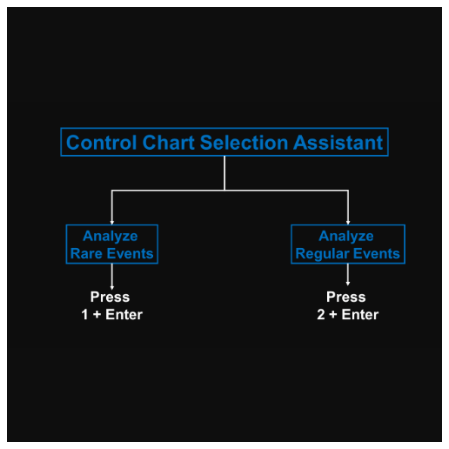



Enter the number you wish here (in the right), according to the shown in the image above: 7
Enter here (in the right) the name or number of the column (its header) that will be analyzed with the control chart.
Do not type it in quotes.
Keep the exact same format of the dataset, with spaces, characters, upper and lower cases, etc (or an error will be raised): values


Do your data have a column containing timestamps or time indication (event order)?
Type yes or no, here (in the right).
Do not type it in quotes: timestamp
Do your data have a column containing event frame indication; indication for separating time windows for comparison analysis;
stages; events to be analyzed separately; or any other indication for slicing the time axis for comparison of different means, variations, etc?
Type yes or no, here (in the right).
Do not type it in quotes: yes


Enter here (in the right) the name or number of the column containing the event frame indication.
Do not type it in quotes.
Keep the 

In [53]:

# To show the Python class attributes, use the __dict__ method:
# http://www.learningaboutelectronics.com/Articles/How-to-display-all-attributes-of-a-class-or-instance-of-a-class-in-Python.php#:~:text=So%20the%20__dict__%20method%20is%20a%20very%20useful,other%20data%20type%20such%20as%20a%20class%20itself.
                
# instantiate the object
assistant = spc_chart_assistant()

# Download the images:
assistant = assistant.download_assistant_imgs()

# Run the assistant:
while (assistant.keep_assistant_on == True):
    
    # Run the wrapped function until the user tells you to stop:
    # Notice that both variables are True for starting the first loop:
    assistant = assistant.open_chart_assistant_screen ()
        
# Delete the images
assistant.delete_assistant_imgs()
        
# Select the chart and the parameters:
chart_to_use, column_with_labels_or_subgroups, consider_skewed_dist_when_estimating_with_std, column_with_variable_to_be_analyzed, timestamp_tag_column, column_with_event_frame_indication, rare_event_timedelta_unit, rare_event_indication = assistant.chart_selection()     

In [61]:
# Delete the images
assistant.delete_assistant_imgs()

In [54]:
print(chart_to_use, column_with_labels_or_subgroups, consider_skewed_dist_when_estimating_with_std, column_with_variable_to_be_analyzed, timestamp_tag_column, column_with_event_frame_indication, rare_event_timedelta_unit, rare_event_indication)

i_mr None False values None events None None


In [60]:
def test():
    assistant = spc_chart_assistant()
    print(assistant.__dict__)

test()

{'assistant_startup': True, 'keep_assistant_on': True, 'base_git_dir': 'https://github.com/marcosoares-92/img_examples_guides/raw/main', 'new_dir': 'tmp', 'last_img_number': 18, 'numbers_to_end_assistant': (3, 4, 7, 9, 10, 13, 15, 16, 19, 20, 21, 22), 'screen_number': 0, 'file_to_fetch': '', 'img_url': '', 'img_local_path': ''}


# **Function for column filtering (selecting) or column renaming**

In [16]:
def col_filter_rename (df, cols_list, mode = 'filter'):
    
    import pandas as pd
    
    #mode = 'filter' for filtering only the list of columns passed as cols_list;
    #mode = 'rename' for renaming the columns with the names passed as cols_list.
    
    #cols_list = list of strings containing the names (headers) of the columns to select
    # (filter); or to be set as the new columns' names, according to the selected mode.
    # For instance: cols_list = ['col1', 'col2', 'col3'] will 
    # select columns 'col1', 'col2', and 'col3' (or rename the columns with these names). 
    # Declare the names inside quotes.
    
    print(f"Original columns in the dataframe:\n{df.columns}")
    
    if (mode == 'filter'):
        
        #filter the dataframe so that it will contain only the cols_list.
        df = df[cols_list]
        print("Dataframe filtered according to the list provided.")
        
    elif (mode == 'rename'):
        
        #Check if the number of columns of the dataset is equal to the number of elements
        # of the new list. It will avoid raising an exception error.
        boolean_filter = (len(cols_list) == len(df.columns))
        
        if (boolean_filter == False):
            #Impossible to rename, number of elements are different.
            print("The number of columns of the dataframe is different from the number of elements of the list. Please, provide a list with number of elements equals to the number of columns.")
        
        else:
            #Same number of elements, so that we can update the columns' names.
            df.columns = cols_list
            print("Dataframe columns renamed according to the list provided.")
            print("Warning: the substitution is element-wise: the first element of the list is now the name of the first column, and so on, ..., so that the last element is the name of the last column.")
        
        
    else:
        print("Enter a valid mode: \'filter\' or \'rename\'.")
    
    return df

# **Function for calculating general statistics from a given column**

In [3]:
def GENERAL_STATISTICS (df, column_to_analyze):
    
    import numpy as np
    import pandas as pd
    
    #df: dataframe to be analyzed.
    
    #column_to_analyze: name of the new column. e.g. column_to_analyze = 'col1'
    # will analyze column named as 'col1'
    analyzed_series = df[column_to_analyze]
    
    general_stats = analyzed_series.describe()
    print(f"General descriptive statistics from variable {column_to_analyze}, ignoring missing values:\n")
    print(general_stats)
    print("\n") #line break
    print("Interpretation: count = total of values evaluated. Missing values are ignored; mean = mean value of the series, ignoring missing values; std = standard deviation of the series, ignoring missing values; min = minimum observed value for the analyzed series; 25\% = 0.25 quantile (1st-quartile): 25\% of data fall below (<=) this value; 50\% = 2nd-quartile: 50\% <= this value; 75\% = 3rd-quartile - 75\% of data <= this value; max = maximum observed value for the analyzed series.")
    print("This function shows the general statistics only for numerical variables. The results were returned as the dataframe general_stats.")
    
    # Return only the dataframe
    return general_stats

# **Function for getting data quantiles from a given column**

In [ ]:
def GET_QUANTILES (df, column_to_analyze):
    
    import numpy as np
    import pandas as pd
    
    #df: dataframe to be analyzed.
    
    #column_to_analyze: name of the new column. e.g. column_to_analyze = 'col1'
    # will analyze column named as 'col1'
    analyzed_series = df[column_to_analyze]
    
    list_of_quantiles = []
    list_of_values = []
    list_of_interpretation = []
    
    #First element: minimum
    list_of_quantiles.append(0)
    list_of_values.append(analyzed_series.min())
    list_of_interpretation.append(f"Minimum value of {column_to_analyze}")
    
    i = 0.05
    #Start from the 5% quantile
    while (i <= 0.95):
        
        list_of_quantiles.append(i)
        list_of_values.append(analyzed_series.quantile(i))
        list_of_interpretation.append(f"{i}-quantile: {i*100}\% of data fall below this value")
        
        i = i + 0.05
    
    # Last element: maximum value
    list_of_quantiles.append(1)
    list_of_values.append(analyzed_series.max())
    list_of_interpretation.append(f"Maximum value of {column_to_analyze}")
    
    # Summarize the lists as a dictionary and convert the dictionary to a dataframe:
    quantiles_dict = {"quantile": list_of_quantiles, f"value_of_{column_to_analyze}": list_of_values,
                     "interpretation": list_of_interpretation}
    
    quantiles_summ_df = pd.DataFrame(data = quantiles_dict)
    
    print("Quantiles returned as dataframe quantiles_summ_df. Check it below:\n")
    print(quantiles_summ_df)
    
    return quantiles_summ_df

# **Function for getting a particular P-percent quantile limit**
- input P as a percent, from 0 to 100.

In [2]:
def GET_P_PERCENT_QUANTILE_LIM (df, column_to_analyze, p_percent = 100):
    
    import numpy as np
    import pandas as pd
    
    #df: dataframe to be analyzed.
    
    #column_to_analyze: name of the new column. e.g. column_to_analyze = 'col1'
    # will analyze column named as 'col1'
    
    # p_percent: float value from 0 to 100 representing the percent of the quantile
    # if p_percent = 31.2, then 31.2% of the data will fall below the returned value
    # if p_percent = 75, then 75% of the data will fall below the returned value
    # if p_percent = 0, the minimum value is returned.
    # if p_percent = 100, the maximum value is returned.
    
    analyzed_series = df[column_to_analyze]
    
    #convert the quantile to fraction
    quantile_fraction = p_percent/100.0 #.0 to guarantee a float result
    
    if (quantile_fraction < 0):
        print("Invalid percent value - it cannot be lower than zero.")
        return "error"
    
    elif (quantile_fraction == 0):
        #get the minimum value
        quantile_lim = analyzed_series.min()
        print(f"Minimum value of {column_to_analyze} = {quantile_lim}")
    
    elif (quantile_fraction == 1):
        #get the maximum value
        quantile_lim = analyzed_series.max()
        print(f"Maximum value of {column_to_analyze} = {quantile_lim}")
        
    else:
        #get the quantile
        quantile_lim = analyzed_series.quantile(quantile_fraction)
        print(f"{quantile_fraction}-quantile: {p_percent}\% of data fall below this value")
    
    return quantile_lim

# **Function for applying a list of row filters to a dataframe**

In [ ]:
def APPLY_ROW_FILTERS_LIST (df, list_of_row_filters):
    
    import numpy as np
    import pandas as pd
    
    print("Warning: this function filter the rows and results into a smaller dataset, since it removes the non-selected entries.")
    print("If you want to pass a filter to simply label the selected rows, use the function LABEL_DATAFRAME_SUBSETS, which do not eliminate entries from the dataframe.")
    
    # This function applies filters to the dataframe and remove the non-selected entries.
    
    # df: dataframe to be analyzed.
    
    ## define the filters and only them define the filters list
    # EXAMPLES OF BOOLEAN FILTERS TO COMPOSE THE LIST
    # boolean_filter1 = ((None) & (None)) 
    # (condition1 AND (&) condition2)
    # boolean_filter2 = ((None) | (None)) 
    # condition1 OR (|) condition2
    
    # boolean filters result into boolean values True or False.

    ## Examples of filters:
    ## filter1 = (condition 1) & (condition 2)
    ## filter1 = (df['column1'] > = 0) & (df['column2']) < 0)
    ## filter2 = (condition)
    ## filter2 = (df['column3'] <= 2.5)
    ## filter3 = (df['column4'] > 10.7)
    ## filter3 = (condition 1) | (condition 2)
    ## filter3 = (df['column5'] != 'string1') | (df['column5'] == 'string2')

    ## comparative operators: > (higher); >= (higher or equal); < (lower); 
    ## <= (lower or equal); == (equal); != (different)

    ## concatenation operators: & (and): the filter is True only if the 
    ## two conditions concatenated through & are True
    ## | (or): the filter is True if at least one of the two conditions concatenated
    ## through | are True.
    
    ## Pandas .isin method: you can also use this method to filter rows belonging to
    ## a given subset (the row that is in the subset is selected). The syntax is:
    ## is_black_or_brown = dogs["color"].isin(["Black", "Brown"])
    ## or: filter = (dataframe_column_series).isin([value1, value2, ...])

    ## separate conditions with parentheses. Use parentheses to define a order
    ## of definition of the conditions:
    ## filter = ((condition1) & (condition2)) | (condition3)
    ## Here, firstly ((condition1) & (condition2)) = subfilter is evaluated. 
    ## Then, the resultant (subfilter) | (condition3) is evaluated.
    
    # list_of_row_filters: list of boolean filters to be applied to the dataframe
    # e.g. list_of_row_filters = [filter1]
    # applies a single filter saved as filter 1. Notice: even if there is a single
    # boolean filter, it must be declared inside brackets, as a single-element list.
    # That is because the function will loop through the list of filters.
    # list_of_row_filters = [filter1, filter2, filter3, filter4]
    # will apply, in sequence, 4 filters: filter1, filter2, filter3, and filter4.
    # Notice that the filters must be declared in the order you want to apply them.
    
    
    #Loop through the filters list, applying the filters sequentially:
    # Each element of the list is identified as 'boolean_filter'
    for boolean_filter in list_of_row_filters:
        
        #Apply the filter:
        df = df[boolean_filter]
    
    print("Successfully filtered the dataframe. Check the 10 first rows of the filtered and returned dataframe:\n")
    print(df.head(10))
    
    return df

# **Function for selecting subsets from a dataframe (using row filters) and labelling these subsets**

In [ ]:
def LABEL_DATAFRAME_SUBSETS (df, list_of_row_filters, new_labels_list = None, new_labelled_column_name = None):
    
    import numpy as np
    import pandas as pd
    
    print("Attention: this function selects subsets from the dataframe and label them, allowing the seggregation of the data.")
    print("If you want to filter the dataframe to eliminate non-selected rows, use the function APPLY_ROW_FILTERS_LIST")
    
    ## This function selects subsets of the dataframe by applying a list
    ## of row filters, and then it labels each one of the filtered subsets.
    
    # df: dataframe to be analyzed.
    
    ## define the filters and only them define the filters list
    # EXAMPLES OF BOOLEAN FILTERS TO COMPOSE THE LIST
    # boolean_filter1 = ((None) & (None)) 
    # (condition1 AND (&) condition2)
    # boolean_filter2 = ((None) | (None)) 
    # condition1 OR (|) condition2
    
    # boolean filters result into boolean values True or False.

    ## Examples of filters:
    ## filter1 = (condition 1) & (condition 2)
    ## filter1 = (df['column1'] > = 0) & (df['column2']) < 0)
    ## filter2 = (condition)
    ## filter2 = (df['column3'] <= 2.5)
    ## filter3 = (df['column4'] > 10.7)
    ## filter3 = (condition 1) | (condition 2)
    ## filter3 = (df['column5'] != 'string1') | (df['column5'] == 'string2')

    ## comparative operators: > (higher); >= (higher or equal); < (lower); 
    ## <= (lower or equal); == (equal); != (different)

    ## concatenation operators: & (and): the filter is True only if the 
    ## two conditions concatenated through & are True
    ## | (or): the filter is True if at least one of the two conditions concatenated
    ## through | are True.
    
    ## Pandas .isin method: you can also use this method to filter rows belonging to
    ## a given subset (the row that is in the subset is selected). The syntax is:
    ## is_black_or_brown = dogs["color"].isin(["Black", "Brown"])
    ## or: filter = (dataframe_column_series).isin([value1, value2, ...])

    ## separate conditions with parentheses. Use parentheses to define a order
    ## of definition of the conditions:
    ## filter = ((condition1) & (condition2)) | (condition3)
    ## Here, firstly ((condition1) & (condition2)) = subfilter is evaluated. 
    ## Then, the resultant (subfilter) | (condition3) is evaluated.
    
    # list_of_row_filters: list of boolean filters to be applied to the dataframe
    # e.g. list_of_row_filters = [filter1]
    # applies a single filter saved as filter 1. Notice: even if there is a single
    # boolean filter, it must be declared inside brackets, as a single-element list.
    # That is because the function will loop through the list of filters.
    # list_of_row_filters = [filter1, filter2, filter3, filter4]
    # will apply, in sequence, 4 filters: filter1, filter2, filter3, and filter4.
    # Notice that the filters must be declared in the order you want to apply them.
        
    # Here, each filter will be associated with one label. Therefore, if you want to apply 
    # a filter with several conditions, combine them using the & and | operators.
    
    # The labels are input as a list of strings or of discrete integer values. There must be
    # exactly one filter to each label: the filter will be used to obtain a subset from
    # the dataframe, and the label will be applied to all the rows of this subset.
    # e.g. list_of_row_filters = [filter1, filter2], new_labels_list = ['label1', 'label2']
    # In this case, the rows of the dataset obtained when applying filter1 will receive the
    # string 'label1' as label. In turns, 
    # rows selected from filter2 will be labelled as 'label2'.
    # list_of_row_filters = [filter1, filter2, filter3], new_labels_list = [1, 2, 3]
    # Here, the labels are integers: rows filtered through filter1 are marked as 1;
    # rows selected by filter2 are labelled as 2; and rows selected from filter3 are marked
    # as 3.
    
    # Warning: the sequence of filters must be correspondent to the sequence of labels. 
    # Rows selected from the first filter are labelled with the first item from the labels
    # list; rows selected by the 2nd filter are labelled with the 2nd element, and so on.
    
    # If no list of labels is provided, a list of integers starting from zero and with the
    # same total of elements from list_of_row_filters will be created. For instance,
    # if list_of_row_filters = [filter1, filter2, filter3, filter4], the list of labels
    # [0, 1, 2, 3] would be created. Again, the rows selected from filter1 would be labelled
    # as 0; rows selected from filter 2 would be labelled as 1; and so on.
    
    # new_labelled_column_name = None. Alternatively, declare a string (inside quotes), with
    # the name of the column containing the applied labels. For example, if
    # new_labelled_column_name = 'labels', then the new labels are saved in the column 'labels'
    # If no new_labelled_column_name is provided, the default name = "df_label" is provided.
    
    if (new_labelled_column_name is None):
        
        new_labelled_column_name = "df_label"
    
    if (new_labels_list is None):
        
        #Create a list of integers with the same length as list_of_row_filters
        # start the list:
        new_labels_list = []
        # Append the value zero:
        new_labels_list.append(0)
        
        #check the total of elements of list list_of_row_filters:
        total_of_filters = len(list_of_row_filters)
        
        #loop from i = 1 to i = (total_of_filters - 1), index of the last element from
        #list total_of_filters. Append these values to the list of new labels:
        for i in range (1, total_of_filters):
            #i goes from 1 to (total_of_filters - 1).
            # the element 0 was already added
            new_labels_list.append(i)
            # now we have a list of integers from 0 to (total_of_filters - 1), where each
            # number is a label to be applied to the rows selected from one of the filters.
        
    # Let's select rows applying the filters, and label them according    
    
    #Loop through the filters list, applying the filters sequentially:
    # Each element of the list is identified as 'boolean_filter'
    for i in range (0, total_of_filters):
        # Here, i ranges from 0 to total_of_filters - 1, index of the last element
        # We specifically declare 0 as the first element to avoid problems derived
        # from the fact that a counting variable i was already used and could have a
        # value in the memory. The value 0 is the default when only one value is declared
        # as argument from range
        
        #select the boolean filter from list_of_row_filters. It is the i-th indexed element 
        boolean_filter = list_of_row_filters[i]
        # Select the correspondent label from new_labels_list:
        applied_label = new_labels_list[i]
        
        #Apply the filter to select a group of rows, and apply the correspondent label
        # to the selected rows
        
        # syntax: dataset.loc[dataset['column_filtered'] <= 0.87, 'labelled_column'] = 1
        # which is equivalent to dataset.loc[(filter), 'labelled_column'] = label
        df.loc[(boolean_filter), new_labelled_column_name] = applied_label
    
    print("Successfully labelled the dataframe. Check the 10 first rows of the labelled and returned dataframe:\n")
    print(df.head(10))
    
    return df

# **Function for performing Analysis of Variance (ANOVA) and obtaining boxplots**

In [61]:
def anova_boxplot (df, column_to_analyze, column_with_group_labels = None, confidence_level = 0.95, boxplot_notch = False, boxplot_vertically_oriented = True, boxplot_patch_artist = False,  reference_value = None, x_axis_rotation = 0, y_axis_rotation = 0, grid = True, export_png = False, directory_to_save = None, file_name = None, png_resolution_dpi = 110):
        
        print ("If an error message is shown, update statsmodels. Declare and run a cell as:")
        print ("!pip install statsmodels --upgrade")
        import numpy as np
        import pandas as pd
        import matplotlib.pyplot as plt
        from statsmodels.stats.oneway import anova_oneway
        
        # df: dataframe to be analyzed.
    
        #column_to_analyze: name of the new column. e.g. column_to_analyze = 'col1'
        # will analyze column named as 'col1'
        
        # column_with_group_labels: name of the column registering groups, labels, or
        # factors correspondent to each row. e.g. column_with_group_labels = "group"
        # if the correspondent group is saved as column named 'group'.
        # If no name is provided, then the default name is used:
        # COLUMN_WITH_GROUP_LABELS = COLUMN_TO_ANALYZE + "_label"
        
        if (column_with_group_labels is None):
            
            column_with_group_labels = column_to_analyze + "_label"
    
        # CONFIDENCE_LEVEL = 0.95 = 95% confidence
        # Set CONFIDENCE_LEVEL = 0.90 to get 0.90 = 90% confidence in the analysis.
        # Notice that, when less trust is needed, we can reduce CONFIDENCE_LEVEL 
        # to get less restrictive results.
        alpha = 1 - confidence_level
        
        # reference_value: keep it as None or add a float value.
        # This reference value will be shown as a red constant line on the plot to be compared
        # with the boxes. e.g. reference_value = 1.0 will plot a red line passing through
        # column_to_analyze = 1.0
        
        # boxplot_notch = False
        # Manipulate parameter notch (boolean, default: False) from the boxplot object
        # Whether to draw a notched boxplot (True), or a rectangular boxplot (False). 
        # The notches represent the confidence interval (CI) around the median. 
        # The documentation for bootstrap describes how the locations of the notches are 
        # computed by default, but their locations may also be overridden by setting the 
        # conf_intervals parameter.
        
        # boxplot_vertically_oriented = True
        # Manipulate the parameter vert (boolean, default: True)
        # If True, draws vertical boxes. If False, draw horizontal boxes.
        
        # boxplot_patch_artist = False
        # Manipulate parameter patch_artist (boolean, default: False)
        # If False produces boxes with the Line2D artist. Otherwise, boxes are drawn 
        # with Patch artists.
        # Check documentation:
        # https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.boxplot.html
        
        # Create a local copy of the dataframe to be manipulated:
        DATASET = df
        
        # Sort the dataframe by the groups/factors column (column_with_group_labels):
        DATASET = DATASET.sort_values(column_with_group_labels, ascending = True)
        
        # Reset the index of the new dataframe:
        DATASET = DATASET.reset_index(drop = True)
        
        # Get a series for the analyzed values and for the 
        # column with the correspondent labels:
        analyzed_series = DATASET[column_to_analyze]
        groups_series = DATASET[column_with_group_labels]
        
        # Get a series of unique values of groups
        # Convert the series of columns into a NumPy array
        array_of_groups = np.array(groups_series)
        
        #Keep only the unique values into this array:
        array_of_groups = np.unique(array_of_groups)
        
        #Get the total of groups
        total_of_groups = len(array_of_groups)
        
        
        # Create a dictionary of NumPy arrays. This dictionary will store NumPy arrays
        # correspondent to the elements of each group:
        values_for_each_group_dict = {}
        
        # Loop through each element of the array_of_groups (array with unique values).
        # The elements of array_of_groups are identified as 'group'
        for group in array_of_groups:
            
            #start a list to store the values:
            analyzed_vals_list = []
            
            # Now loop through each row of the dataframe. The dataframe row index go from
            # zero to len(DATASET) - 1:
            for i in range((len(DATASET) - 1)):
                #loop go from i = 0 to i = len(DATASET) - 1, index of the last row
                
                # if the row in index is correspondent to the grouping/label 'group',
                # then store the analyzed value into list analyzed_vals_list:
                if (groups_series[i] == group):
                    
                    analyzed_vals_list.append(analyzed_series[i])
            
            # lets convert the lists into NumPy arrays:
            analyzed_vals_array = np.array(analyzed_vals_list)
            
            # Now let's update the dictionary values_for_each_group_dict
            # 1. Set the 'key' of the dictionary as the name of the group
            dict_key = group
            
            # Use the update method to add the key 'dict_key', and the 
            # array analyzed_vals_array as the value correspondent to the key.
            
            # syntax: dict.update({"key": value})
            # check: https://www.w3schools.com/python/ref_dictionary_update.asp
            
            values_for_each_group_dict.update({dict_key: analyzed_vals_array})
        
        # Now, the dictionary values_for_each_group_dict stores each group name as its keys
        # and the arrays of analyzed values as the correspondent object.
        
        # Notice that the keys of the dictionary were created with the same order of
        # array_of_groups, so there is no risk of losing the correspondence
        
        # Create a humongous list of arrays, containing the arrays stored into the
        # dictionary. It is necessary for the statsmodels API:
        humongous_list = []
        
        # Loop through each key of the dictionary:
        for group in values_for_each_group_dict.keys():
            # loop through each element of the array of keys from the dictionary.
            # each element is named 'group'.
            # append the correspondent array as an element from humongous_list
            humongous_list.append(values_for_each_group_dict[group])
        
        #Now, we can pass the humongous_list as argument for the one-way Anova:
        anova_one_way_summary = anova_oneway(humongous_list, groups = array_of_groups, use_var = 'bf', welch_correction=True, trim_frac=0)
        # When use_var = 'bf', variances are not assumed to be equal across samples.
        # Check documentation: 
        # https://www.statsmodels.org/stable/generated/statsmodels.stats.oneway.anova_oneway.html
        
        # The information is stored in a tuple (f_statistic, p-value)
        # f_statistic: Test statistic for k-sample mean comparison which is approximately 
        # F-distributed.
        # p-value: If use_var="bf", then the p-value is based on corrected degrees of freedom following Mehrotra 1997.
        f_statistic = anova_one_way_summary[0]
        p_value = anova_one_way_summary[1]
        
        print(f"Probability that the means of the groups are the same = {100*p_value}\% (p-value = {p_value})")
        print(f"Calculated F-statistic for the variances = {f_statistic}")
        
        if (p_value <= alpha):
            print(f"For a confidence level of {confidence_level*100}\%, we can reject the null hypothesis.")
            print(f"The means are different for a {confidence_level*100}\% confidence level.")
        
        else:
            print(f"For a confidence level of {confidence_level*100}\%, we can accept the null hypothesis.")
            print(f"The means are equal for a {confidence_level*100}\% confidence level.")
        
        print("Check ANOVA summary:\n")
        print(anova_one_way_summary)
        # When printing the summary, the set of supporting information of the Tuple are shown.
        
        anova_summary_dict = {'F_statistic': f_statistic, 'p_value': p_value}
        
        #Now, let's obtain the boxplot
        fig, ax = plt.subplots()
                    
        # rectangular box plot
        # The arrays of each group are the elements of the list humongous_list
        boxplot_returned_dict = ax.boxplot(humongous_list, labels = array_of_groups, notch = boxplot_notch, vert = boxplot_vertically_oriented, patch_artist = boxplot_patch_artist)
        
        # boxplot_returned_dict: A dictionary mapping each component of the boxplot to 
        # a list of the Line2D instances created. That dictionary has the following keys 
        # (assuming vertical boxplots):
        # boxes: the main body of the boxplot showing the quartiles and the median's 
        # confidence intervals if enabled.
        # medians: horizontal lines at the median of each box.
        # whiskers: the vertical lines extending to the most extreme, non-outlier data 
        # points.
        # caps: the horizontal lines at the ends of the whiskers.
        # fliers: points representing data that extend beyond the whiskers (fliers).
        # means: points or lines representing the means.
          
        ax.set_title(f"Boxplot of {column_to_analyze} by {col_with_group_indication}")
        
        if (boxplot_vertically_oriented == True):
            # generate vertically-oriented boxplot
        
            ax.set(ylabel = column_to_analyze)
            # If the boxplot was horizontally oriented, this label should be the X instead.
            # The X labels were already defined when creating the boxplot
                    
            if not (reference_value is None):
                # Add an horizontal reference_line to compare against the boxes:
                # If the boxplot was horizontally-oriented, this line should be vertical instead.
                ax.axhline(reference_value, color = 'red', linestyle = 'dashed', label = 'Reference value')
                # axhline generates an horizontal (h) line on ax
                
        else:
            # In case it is False, generate horizontally-oriented plot:
            ax.set(xlabel = column_to_analyze)
            # The Y labels were already defined when creating the boxplot
                    
            if not (reference_value is None):
                # Add an horizontal reference_line to compare against the boxes:
                # If the boxplot was horizontally-oriented, this line should be vertical instead.
                ax.axvline(reference_value, color = 'red', linestyle = 'dashed', label = 'Reference value')
                # axvline generates a vertical (v) line on ax
        
            # Now, we can add general components of the graphic:
            #Create an almost transparent horizontal line to guide the eyes without distracting
            ax.yaxis.grid(grid, linestyle='-', which = 'major', color = 'lightgrey', alpha = 0.5)
            ax.xaxis.grid(grid, linestyle='-', which = 'major', color = 'lightgrey', alpha = 0.5)       
            
            #ROTATE X AXIS IN XX DEGREES
            plt.xticks(rotation = x_axis_rotation)
            # XX = 70 DEGREES x_axis (Default)
            #ROTATE Y AXIS IN XX DEGREES:
            plt.yticks(rotation = y_axis_rotation)
            # XX = 0 DEGREES y_axis (Default)
            ax.legend()

            if (export_png == True):
                # Image will be exported
                import os

                #check if the user defined a directory path. If not, set as the default root path:
                if (directory_to_save is None):
                    #set as the default
                    directory_to_save = "/"

                #check if the user defined a file name. If not, set as the default name for this
                # function.
                if (file_name is None):
                    #set as the default
                    file_name = "boxplot"

                #check if the user defined an image resolution. If not, set as the default 110 dpi
                # resolution.
                if (png_resolution_dpi is None):
                    #set as 110 dpi
                    png_resolution_dpi = 110

                #Get the new_file_path
                new_file_path = os.path.join(directory_to_save, file_name)

                #Export the file to this new path:
                # The extension will be automatically added by the savefig method:
                plt.savefig(new_file_path, dpi = png_resolution_dpi, quality = 100, format = 'png', transparent = False) 
                #quality could be set from 1 to 100, where 100 is the best quality
                #format (str, supported formats) = 'png', 'pdf', 'ps', 'eps' or 'svg'
                #transparent = True or False
                # For other parameters of .savefig method, check https://indianaiproduction.com/matplotlib-savefig/
                print (f"Figure exported as \'{new_file_path}.png\'. Any previous file in this root path was overwritten.")

            #Set image size (x-pixels, y-pixels) for printing in the notebook's cell:
            plt.figure(figsize=(12, 8))
            #fig.tight_layout()

            ## Show an image read from an image file:
            ## import matplotlib.image as pltimg
            ## img=pltimg.imread('mydecisiontree.png')
            ## imgplot = plt.imshow(img)
            ## See linkedIn Learning course: "Supervised machine learning and the technology boom",
            ##  Ex_Files_Supervised_Learning, Exercise Files, lesson '03. Decision Trees', '03_05', 
            ##  '03_05_END.ipynb'
            plt.show()
            
            print("\n") #line break
            print("Successfully returned 2 dictionaries: anova_summary_dict (dictionary storing ANOVA F-test and p-value); and boxplot_returned_dict (dictionary mapping each component of the boxplot).\n")
            
            print("Boxplot interpretation:")
            print("Boxplot presents the following key visual components:")
            print("The main box represents the Interquartile Range (IQR). It represents the data that is from quartile Q1 to quartile Q3.")
            print("Q1 = 1st quartile of the dataset. 25% of values lie below this level (i.e., it is the 0.25-quantile or percentile).")
            print("Q2 = 2nd quartile of the dataset. 50% of values lie above and below this level (i.e., it is the 0.50-quantile or percentile).")
            print("Q3 = 3rd quartile of the dataset. 75% of values lie below and 25% lie above this level (i.e., it is the 0.75-quantile or percentile).")
            print("Boxplot main box (the IQR) is divided by an horizontal line if it is vertically-oriented; or by a vertical line if it is horizontally-oriented.")
            print("This line represents the median: it is the midpoint of the dataset.")
            print("There are lines extending beyond the main boxes limits. This lines end in horizontal limits, if the boxplot is vertically oriented; or in vertical limits, for an horizontal plot.")
            print("The minimum limit of the boxplot is defined as: Q1 - (1.5) x (IQR width) = Q1 - 1.5*(Q3-Q1)")
            print("The maximum limit of the boxplot is defined as: Q3 + (1.5) x (IQR width) = Q3 + 1.5*(Q3-Q1)")
            print("Finally, there are isolated points (circles) on the plot.")
            print("These points lie below the minimum bar, or above the maximum bar line. They are defined as outliers.")
            # https://nickmccullum.com/python-visualization/boxplot/
            
            return anova_summary_dict, boxplot_returned_dict

# **Function for concatenating (SQL UNION) multiple dataframes**
- Vertical concatenation of the dataframes.
- Equivalent to SQL Union: vertical stack/append of the tables.

In [50]:
def UNION_DATAFRAMES (list_of_dataframes, what_to_append = 'rows', ignore_index_on_union = True, sort_values_on_union = True, union_join_type = None):
    
    import pandas as pd
    #JOIN can be 'inner' to perform an inner join, eliminating the missing values
    #The default (None) is 'outer': the dataframes will be stacked on the columns with
    #same names but, in case there is no correspondence, the row will present a missing
    #value for the columns which are not present in one of the dataframes.
    #When using the 'inner' method, only the common columns will remain
    
    #list_of_dataframes must be a list containing the dataframe objects
    # example: list_of_dataframes = [df1, df2, df3, df4]
    #Notice that the dataframes are objects, not strings. Therefore, they should not
    # be declared inside quotes.
    # There is no limit of dataframes. In this example, we will concatenate 4 dataframes.
    # If list_of_dataframes = [df1, df2, df3] we would concatenate 3, and if
    # list_of_dataframes = [df1, df2, df3, df4, df5] we would concatenate 5 dataframes.
    
    # what_to_append = 'rows' for appending the rows from one dataframe
    # into the other; what_to_append = 'columns' for appending the columns
    # from one dataframe into the other (horizontal or lateral append).
    
    # When what_to_append = 'rows', Pandas .concat method is defined as
    # axis = 0, i.e., the operation occurs in the row level, so the rows
    # of the second dataframe are added to the bottom of the first one.
    # It is the SQL union, and creates a dataframe with more rows, and
    # total of columns equals to the total of columns of the first dataframe
    # plus the columns of the second one that were not in the first dataframe.
    # When what_to_append = 'columns', Pandas .concat method is defined as
    # axis = 1, i.e., the operation occurs in the column level: the two
    # dataframes are laterally merged using the index as the key, 
    # preserving all columns from both dataframes. Therefore, the number of
    # rows will be the total of rows of the dataframe with more entries,
    # and the total of columns will be the sum of the total of columns of
    # the first dataframe with the total of columns of the second dataframe.
    
    #The other parameters are the same from Pandas .concat method.
    # ignore_index_on_union = ignore_index;
    # sort_values_on_union = sort
    # union_join_type = join
    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.concat.html
    
    #Check Datacamp course Joining Data with pandas, Chap.3, 
    # Advanced Merging and Concatenating
    
    # Check axis:
    if (what_to_append == 'rows'):
        
        AXIS = 0
    
    elif (what_to_append == 'columns'):
        
        AXIS = 1
    
    else:
        print("No valid string was input to what_to_append, so appending rows (vertical append, equivalent to SQL UNION).")
        AXIS = 0
    
    if (union_join_type == 'inner'):
        
        print("Warning: concatenating dataframes using the \'inner\' join method, that removes missing values.")
        concat_df = pd.concat(list_of_dataframes, axis = AXIS, ignore_index = ignore_index_on_union, sort = sort_values_on_union, join = union_join_type)
    
    else:
        
        #In case None or an invalid value is provided, use the default 'outer', by simply
        # not declaring the 'join':
        concat_df = pd.concat(list_of_dataframes, axis = AXIS, ignore_index = ignore_index_on_union, sort = sort_values_on_union)
    
    # Pandas .head(Y) method results in a dataframe containing the first Y rows of the 
    # original dataframe. The default .head() is Y = 5. Print first 10 rows of the 
    # new dataframe:
    print("Dataframes successfully concatenated. Check the 10 first rows of new dataframe:\n")
    print(concat_df.head(10))
    
    #Now return the concatenated dataframe:
    
    return concat_df

# **Function for time series visualization**
        x1, y1, lab1: blue
        x2, y2, lab2: red
        x3, y3, lab3: green
        x4, y4, lab4: black
        x5, y5, lab5: magenta
        x6, y6, lab6: yellow

In [13]:
def time_series_vis (x1 = None, y1 = None, x2 = None, y2 = None, x3 = None, y3 = None, x4 = None, y4 = None, x5 = None, y5 = None, x6 = None, y6 = None, x_axis_rotation = 70, y_axis_rotation = 0, grid = True, add_splines_lines = True, add_scatter_dots = False, lab1 = None, lab2 = None, lab3 = None, lab4 = None, lab5 = None, lab6 = None, horizontal_axis_title = None, vertical_axis_title = None, plot_title = None, export_png = False, directory_to_save = None, file_name = None, png_resolution_dpi = 110):
    
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    
    if (add_splines_lines == True):
        line_value = '-'
    else:
        line_value = ''
    
    if (add_scatter_dots == True):
        marker_value = 'o'
    else:
        marker_value = ''
    
    fig = plt.figure()
    ax = fig.add_subplot()
    
    if not (lab1 is None):
        
        label_1 = lab1
    
    else:
        label_1 = "Y1"

    if not (x1 is None):
        ax.plot(x1, y1, linestyle = line_value, marker = marker_value, color='blue', label=label_1)
    
    if not (x2 is None):
        #runs only when both are present
        if not (lab2 is None):
            label_2 = lab2
        else:
            label_2 = "Y2"
        
        ax.plot(x2, y2, linestyle = line_value, marker = marker_value, color='red', label=label_2)
    
    if not (x3 is None):
                
        if not (lab3 is None):
            label_3 = lab3
        else:
            label_3 = "Y3"
        
        ax.plot(x3, y3, linestyle = line_value, marker = marker_value, color='green', label=label_3)
    
    if not (x4 is None):
                
        if not (lab4 is None):
            label_4 = lab4
        else:
            label_4 = "Y4"
        
        ax.plot(x4, y4, linestyle = line_value, marker = marker_value, color='black', label=label_4)
    
    if not (x5 is None):
               
        if not (lab5 is None):
            label_5 = lab5
        else:
            label_5 = "Y5"
        
        ax.plot(x5, y5, linestyle = line_value, marker = marker_value, color='magenta', label=label_5)
   
    if not (x6 is None):
               
        if not (lab6 is None):
            label_6 = lab6
        else:
            label_6 = "Y6"
        
        ax.plot(x6, y6, linestyle = line_value, marker = marker_value, color='yellow', label=label_6)
   
    if not (plot_title is None):
        #graphic's title
        ax.set_title(plot_title) 
    
    if not (horizontal_axis_title is None):
        #X-axis title
        ax.set_xlabel(horizontal_axis_title)
    
    if not (vertical_axis_title is None):
        #Y-axis title
        ax.set_ylabel(vertical_axis_title)
    
    #ROTATE X AXIS IN XX DEGREES
    plt.xticks(rotation = x_axis_rotation)
    # XX = 70 DEGREES x_axis (Default)
    #ROTATE Y AXIS IN XX DEGREES:
    plt.yticks(rotation = y_axis_rotation)
    # XX = 0 DEGREES y_axis (Default)
    
    ax.grid(grid)
    ax.legend()
    
    if (export_png == True):
        # Image will be exported
        import os
        
        #check if the user defined a directory path. If not, set as the default root path:
        if (directory_to_save is None):
            #set as the default
            directory_to_save = "/"
        
        #check if the user defined a file name. If not, set as the default name for this
        # function.
        if (file_name is None):
            #set as the default
            file_name = "time_series_vis"
        
        #check if the user defined an image resolution. If not, set as the default 110 dpi
        # resolution.
        if (png_resolution_dpi is None):
            #set as 110 dpi
            png_resolution_dpi = 110
        
        #Get the new_file_path
        new_file_path = os.path.join(directory_to_save, file_name)
        
        #Export the file to this new path:
        # The extension will be automatically added by the savefig method:
        plt.savefig(new_file_path, dpi = png_resolution_dpi, quality = 100, format = 'png', transparent = False) 
        #quality could be set from 1 to 100, where 100 is the best quality
        #format (str, supported formats) = 'png', 'pdf', 'ps', 'eps' or 'svg'
        #transparent = True or False
        # For other parameters of .savefig method, check https://indianaiproduction.com/matplotlib-savefig/
        print (f"Figure exported as \'{new_file_path}.png\'. Any previous file in this root path was overwritten.")
    
    #Set image size (x-pixels, y-pixels) for printing in the notebook's cell:
    plt.figure(figsize=(12, 8))
    #fig.tight_layout()
    
    ## Show an image read from an image file:
    ## import matplotlib.image as pltimg
    ## img=pltimg.imread('mydecisiontree.png')
    ## imgplot = plt.imshow(img)
    ## See linkedIn Learning course: "Supervised machine learning and the technology boom",
    ##  Ex_Files_Supervised_Learning, Exercise Files, lesson '03. Decision Trees', '03_05', 
    ##  '03_05_END.ipynb'
    plt.show()

# **Functions for histogram visualization**
- Function `histogram`: ideal bin interval is calculated through Montgomery's method. Histogram is obtained from this calculated bin size.
    - Douglas C. Montgomery (2009). Introduction to Statistical Process Control, Sixth Edition, John Wiley & Sons.
- Function `histogram_alternative`: histogram is obtained by manually defining the total of bins (i.e., into how much intervals the sample space should be divided).

In [27]:
def histogram (y, bar_width, x_axis_rotation = 70, y_axis_rotation = 0, grid = True, normal_curve_overlay = True, data_units_label = None, y_title = None, histogram_title = None, export_png = False, directory_to_save = None, file_name = None, png_resolution_dpi = 110):
    
    import numpy as np
    import pandas as pd
    import matplotlib
    import matplotlib.pyplot as plt
    
    # ideal bin interval calculated through Montgomery's method. 
    # Histogram is obtained from this calculated bin size.
    # Douglas C. Montgomery (2009). Introduction to Statistical Process Control, 
    # Sixth Edition, John Wiley & Sons.
    
    
    #Calculo do bin size - largura do histograma:
    #1: Encontrar o menor (lowest) e o maior (highest) valor dentro da tabela de dados)
    #2: Calcular rangehist = highest - lowest
    #3: Calcular quantidade de dados (samplesize) de entrada fornecidos
    #4: Calcular a quantidade de celulas da tabela de frequencias (ncells)
    #ncells = numero inteiro mais proximo da (raiz quadrada de samplesize)
    #5: Calcular binsize = rangehist/(ncells)
    #ATENCAO: Nao se esquecer de converter range, ncells, samplesize e binsize para valores absolutos (modulos)
    #isso porque a largura do histograma tem que ser um numero positivo

    y = y.reset_index(drop=True)
    #faz com que os indices desta serie sejam consecutivos e a partir de zero

    #Estatisticas gerais: media (mu) e desvio-padrao (sigma)
    mu = y.mean() 
    sigma = y.std() 

    #Calculo do bin-size
    highest = y.max()
    lowest = y.min()
    rangehist = highest - lowest
    rangehist = abs(rangehist)
    #garante que sera um numero positivo
    samplesize = y.count() #contagem do total de entradas
    ncells = (samplesize)**0.5 #potenciacao: ** - raiz quadrada de samplesize
    #resultado da raiz quadrada e sempre positivo
    ncells = round(ncells) #numero "redondo" mais proximo
    ncells = int(ncells) #parte inteira do numero arredondado
    #ncells = numero de linhas da tabela de frequencias
    binsize = rangehist/ncells
    binsize = round(binsize)
    binsize = int(binsize) #precisa ser inteiro
    
    #Construcao da tabela de frequencias

    j = 0 #indice da tabela de frequencias
    #Este indice e diferente do ordenamento dos valores em ordem crescente
    xhist = []
    #Lista vazia que contera os x do histograma
    yhist = []
    #Listas vazia que conteras o y do histograma
    hist_labels = []
    #Esta lista gravara os limites da barra na forma de strings

    pontomediodabarra = lowest + binsize/2 
    limitedabarra = lowest + binsize
    #ponto medio da barra 
    #limite da primeira barra do histograma
    seriedohist1 = y
    seriedohist1 = seriedohist1.sort_values(ascending=True)
    #serie com os valores em ordem crescente
    seriedohist1 = seriedohist1.reset_index(drop=True)
    #garante que a nova serie tenha indices consecutivos, iniciando em zero
    i = 0 #linha inicial da serie do histograma em ordem crescente
    valcomparado = seriedohist1[i]
    #primeiro valor da serie, o mais baixo

    while (j <= (ncells-1)):
        
        #para quando termina o numero de linhas da tabela
        xhist.append(pontomediodabarra)
        #tempo da tabela de frequencias
        cont = 0
        #variavel de contagem do histograma
        #contagem deve ser reiniciada
       
        if (i < samplesize):
            #2 condicionais para impedir que um termo de indice inexistente
            #seja acessado
            while (valcomparado <= limitedabarra) and (valcomparado < highest):
                #o segundo criterio garante a parada em casos em que os dados sao
                #muito proximos
                    cont = cont + 1 #adiciona contagem a tabela de frequencias
                    i = i + 1
                    
                    if (i < samplesize): 
                        valcomparado = seriedohist1[i]
        
        yhist.append(cont) #valor de ocorrencias contadas
        
        limite_infdabarra = pontomediodabarra - binsize/2
        rotulo = "%.2f - %.2f" %(limite_infdabarra, limitedabarra)
        #intervalo da tabela de frequencias
        #%.2f: 2 casas decimais de aproximação
        hist_labels.append(rotulo)
        
        pontomediodabarra = pontomediodabarra + binsize
        #tanto os pontos medios quanto os limites se deslocam do mesmo intervalo
        
        limitedabarra = limitedabarra + binsize
        #proxima barra
        
        j = j + 1
    
    #Temos que verificar se o valor maximo foi incluido
    #isso porque o processo de aproximacao por numero inteiro pode ter
    #arredondado para baixo e excluido o limite superior
    #Porem, note que na ultima iteracao o limite superior da barra foi 
    #somado de binsize, mas como j ja e maior que ncells-1, o loop parou
    
    #assim, o limitedabarra nesse momento e o limite da barra que seria
    #construida em seguida, nao da ultima barra da tabela de frequencias
    #isso pode fazer com que esta barra ja seja maior que o highest
    
    #note porem que nao aumentamos o valor do limite inferior da barra
    #por isso, basta vermos se ele mais o binsize sao menores que o valor mais alto
        
    while ((limite_infdabarra+binsize) < highest):
        
        #vamos criar novas linhas ate que o ponto mais alto do histograma
        #tenha sido contado
        ncells = ncells + 1 #adiciona uma linha a tabela de frequencias
        xhist.append(pontomediodabarra)
        
        cont = 0 #variavel de contagem do histograma
        
        while (valcomparado <= limitedabarra):
                cont = cont + 1 #adiciona contagem a tabela de frequencias
                i = i + 1
                if (i < samplesize):
                    valcomparado = seriedohist1[i]
                    #apenas se i ainda nao e maior que o total de dados
                
                else: 
                    
                    break
        
        #parar o loop se i atingiu um tamanho maior que a quantidade 
        #de dados.Temos que ter este cuidado porque estamos acrescentando
        #mais linhas a tabela de frequencias para corrigir a aproximacao
        #de ncells por um numero inteiro
        
        yhist.append(cont) #valor de ocorrencias contadas
        
        limite_infdabarra = pontomediodabarra - binsize/2
        rotulo = "%.2f - %.2f" %(limite_infdabarra, limitedabarra)
        #intervalo da tabela de frequencias - 2 casas decimais
        hist_labels.append(rotulo)
        
        pontomediodabarra = pontomediodabarra + binsize
        #tanto os pontos medios quanto os limites se deslocam do mesmo intervalo
        
        limitedabarra = limitedabarra + binsize
        #proxima barra
        
    estatisticas_col1 = []
    #contera as descricoes das colunas da tabela de estatisticas gerais
    estatisticas_col2 = []
    #contera os valores da tabela de estatisticas gerais
    
    estatisticas_col1.append("Count of data evaluated")
    estatisticas_col2.append(samplesize)
    estatisticas_col1.append("Average (mu)")
    estatisticas_col2.append(mu)
    estatisticas_col1.append("Standard deviation (sigma)")
    estatisticas_col2.append(sigma)
    estatisticas_col1.append("Highest value")
    estatisticas_col2.append(highest)
    estatisticas_col1.append("Lowest value")
    estatisticas_col2.append(lowest)
    estatisticas_col1.append("Data range (maximum value - lowest value)")
    estatisticas_col2.append(rangehist)
    estatisticas_col1.append("Bin size (bar width)")
    estatisticas_col2.append(binsize)
    estatisticas_col1.append("Total rows in frequency table")
    estatisticas_col2.append(ncells)
    #como o comando append grava linha a linha em sequencia, garantimos
    #a correspondencia das colunas
    #Assim como em qualquer string, incluindo de rotulos de graficos
    #os \n sao lidos como quebra de linha
    
    d1 = {"General Statistics": estatisticas_col1, "Calculated Value": estatisticas_col2}
    #dicionario das duas series, para criar o dataframe com as descricoes
    estatisticas_gerais = pd.DataFrame(data = d1)
    
    #Casos os títulos estejam presentes (valor nao e None):
    #vamos utiliza-los
    #Caso contrario, vamos criar nomenclaturas genericas para o histograma
    
    eixo_y = "Counting/Frequency"
    
    if not (data_units_label is None):
        xlabel = data_units_label
    
    else:
        xlabel = "Frequency\n table data"
    
    if not (y_title is None):
        eixo_x = y_title
        #lembre-se que no histograma, os dados originais vao pro eixo X
        #O eixo Y vira o eixo da contagem/frequencia daqueles dados
    
    else:
        eixo_x = "X: Mean value of the interval"
    
    if not (histogram_title is None):
        string1 = "- $\mu = %.2f$, $\sigma = %.2f$" %(mu, sigma)
        main_label = histogram_title + string1
        #concatena a string do titulo a string com a media e desvio-padrao
        #%.2f: o numero entre %. e f indica a quantidade de casas decimais da 
        #variavel float f. No caso, arredondamos para 2 casas
        #NAO SE ESQUECA DO PONTO: ele que indicara que sera arredondado o 
        #numero de casas
    
    else:
        main_label = "Data Histogram - $\mu = %.2f$, $\sigma = %.2f$" %(mu, sigma)
        #os simbolos $\ $ substituem o simbolo pela letra grega
    
    d2 = {"Considered interval": hist_labels, eixo_x: xhist, eixo_y: yhist}
    #dicionario que compoe a tabela de frequencias
    tab_frequencias = pd.DataFrame(data = d2)
    #cria a tabela de frequencias como um dataframe de saida
   
    #parametros da normal ja calculados:
    #mu e sigma
    #numero de bins: ncells
    #limites de especificacao: lsl,usl - target
    
    #valor maximo do histograma
    max_hist = max(yhist)
    #seleciona o valor maximo da serie, para ajustar a curva normal
    #isso porque a normal é criada com valores entre 0 e 1
    #multiplicando ela por max_hist, fazemos ela se adequar a altura do histograma
    
    if (normal_curve_overlay == True):
        
        #construir a normal ajustada/esperada
        #vamos criar pontos ao redor da media mu - 4sigma ate mu + 4sigma, 
        #de modo a garantir a quase totalidade da curva normal. 
        #O incremento será de 0.10 sigma a cada iteracao
        x_inf = mu -(4)*sigma
        x_sup = mu + 4*sigma
        x_inc = (0.10)*sigma
        
        x_normal_adj = []
        y_normal_adj = []
        
        x_adj = x_inf
        y_adj = ((1 / (np.sqrt(2 * np.pi) * sigma)) *np.exp(-0.5 * (1 / sigma * (x_adj - mu))**2))
        x_normal_adj.append(x_adj)
        y_normal_adj.append(y_adj)
        
        while(x_adj < x_sup): 
            
            x_adj = x_adj + x_inc
            y_adj = ((1 / (np.sqrt(2 * np.pi) * sigma)) *np.exp(-0.5 * (1 / sigma * (x_adj - mu))**2))
            x_normal_adj.append(x_adj)
            y_normal_adj.append(y_adj)
        
        #vamos ajustar a altura da curva ao histograma. Para isso, precisamos
        #calcular quantas vezes o ponto mais alto do histograma é maior que o ponto
        #mais alto da normal (chamaremos essa relação de fator). A seguir,
        #multiplicamos cada elemento da normal por este mesmo fator
        max_normal = max(y_normal_adj) 
        #maximo da normal ajustada, numero entre 0 e 1
        
        fator = (max_hist)/(max_normal)
        size_normal = len(y_normal_adj) #quantidade de dados criados
        
        i = 0
        while (i < size_normal):
            y_normal_adj[i] = (y_normal_adj[i])*(fator)
            i = i + 1
    
    #Fazer o grafico
    fig, ax = plt.subplots()
    
    #ROTATE X AXIS IN XX DEGREES
    plt.xticks(rotation = x_axis_rotation)
    # XX = 70 DEGREES x_axis (Default)
    #ROTATE Y AXIS IN XX DEGREES:
    plt.yticks(rotation = y_axis_rotation)
    # XX = 0 DEGREES y_axis (Default)
    
    #STANDARD MATPLOTLIB METHOD:
    #bins = number of bins (intervals) of the histogram. Adjust it manually
    #increasing bins will increase the histogram's resolution, but height of bars
    
    #ax.hist(y, bins=20, width = bar_width, label=xlabel, color='blue')
    #IF GRAPHIC IS NOT SHOWN: THAT IS BECAUSE THE DISTANCES BETWEEN VALUES ARE LOW, AND YOU WILL
    #HAVE TO USE THE STANDARD HISTOGRAM METHOD FROM MATPLOTLIB.
    #TO DO THAT, UNMARK LINE ABOVE: ax.hist(y, bins=20, width = bar_width, label=xlabel, color='blue')
    #AND MARK LINE BELOW AS COMMENT: ax.bar(xhist, yhist, width = bar_width, label=xlabel, color='blue')
    
    #IF YOU WANT TO CREATE GRAPHIC AS A BAR CHART BASED ON THE CALCULATED DISTRIBUTION TABLE, 
    #MARK THE LINE ABOVE AS COMMENT AND UNMARK LINE BELOW:
    ax.bar(xhist, yhist, width = bar_width, label=xlabel, color='blue')
    #ajuste manualmente a largura, width, para deixar as barras mais ou menos proximas
    
    if (normal_curve_overlay == True):
    
        #adicionar a normal
        ax.plot(x_normal_adj, y_normal_adj, color = 'black', label = 'Adjusted/expected\n normal curve')
    
    ax.set_xlabel(eixo_x)
    ax.set_ylabel(eixo_y)
    ax.set_title(main_label)
    ax.set_xticks(xhist)
    
    ax.legend()
    ax.grid(grid)
    
    if (export_png == True):
        # Image will be exported
        import os
        
        #check if the user defined a directory path. If not, set as the default root path:
        if (directory_to_save is None):
            #set as the default
            directory_to_save = "/"
        
        #check if the user defined a file name. If not, set as the default name for this
        # function.
        if (file_name is None):
            #set as the default
            file_name = "histogram"
        
        #check if the user defined an image resolution. If not, set as the default 110 dpi
        # resolution.
        if (png_resolution_dpi is None):
            #set as 110 dpi
            png_resolution_dpi = 110
        
        #Get the new_file_path
        new_file_path = os.path.join(directory_to_save, file_name)
        
        #Export the file to this new path:
        # The extension will be automatically added by the savefig method:
        plt.savefig(new_file_path, dpi = png_resolution_dpi, quality = 100, format = 'png', transparent = False) 
        #quality could be set from 1 to 100, where 100 is the best quality
        #format (str, supported formats) = 'png', 'pdf', 'ps', 'eps' or 'svg'
        #transparent = True or False
        # For other parameters of .savefig method, check https://indianaiproduction.com/matplotlib-savefig/
        print (f"Figure exported as \'{new_file_path}.png\'. Any previous file in this root path was overwritten.")
    
    #Set image size (x-pixels, y-pixels) for printing in the notebook's cell:
    plt.figure(figsize=(12, 8))
    #fig.tight_layout()
    
    ## Show an image read from an image file:
    ## import matplotlib.image as pltimg
    ## img=pltimg.imread('mydecisiontree.png')
    ## imgplot = plt.imshow(img)
    ## See linkedIn Learning course: "Supervised machine learning and the technology boom",
    ##  Ex_Files_Supervised_Learning, Exercise Files, lesson '03. Decision Trees', '03_05', 
    ##  '03_05_END.ipynb'
    plt.show()
    
    print("General statistics:\n")
    print(estatisticas_gerais)
    print("\n") # line break
    print("Frequency table:\n")
    print(tab_frequencias)

    return estatisticas_gerais, tab_frequencias

In [29]:
def histogram_alternative (y, total_of_bins, bar_width, x_axis_rotation = 70, y_axis_rotation = 0, grid = True, data_units_label = None, y_title = None, histogram_title = None, export_png = False, directory_to_save = None, file_name = None, png_resolution_dpi = 110):
    
    import numpy as np
    import pandas as pd
    import matplotlib
    import matplotlib.pyplot as plt
    
    #Calculo do bin size - largura do histograma:
    #1: Encontrar o menor (lowest) e o maior (highest) valor dentro da tabela de dados)
    #2: Calcular rangehist = highest - lowest
    #3: Calcular quantidade de dados (samplesize) de entrada fornecidos
    #4: Calcular a quantidade de celulas da tabela de frequencias (ncells)
    #ncells = numero inteiro mais proximo da (raiz quadrada de samplesize)
    #5: Calcular binsize = rangehist/(ncells)
    #ATENCAO: Nao se esquecer de converter range, ncells, samplesize e binsize para valores absolutos (modulos)
    #isso porque a largura do histograma tem que ser um numero positivo
    
    #this variable here is to simply guarantee the compatibility of the function,
    # with no extensive code modifications. It has no real effect.
    normal_curve_overlay = True
    

    y = y.reset_index(drop=True)
    #faz com que os indices desta serie sejam consecutivos e a partir de zero

    #Estatisticas gerais: media (mu) e desvio-padrao (sigma)
    mu = y.mean() 
    sigma = y.std() 

    #Calculo do bin-size
    highest = y.max()
    lowest = y.min()
    rangehist = highest - lowest
    rangehist = abs(rangehist)
    #garante que sera um numero positivo
    samplesize = y.count() #contagem do total de entradas
    ncells = (samplesize)**0.5 #potenciacao: ** - raiz quadrada de samplesize
    #resultado da raiz quadrada e sempre positivo
    ncells = round(ncells) #numero "redondo" mais proximo
    ncells = int(ncells) #parte inteira do numero arredondado
    #ncells = numero de linhas da tabela de frequencias
    binsize = rangehist/ncells
    binsize = round(binsize)
    binsize = int(binsize) #precisa ser inteiro
    
    #Construcao da tabela de frequencias

    j = 0 #indice da tabela de frequencias
    #Este indice e diferente do ordenamento dos valores em ordem crescente
    xhist = []
    #Lista vazia que contera os x do histograma
    yhist = []
    #Listas vazia que conteras o y do histograma
    hist_labels = []
    #Esta lista gravara os limites da barra na forma de strings

    pontomediodabarra = lowest + binsize/2 
    limitedabarra = lowest + binsize
    #ponto medio da barra 
    #limite da primeira barra do histograma
    seriedohist1 = y
    seriedohist1 = seriedohist1.sort_values(ascending=True)
    #serie com os valores em ordem crescente
    seriedohist1 = seriedohist1.reset_index(drop=True)
    #garante que a nova serie tenha indices consecutivos, iniciando em zero
    i = 0 #linha inicial da serie do histograma em ordem crescente
    valcomparado = seriedohist1[i]
    #primeiro valor da serie, o mais baixo
        
    estatisticas_col1 = []
    #contera as descricoes das colunas da tabela de estatisticas gerais
    estatisticas_col2 = []
    #contera os valores da tabela de estatisticas gerais
    
    estatisticas_col1.append("Count of data evaluated")
    estatisticas_col2.append(samplesize)
    estatisticas_col1.append("Average (mu)")
    estatisticas_col2.append(mu)
    estatisticas_col1.append("Standard deviation (sigma)")
    estatisticas_col2.append(sigma)
    estatisticas_col1.append("Highest value")
    estatisticas_col2.append(highest)
    estatisticas_col1.append("Lowest value")
    estatisticas_col2.append(lowest)
    estatisticas_col1.append("Data range (maximum value - lowest value)")
    estatisticas_col2.append(rangehist)
    estatisticas_col1.append("Bin size (bar width)")
    estatisticas_col2.append(binsize)
    estatisticas_col1.append("Total rows in frequency table")
    estatisticas_col2.append(ncells)
    #como o comando append grava linha a linha em sequencia, garantimos
    #a correspondencia das colunas
    #Assim como em qualquer string, incluindo de rotulos de graficos
    #os \n sao lidos como quebra de linha
    
    d1 = {"General Statistics": estatisticas_col1, "Calculated Value": estatisticas_col2}
    #dicionario das duas series, para criar o dataframe com as descricoes
    estatisticas_gerais = pd.DataFrame(data = d1)
    
    #Casos os títulos estejam presentes (valor nao e None):
    #vamos utiliza-los
    #Caso contrario, vamos criar nomenclaturas genericas para o histograma
    
    eixo_y = "Counting/Frequency"
    
    if not (data_units_label is None):
        xlabel = data_units_label
    
    else:
        xlabel = "Frequency\n table data"
    
    if not (y_title is None):
        eixo_x = y_title
        #lembre-se que no histograma, os dados originais vao pro eixo X
        #O eixo Y vira o eixo da contagem/frequencia daqueles dados
    
    else:
        eixo_x = "X: Mean value of the interval"
    
    if not (histogram_title is None):
        string1 = "- $\mu = %.2f$, $\sigma = %.2f$" %(mu, sigma)
        main_label = histogram_title + string1
        #concatena a string do titulo a string com a media e desvio-padrao
        #%.2f: o numero entre %. e f indica a quantidade de casas decimais da 
        #variavel float f. No caso, arredondamos para 2 casas
        #NAO SE ESQUECA DO PONTO: ele que indicara que sera arredondado o 
        #numero de casas
    
    else:
        main_label = "Data Histogram - $\mu = %.2f$, $\sigma = %.2f$" %(mu, sigma)
        #os simbolos $\ $ substituem o simbolo pela letra grega
    
    d2 = {"Considered interval": hist_labels, eixo_x: xhist, eixo_y: yhist}
    #dicionario que compoe a tabela de frequencias
    tab_frequencias = pd.DataFrame(data = d2)
    #cria a tabela de frequencias como um dataframe de saida
    
    #parametros da normal ja calculados:
    #mu e sigma
    #numero de bins: ncells
    #limites de especificacao: lsl,usl - target
    
    #valor maximo do histograma
    #max_hist = max(yhist)
    #seleciona o valor maximo da serie, para ajustar a curva normal
    #isso porque a normal é criada com valores entre 0 e 1
    #multiplicando ela por max_hist, fazemos ela se adequar a altura do histograma
    
    
    #Fazer o grafico
    fig, ax = plt.subplots()
    
    #ROTATE X AXIS IN XX DEGREES
    plt.xticks(rotation = x_axis_rotation)
    # XX = 70 DEGREES x_axis (Default)
    #ROTATE Y AXIS IN XX DEGREES:
    plt.yticks(rotation = y_axis_rotation)
    # XX = 0 DEGREES y_axis (Default)
    
    #STANDARD MATPLOTLIB METHOD:
    #bins = number of bins (intervals) of the histogram. Adjust it manually
    #increasing bins will increase the histogram's resolution, but height of bars
    
    ax.hist(y, bins = total_of_bins, width = bar_width, label=xlabel, color='blue')
    #IF GRAPHIC IS NOT SHOWN: THAT IS BECAUSE THE DISTANCES BETWEEN VALUES ARE LOW, AND YOU WILL
    #HAVE TO USE THE STANDARD HISTOGRAM METHOD FROM MATPLOTLIB.
    #TO DO THAT, UNMARK LINE ABOVE: ax.hist(y, bins=20, width = bar_width, label=xlabel, color='blue')
    #AND MARK LINE BELOW AS COMMENT: ax.bar(xhist, yhist, width = bar_width, label=xlabel, color='blue')
    
    #IF YOU WANT TO CREATE GRAPHIC AS A BAR CHART BASED ON THE CALCULATED DISTRIBUTION TABLE, 
    #MARK THE LINE ABOVE AS COMMENT AND UNMARK LINE BELOW:
    #ax.bar(xhist, yhist, width = bar_width, label=xlabel, color='blue')
    #ajuste manualmente a largura, width, para deixar as barras mais ou menos proximas
    
    ax.set_xlabel(eixo_x)
    ax.set_ylabel(eixo_y)
    ax.set_title(main_label)
    #ax.set_xticks(xhist)
    
    ax.legend()
    ax.grid(grid)
    
    if (export_png == True):
        # Image will be exported
        import os
        
        #check if the user defined a directory path. If not, set as the default root path:
        if (directory_to_save is None):
            #set as the default
            directory_to_save = "/"
        
        #check if the user defined a file name. If not, set as the default name for this
        # function.
        if (file_name is None):
            #set as the default
            file_name = "histogram_alternative"
        
        #check if the user defined an image resolution. If not, set as the default 110 dpi
        # resolution.
        if (png_resolution_dpi is None):
            #set as 110 dpi
            png_resolution_dpi = 110
        
        #Get the new_file_path
        new_file_path = os.path.join(directory_to_save, file_name)
        
        #Export the file to this new path:
        # The extension will be automatically added by the savefig method:
        plt.savefig(new_file_path, dpi = png_resolution_dpi, quality = 100, format = 'png', transparent = False) 
        #quality could be set from 1 to 100, where 100 is the best quality
        #format (str, supported formats) = 'png', 'pdf', 'ps', 'eps' or 'svg'
        #transparent = True or False
        # For other parameters of .savefig method, check https://indianaiproduction.com/matplotlib-savefig/
        print (f"Figure exported as \'{new_file_path}.png\'. Any previous file in this root path was overwritten.")
    
    #Set image size (x-pixels, y-pixels) for printing in the notebook's cell:
    plt.figure(figsize=(12, 8))
    #fig.tight_layout()
    
    ## Show an image read from an image file:
    ## import matplotlib.image as pltimg
    ## img=pltimg.imread('mydecisiontree.png')
    ## imgplot = plt.imshow(img)
    ## See linkedIn Learning course: "Supervised machine learning and the technology boom",
    ##  Ex_Files_Supervised_Learning, Exercise Files, lesson '03. Decision Trees', '03_05', 
    ##  '03_05_END.ipynb'
    plt.show()
    
    print("General statistics:\n")
    print(estatisticas_gerais)
    # This function is supposed to be used in cases where the differences between data
    # is very small. In such cases, there will be no trust values calculated for the 
    # frequency table. Therefore, we omit it here, but it can be accessed from the
    # returned dataframe.

    return estatisticas_gerais, tab_frequencias

# **Function for exporting the dataframe as CSV File (to notebook's workspace)**

In [15]:
def export_pd_dataframe_as_csv (dataframe_obj_to_be_exported, new_file_name_without_extension, file_directory_path = None):
    
    import os
    import pandas as pd
    
    ## WARNING: all files exported from this function are .csv (comma separated values)
    
    # dataframe_obj_to_be_exported: dataframe object that is going to be exported from the
    # function. Since it is an object (not a string), it should not be declared in quotes.
    # example: dataframe_obj_to_be_exported = dataset will export the dataset object.
    # ATTENTION: The dataframe object must be a Pandas dataframe.
    
    # FILE_DIRECTORY_PATH - (string, in quotes): input the path of the directory 
    # (e.g. folder path) where the file is stored. e.g. FILE_DIRECTORY_PATH = "/" 
    # or FILE_DIRECTORY_PATH = "/folder"
    # If you want to export the file to AWS S3, this parameter will have no effect.
    # In this case, you can set FILE_DIRECTORY_PATH = None

    # new_file_name_without_extension - (string, in quotes): input the name of the 
    # file without the extension. e.g. new_file_name_without_extension = "my_file" 
    # will export a file 'my_file.csv' to notebook's workspace.
    
    # Create the complete file path:
    file_path = os.path.join(file_directory_path, new_file_name_without_extension)
    # Concatenate the extension ".csv":
    file_path = file_path + ".csv"

    dataframe_obj_to_be_exported.to_csv(file_path, index = False)

    print(f"Dataframe {new_file_name_without_extension} exported as CSV file to notebook\'s workspace as \'{file_path}\'.")
    print("Warning: if there was a file in this file path, it was replaced by the exported dataframe.")

# **Function for importing or exporting models and dictionaries**

In [ ]:
def import_export_model_list_dict (action = 'import', objects_manipulated = 'model_only', model_file_name = None, dictionary_or_list_file_name = None, directory_path = '', model_type = 'keras', dict_or_list_to_export = None, model_to_export = None, use_colab_memory = False):
    
    import os
    import pickle as pkl
    import dill
    import tensorflow as tf
    from statsmodels.tsa.arima.model import ARIMA, ARIMAResults
    from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
    from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LogisticRegression
    from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
    from sklearn.neural_network import MLPRegressor, MLPClassifier
    from xgboost import XGBRegressor, XGBClassifier
    
    # action = 'import' for importing a model and/or a dictionary;
    # action = 'export' for exporting a model and/or a dictionary.
    
    # objects_manipulated = 'model_only' if only a model will be manipulated.
    # objects_manipulated = 'dict_or_list_only' if only a dictionary or list will be manipulated.
    # objects_manipulated = 'model_and_dict' if both a model and a dictionary will be
    # manipulated.
    
    # model_file_name: string with the name of the file containing the model (for 'import');
    # or of the name that the exported file will have (for 'export')
    # e.g. model_file_name = 'model'
    # WARNING: Do not add the file extension.
    # Keep it in quotes. Keep model_file_name = None if no model will be manipulated.
    
    # dictionary_or_list_file_name: string with the name of the file containing the dictionary 
    # (for 'import');
    # or of the name that the exported file will have (for 'export')
    # e.g. dictionary_or_list_file_name = 'history_dict'
    # WARNING: Do not add the file extension.
    # Keep it in quotes. Keep dictionary_or_list_file_name = None if no 
    # dictionary or list will be manipulated.
    
    # DIRECTORY_PATH: path of the directory where the model will be saved,
    # or from which the model will be retrieved. If no value is provided,
    # the DIRECTORY_PATH will be the root: "/"
    # Notice that the model and the dictionary must be stored in the same path.
    # If a model and a dictionary will be exported, they will be stored in the same
    # DIRECTORY_PATH.
    
    # model_type: This parameter has effect only when a model will be manipulated.
    # model_type = 'keras' for deep learning keras/ tensorflow models with extension .h5
    # model_type = 'tensorflow_lambda' for deep learning tensorflow models containing 
    # lambda layers. Such models are compressed as tar.gz.
    # model_type = 'sklearn' for models from scikit-learn (non-deep learning)
    # model_type = 'xgb_regressor' for XGBoost regression models (non-deep learning)
    # model_type = 'xgb_classifier' for XGBoost classification models (non-deep learning)
    # model_type = 'arima' for ARIMA model (Statsmodels)
    
    # dict_or_list_to_export and model_to_export: 
    # These two parameters have effect only when ACTION == 'export'. In this case, they
    # must be declared. If ACTION == 'export', keep:
    # dict_or_list_to_export = None, 
    # model_to_export = None
    # If one of these objects will be exported, substitute None by the name of the object
    # e.g. if your model is stored in the global memory as 'keras_model' declare:
    # model_to_export = keras_model. Notice that it must be declared without quotes, since
    # it is not a string, but an object.
    # For exporting a dictionary named as 'dict':
    # dict_or_list_to_export = dict
    
    # use_colab_memory: this parameter has only effect when using Google Colab (or it will
    # raise an error). Set as use_colab_memory = True if you want to use the instant memory
    # from Google Colaboratory: you will update or download the file and it will be available
    # only during the time when the kernel is running. It will be excluded when the kernel
    # dies, for instance, when you close the notebook.
    
    # If action == 'export' and use_colab_memory == True, then the file will be downloaded
    # to your computer (running the cell will start the download).
    
    # Check the directory path
    if (directory_path is None):
        # set as the root (empty string):
        directory_path = ""
        
        
    bool_check1 = (objects_manipulated != 'model_only')
    # bool_check1 == True if a dictionary will be manipulated
    
    bool_check2 = (objects_manipulated != 'dict_or_list_only')
    # bool_check1 == True if a dictionary will be manipulated
    
    if (bool_check1 == True):
        #manipulate a dictionary
        
        if (dictionary_or_list_file_name is None):
            print("Please, enter a name for the dictionary or list.")
            return "error1"
        
        else:
            # Create the file path for the dictionary:
            dict_path = os.path.join(directory_path, dictionary_or_list_file_name)
            # Extract the file extension
            dict_extension = 'pkl'
            #concatenate:
            dict_path = dict_path + "." + dict_extension
            
    
    if (bool_check2 == True):
        #manipulate a model
        
        if (model_file_name is None):
            print("Please, enter a name for the model.")
            return "error1"
        
        else:
            # Create the file path for the dictionary:
            model_path = os.path.join(directory_path, model_file_name)
            # Extract the file extension
            
            #check model_type:
            if (model_type == 'keras'):
                model_extension = 'h5'
            
            elif (model_type == 'keras_lambda'):
                model_extension = 'tar.gz'
            
            elif (model_type == 'sklearn'):
                model_extension = 'dill'
                #it could be 'pkl', though
            
            elif (model_type == 'xgb_regressor'):
                model_extension = 'json'
                #it could be 'ubj', though
            
            elif (model_type == 'xgb_classifier'):
                model_extension = 'json'
                #it could be 'ubj', though
            
            elif (model_type == 'arima'):
                model_extension = 'pkl'
            
            else:
                print("Enter a valid model_type: keras, sklearn_xgb, or arima.")
                return "error2"
            
            #concatenate:
            model_path = model_path +  "." + model_extension
            
    # Now we have the full paths for the dictionary and for the model.
    
    if (action == 'import'):
        
        if (use_colab_memory == True):
             
            from google.colab import files
            # google.colab library must be imported only in case 
            # it is going to be used, for avoiding 
            # AWS compatibility issues.
            
            print("Click on the button for file selection and select the files from your machine that will be uploaded in the Colab environment.")
            print("Warning: the files will be removed from Colab memory after the Kernel dies or after the notebook is closed.")
            # this functionality requires the previous declaration:
            ## from google.colab import files
            colab_files_dict = files.upload()
            # The files are stored into a dictionary called colab_files_dict where the keys
            # are the names of the files and the values are the files themselves.
            ## e.g. if you upload a single file named "dictionary.pkl", the dictionary will be
            ## colab_files_dict = {'dictionary.pkl': file}, where file is actually a big string
            ## representing the contents of the file. The length of this value is the size of the
            ## uploaded file, in bytes.
            ## To access the file is like accessing a value from a dictionary: 
            ## d = {'key1': 'val1'}, d['key1'] == 'val1'
            ## we simply declare the key inside brackets and quotes, the same way we would do for
            ## accessing the column of a dataframe.
            ## In this example, colab_files_dict['dictionary.pkl'] access the content of the 
            ## .pkl file, and len(colab_files_dict['dictionary.pkl']) is the size of the .pkl
            ## file in bytes.
            ## To check the dictionary keys, apply the method .keys() to the dictionary (with empty
            ## parentheses): colab_files_dict.keys()
            
            for key in colab_files_dict.keys():
                #loop through each element of the list of keys of the dictionary
                # (list colab_files_dict.keys()). Each element is named 'key'
                print(f"User uploaded file {key} with length {len(colab_files_dict[key])} bytes.")
                # The key is the name of the file, and the length of the value
                ## correspondent to the key is the file's size in bytes.
                ## Notice that the content of the uploaded object must be passed 
                ## as argument for a proper function to be interpreted. 
                ## For instance, the content of a xlsx file should be passed as
                ## argument for Pandas .read_excel function; the pkl file must be passed as
                ## argument for pickle.
                ## e.g., if you uploaded 'table.xlsx' and stored it into colab_files_dict you should
                ## declare df = pd.read_excel(colab_files_dict['table.xlsx']) to obtain a dataframe
                ## df from the uploaded table. Notice that is the value, not the key, that is the
                ## argument.
        
        if (bool_check1 == True):
            #manipulate a dictionary
            if (use_colab_memory == True):
                key = dictionary_file_name + "." + dict_extension
                #Use the key to access the file content, and pass the file content
                # to pickle:
                with open(colab_files_dict[key], 'rb') as opened_file:
            
                    imported_dict = pkl.load(opened_file)
                    # The structure imported_dict = pkl.load(open(colab_files_dict[key], 'rb')) relies 
                    # on the GC to close the file. That's not a good idea: If someone doesn't use 
                    # CPython the garbage collector might not be using refcounting (which collects 
                    # unreferenced objects immediately) but e.g. collect garbage only after some time.
                    # Since file handles are closed when the associated object is garbage collected or 
                    # closed explicitly (.close() or .__exit__() from a context manager) the file 
                    # will remain open until the GC kicks in.
                    # Using 'with' ensures the file is closed as soon as the block is left - even if 
                    # an exception happens inside that block, so it should always be preferred for any 
                    # real application.
                    # source: https://stackoverflow.com/questions/39447362/equivalent-ways-to-json-load-a-file-in-python

                print(f"Dictionary or list {key} successfully imported to Colab environment.")
            
            else:
                #standard method
                with open(dict_path, 'rb') as opened_file:
            
                    imported_dict = pkl.load(opened_file)
                
                # 'rb' stands for read binary (read mode). For writing mode, 'wb', 'write binary'
                print(f"Dictionary or list successfully imported from {dict_path}.")
                
        if (bool_check2 == True):
            #manipulate a model
            # select the proper model
        
            if (model_type == 'keras'):
                
                if (use_colab_memory == True):
                    key = model_file_name + "." + model_extension
                    model = tf.keras.models.load_model(colab_files_dict[key])
                    print(f"Keras/TensorFlow model: {key} successfully imported to Colab environment.")
            
                else:
                    #standard method
                    # We previously declared:
                    # from keras.models import load_model
                    model = tf.keras.models.load_model(model_path)
                    print(f"Keras/TensorFlow model successfully imported from {model_path}.")
            
            elif (model_type == 'tensorflow_lambda'):
                
                if (use_colab_memory == True):
                    
                    key = model_file_name + "." + model_extension
                    
                    # Try accessing the tar.gz file directly from the environment:
                    model_path = key
                    # to access from the dictionary:
                    # model_path = colab_files_dict[key]
                    
                    # Extract to a temporary 'tmp' directory:
                    #try:
                    # Compress the directory using tar
                    # https://www.gnu.org/software/tar/manual/tar.html
                    #    ! tar --extract --file=model_path --verbose --verbose tmp/
                    
                    #except:
                        
                    from tarfile import TarFile
                    # pickle, csv, tarfile, and zipfile are on Python standard library
                    # https://docs.python.org/3/library/tarfile.html
                    # https://docs.python.org/3/library/zipfile.html#module-zipfile
                    tar_file = TarFile.open(model_path, mode = 'r:gz')
                    tar_file.extractall("tmp/")
                    tar_file.close()
                    
                    model = tf.keras.models.load_model("tmp/saved_model")
                    print(f"TensorFlow model: {model_path} successfully imported to Colab environment.")
                    
                else:
                    #standard method
                    # Extract to a temporary 'tmp' directory:
                    #try:
                        # Compress the directory using tar
                        # https://www.gnu.org/software/tar/manual/tar.html
                    #    ! tar --extract --file=model_path --verbose --verbose tmp/
                    
                    #except:
                        
                    from tarfile import TarFile
                    # pickle, csv, tarfile, and zipfile are on Python standard library
                    # https://docs.python.org/3/library/tarfile.html
                    # https://docs.python.org/3/library/zipfile.html#module-zipfile
                    tar_file = TarFile.open(model_path, mode = 'r:gz')
                    tar_file.extractall("tmp/")
                    tar_file.close()
                    
                    model = tf.keras.models.load_model("tmp/saved_model")
                    print(f"TensorFlow model successfully imported from {model_path}.")
            
            elif (model_type == 'sklearn'):
                
                if (use_colab_memory == True):
                    key = model_file_name + "." + model_extension
                    
                    with open(colab_files_dict[key], 'rb') as opened_file:
            
                        model = dill.load(opened_file)
                    
                    print(f"Scikit-learn model: {key} successfully imported to Colab environment.")
            
                else:
                    #standard method
                    with open(model_path, 'rb') as opened_file:
            
                        model = dill.load(opened_file)
                
                    print(f"Scikit-learn model successfully imported from {model_path}.")
                    # For loading a pickle model:
                    ## model = pkl.load(open(model_path, 'rb'))
                    # 'rb' stands for read binary (read mode). For writing mode, 'wb', 'write binary'

            elif (model_type == 'xgb_regressor'):
                
                # Create an instance (object) from the class XGBRegressor:
                
                model = XGBRegressor()
                # Now we can apply the load_model method from this class:
                
                if (use_colab_memory == True):
                    key = model_file_name + "." + model_extension
                    model = model.load_model(colab_files_dict[key])
                    print(f"XGBoost regression model: {key} successfully imported to Colab environment.")
            
                else:
                    #standard method
                    model = model.load_model(model_path)
                    print(f"XGBoost regression model successfully imported from {model_path}.")
                    # model.load_model("model.json") or model.load_model("model.ubj")
                    # .load_model is a method from xgboost object
            
            elif (model_type == 'xgb_classifier'):

                # Create an instance (object) from the class XGBClassifier:

                model = XGBClassifier()
                # Now we can apply the load_model method from this class:
                
                if (use_colab_memory == True):
                    key = model_file_name + "." + model_extension
                    model = model.load_model(colab_files_dict[key])
                    print(f"XGBoost classification model: {key} successfully imported to Colab environment.")
            
                else:
                    #standard method
                    model = model.load_model(model_path)
                    print(f"XGBoost classification model successfully imported from {model_path}.")
                    # model.load_model("model.json") or model.load_model("model.ubj")
                    # .load_model is a method from xgboost object

            elif (model_type == 'arima'):
                
                if (use_colab_memory == True):
                    key = model_file_name + "." + model_extension
                    model = ARIMAResults.load(colab_files_dict[key])
                    print(f"ARIMA model: {key} successfully imported to Colab environment.")
            
                else:
                    #standard method
                    # We previously declared:
                    # from statsmodels.tsa.arima.model import ARIMAResults
                    model = ARIMAResults.load(model_path)
                    print(f"ARIMA model successfully imported from {model_path}.")
            
            if (objects_manipulated == 'model_only'):
                # only the model should be returned
                return model
            
            elif (objects_manipulated == 'dict_only'):
                # only the dictionary should be returned:
                return imported_dict
            
            else:
                # Both objects are returned:
                return model, imported_dict

    
    elif (action == 'export'):
        
        #Let's export the models or dictionary:
        if (use_colab_memory == True):
            
            from google.colab import files
            # google.colab library must be imported only in case 
            # it is going to be used, for avoiding 
            # AWS compatibility issues.
            
            print("The files will be downloaded to your computer.")
        
        if (bool_check1 == True):
            #manipulate a dictionary
            if (use_colab_memory == True):
                ## Download the dictionary
                key = dictionary_or_list_file_name + "." + dict_extension
                
                with open(key, 'wb') as opened_file:
            
                    pkl.dump(dict_or_list_to_export, opened_file)
                
                # this functionality requires the previous declaration:
                ## from google.colab import files
                files.download(key)
                
                print(f"Dictionary or list {key} successfully downloaded from Colab environment.")
            
            else:
                #standard method 
                with open(dict_path, 'wb') as opened_file:
            
                    pkl.dump(dict_or_list_to_export, opened_file)
                
                #to save the file, the mode must be set as 'wb' (write binary)
                print(f"Dictionary or list successfully exported as {dict_path}.")
                
        if (bool_check2 == True):
            #manipulate a model
            # select the proper model
        
            if (model_type == 'keras'):
                
                if (use_colab_memory == True):
                    ## Download the model
                    key = model_file_name + "." + model_extension
                    model_to_export.save(key)
                    files.download(key)
                    print(f"Keras/TensorFlow model: {key} successfully downloaded from Colab environment.")
            
                else:
                    #standard method
                    model_to_export.save(model_path)
                    print(f"Keras/TensorFlow model successfully exported as {model_path}.")
            
            elif (model_type == 'tensorflow_lambda'):
                
                if (use_colab_memory == True):
                    ## Download the model
                    
                    # Save your model in the SavedModel format
                    model_to_export.save('saved_model/my_model')
                    
                    #try:
                        # Compress the directory using tar
                        # https://www.gnu.org/software/tar/manual/tar.html
                    #    ! tar -czvf model_path saved_model/
                    
                    #except NotFoundError:
                        
                    from tarfile import TarFile
                    # pickle, csv, tarfile, and zipfile are on Python standard library
                    # https://docs.python.org/3/library/tarfile.html
                    # https://docs.python.org/3/library/zipfile.html#module-zipfile
                    tar_file = TarFile.open(model_path, mode = 'w:gz')
                    tar_file.add('saved_model/')
                    tar_file.close()
                    
                    key = model_file_name + "." + model_extension
                    files.download(key)
                    print(f"TensorFlow model: {key} successfully downloaded from Colab environment.")
            
                else:
                    #standard method
                    # Save your model in the SavedModel format
                    model_to_export.save('saved_model/my_model')
                    
                    #try:
                        # Compress the directory using tar
                    #    ! tar -czvf model_path saved_model/
                    
                    #except NotFoundError:
                        
                    from tarfile import TarFile
                        # pickle, csv, tarfile, and zipfile are on Python standard library
                        # https://docs.python.org/3/library/tarfile.html
                        # https://docs.python.org/3/library/zipfile.html#module-zipfile
                    tar_file = TarFile.open(model_path, mode = 'w:gz')
                    tar_file.add('saved_model/')
                    tar_file.close()
                        
                    print(f"TensorFlow model successfully exported as {model_path}.")

            elif (model_type == 'sklearn'):
                
                if (use_colab_memory == True):
                    ## Download the model
                    key = model_file_name + "." + model_extension
                    
                    with open(key, 'wb') as opened_file:

                        dill.dump(model_to_export, opened_file)
                    
                    #to save the file, the mode must be set as 'wb' (write binary)
                    files.download(key)
                    print(f"Scikit-learn model: {key} successfully downloaded from Colab environment.")
            
                else:
                    #standard method
                    with open(model_path, 'wb') as opened_file:

                        dill.dump(model_to_export, opened_file)
                    
                    print(f"Scikit-learn model successfully exported as {model_path}.")
                    # For exporting a pickle model:
                    ## pkl.dump(model_to_export, open(model_path, 'wb'))
            
            elif ((model_type == 'xgb_regressor')|(model_type == 'xgb_classifier')):
                # In both cases, the XGBoost object is already loaded in global
                # context memory. So there is already the object for using the
                # save_model method, available for both classes (XGBRegressor and
                # XGBClassifier).
                # We can simply check if it is one type OR the other, since the
                # method is the same:
                
                if (use_colab_memory == True):
                    ## Download the model
                    key = model_file_name + "." + model_extension
                    model_to_export.save_model(key)
                    files.download(key)
                    print(f"XGBoost model: {key} successfully downloaded from Colab environment.")
            
                else:
                    #standard method
                    model_to_export.save_model(model_path)
                    print(f"XGBoost model successfully exported as {model_path}.")
                    # For exporting a pickle model:
                    ## pkl.dump(model_to_export, open(model_path, 'wb'))
            
            elif (model_type == 'arima'):
                
                if (use_colab_memory == True):
                    ## Download the model
                    key = model_file_name + "." + model_extension
                    model_to_export.save(key)
                    files.download(key)
                    print(f"ARIMA model: {key} successfully downloaded from Colab environment.")
            
                else:
                    #standard method
                    model_to_export.save(model_path)
                    print(f"ARIMA model successfully exported as {model_path}.")
        
        print("Export of files completed.")
    
    else:
        print("Enter a valid action, import or export.")

# **Function for downloading a file from Google Colab to the local machine; or uploading a file from the machine to Colab's instant memory**

In [16]:
def upload_to_or_download_file_from_colab (action = 'download', file_to_download_from_colab = None):
    
    # action = 'download' to download the file to the local machine
    # action = 'upload' to upload a file from local machine to
    # Google Colab's instant memory
    
    # file_to_download_from_colab = None. This parameter is obbligatory when
    # action = 'download'. 
    # Declare as file_to_download_from_colab the file that you want to download, with
    # the correspondent extension.
    # It should not be declared in quotes.
    # e.g. to download a dictionary named dict, object_to_download_from_colab = 'dict.pkl'
    # To download a dataframe named df, declare object_to_download_from_colab = 'df.csv'
    # To export a model named keras_model, declare object_to_download_from_colab = 'keras_model.h5'
 
    from google.colab import files
    # google.colab library must be imported only in case 
    # it is going to be used, for avoiding 
    # AWS compatibility issues.
        
    if (action == 'upload'):
            
        print("Click on the button for file selection and select the files from your machine that will be uploaded in the Colab environment.")
        print("Warning: the files will be removed from Colab memory after the Kernel dies or after the notebook is closed.")
        # this functionality requires the previous declaration:
        ## from google.colab import files
            
        colab_files_dict = files.upload()
            
        # The files are stored into a dictionary called colab_files_dict where the keys
        # are the names of the files and the values are the files themselves.
        ## e.g. if you upload a single file named "dictionary.pkl", the dictionary will be
        ## colab_files_dict = {'dictionary.pkl': file}, where file is actually a big string
        ## representing the contents of the file. The length of this value is the size of the
        ## uploaded file, in bytes.
        ## To access the file is like accessing a value from a dictionary: 
        ## d = {'key1': 'val1'}, d['key1'] == 'val1'
        ## we simply declare the key inside brackets and quotes, the same way we would do for
        ## accessing the column of a dataframe.
        ## In this example, colab_files_dict['dictionary.pkl'] access the content of the 
        ## .pkl file, and len(colab_files_dict['dictionary.pkl']) is the size of the .pkl
        ## file in bytes.
        ## To check the dictionary keys, apply the method .keys() to the dictionary (with empty
        ## parentheses): colab_files_dict.keys()
            
        for key in colab_files_dict.keys():
            #loop through each element of the list of keys of the dictionary
            # (list colab_files_dict.keys()). Each element is named 'key'
            print(f"User uploaded file {key} with length {len(colab_files_dict[key])} bytes.")
            # The key is the name of the file, and the length of the value
            ## correspondent to the key is the file's size in bytes.
            ## Notice that the content of the uploaded object must be passed 
            ## as argument for a proper function to be interpreted. 
            ## For instance, the content of a xlsx file should be passed as
            ## argument for Pandas .read_excel function; the pkl file must be passed as
            ## argument for pickle.
            ## e.g., if you uploaded 'table.xlsx' and stored it into colab_files_dict you should
            ## declare df = pd.read_excel(colab_files_dict['table.xlsx']) to obtain a dataframe
            ## df from the uploaded table. Notice that is the value, not the key, that is the
            ## argument.
                
            print("The uploaded files are stored into a dictionary object named as colab_files_dict.")
            print("Each key from this dictionary is the name of an uploaded file. The value correspondent to that key is the file itself.")
            print("The structure of a general Python dictionary is dict = {\'key1\': value1}. To access value1, declare file = dict[\'key1\'], as if you were accessing a column from a dataframe.")
            print("Then, if you uploaded a file named \'table.xlsx\', you can access this file as:")
            print("uploaded_file = colab_files_dict[\'table.xlsx\']")
            print("Notice, though, that the object uploaded_file is the whole file content, not a Python object already converted. To convert to a Python object, pass this element as argument for a proper function or method.")
            print("In this example, to convert the object uploaded_file to a dataframe, Pandas pd.read_excel function could be used. In the following line, a df dataframe object is obtained from the uploaded file:")
            print("df = pd.read_excel(uploaded_file)")
            print("Also, the uploaded file itself will be available in the Colaboratory Notebook\'s workspace.")
            
            return colab_files_dict
        
    elif (action == 'download'):
            
        if (file_to_download_from_colab is None):
                
            #No object was declared
            print("Please, inform a file to download from the notebook\'s workspace. It should be declared in quotes and with the extension: e.g. \'table.csv\'.")
            
        else:
                
            print("The file will be downloaded to your computer.")

            files.download(file_to_download_from_colab)

            print(f"File {file_to_download_from_colab} successfully downloaded from Colab environment.")

    else:
            
            print("Please, select a valid action, \'download\' or \'upload\'.")

# **Function for exporting a list of files from notebook's workspace to AWS Simple Storage Service (S3)**

In [8]:
def export_files_to_s3 (list_of_file_names_with_extensions, directory_of_notebook_workspace_storing_files_to_export = None, s3_bucket_name = None, s3_obj_prefix = None):
    
    import os
    import boto3
    # boto3 is AWS S3 Python SDK
    # sagemaker and boto3 libraries must be imported only in case 
    # they are going to be used, for avoiding 
    # Google Colab compatibility issues.
    from getpass import getpass
    
    # list_of_file_names_with_extensions: list containing all the files to export to S3.
    # Declare it as a list even if only a single file will be exported.
    # It must be a list of strings containing the file names followed by the extensions.
    # Example, to a export a single file my_file.ext, where my_file is the name and ext is the
    # extension:
    # list_of_file_names_with_extensions = ['my_file.ext']
    # To export 3 files, file1.ext1, file2.ext2, and file3.ext3:
    # list_of_file_names_with_extensions = ['file1.ext1', 'file2.ext2', 'file3.ext3']
    # Other examples:
    # list_of_file_names_with_extensions = ['Screen_Shot.png', 'dataset.csv']
    # list_of_file_names_with_extensions = ["dictionary.pkl", "model.h5"]
    # list_of_file_names_with_extensions = ['doc.pdf', 'model.dill']
    
    # directory_of_notebook_workspace_storing_files_to_export: directory from notebook's workspace
    # from which the files will be exported to S3. Keep it None, or
    # directory_of_notebook_workspace_storing_files_to_export = "/"; or
    # directory_of_notebook_workspace_storing_files_to_export = '' (empty string) to export from
    # the root (main) directory.
    # Alternatively, set as a string containing only the directories and folders, not the file names.
    # Examples: directory_of_notebook_workspace_storing_files_to_export = 'folder1';
    # directory_of_notebook_workspace_storing_files_to_export = 'folder1/folder2/'
    
    # For this function, all exported files must be located in the same directory.
    
    
    # s3_bucket_name = None.
    ## This parameter is obbligatory to access an AWS S3 bucket. Substitute it for a string
    # with the bucket's name. e.g. s3_bucket_name = "aws-bucket-1" access a bucket named as
    # "aws-bucket-1"
    
    # s3_obj_prefix = None. Keep it None or as an empty string (s3_obj_key_prefix = '')
    # to import the whole bucket content, instead of a single object from it.
    # Alternatively, set it as a string containing the subfolder from the bucket to import:
    # Suppose that your bucket (admin-created) has four objects with the following object 
    # keys: Development/Projects1.xls; Finance/statement1.pdf; Private/taxdocument.pdf; and
    # s3-dg.pdf. The s3-dg.pdf key does not have a prefix, so its object appears directly 
    # at the root level of the bucket. If you open the Development/ folder, you see 
    # the Projects.xlsx object in it.
    # Check Amazon documentation:
    # https://docs.aws.amazon.com/AmazonS3/latest/userguide/object-keys.html
    
    # In summary, if the path of the file is: 'bucket/my_path/.../file.csv'
    # where 'bucket' is the bucket's name, key_prefix = 'my_path/.../', without the
    # 'file.csv' (file name with extension) last part.
    
    # So, declare the prefix as S3_OBJECT_FOLDER_PREFIX to import only files from
    # a given folder (directory) of the bucket.
    # DO NOT PUT A SLASH before (to the right of) the prefix;
    # DO NOT ADD THE BUCKET'S NAME TO THE right of the prefix:
    # S3_OBJECT_FOLDER_PREFIX = "bucket_directory1/.../bucket_directoryN/"

    # Alternatively, provide the full path of a given file if you want to import only it:
    # S3_OBJECT_FOLDER_PREFIX = "bucket_directory1/.../bucket_directoryN/my_file.ext"
    # where my_file is the file's name, and ext is its extension.


    # Attention: after running this function for connecting with AWS Simple Storage System (S3), 
    # your 'AWS Access key ID' and your 'Secret access key' will be requested.
    # The 'Secret access key' will be hidden through dots, so it cannot be visualized or copied by
    # other users. On the other hand, the same is not true for 'Access key ID', the bucket's name 
    # and the prefix. All of these are sensitive information from the organization.
    # Therefore, after importing the information, always remember of cleaning the output of this cell
    # and of removing such information from the strings.
    # Remember that these data may contain privilege for accessing the information, so it should not
    # be used for non-authorized people.

    # Also, remember of deleting the exported from the workspace after finishing the analysis.
    # The costs for storing the files in S3 is quite inferior than those for storing directly in the
    # workspace. Also, files stored in S3 may be accessed for other users than those with access to
    # the notebook's workspace.
    
    
    # Check if directory_of_notebook_workspace_storing_files_to_export is None. 
    # If it is, make it the root directory:
    if ((directory_of_notebook_workspace_storing_files_to_export is None)|(str(directory_of_notebook_workspace_storing_files_to_export) == "/")):
            
            # For the S3 buckets, the path should not start with slash. Assign the empty
            # string instead:
            directory_of_notebook_workspace_storing_files_to_export = ""
            print("The files will be exported from the notebook\'s root directory to S3.")
    
    elif (str(directory_of_notebook_workspace_storing_files_to_export) == ""):
        
            # Guarantee that the path is the empty string.
            # Avoid accessing the else condition, what would raise an error
            # since the empty string has no character of index 0
            directory_of_notebook_workspace_storing_files_to_export = str(directory_of_notebook_workspace_storing_files_to_export)
            print("The files will be exported from the notebook\'s root directory to S3.")
          
    else:
        # Use the str attribute to guarantee that the path was read as a string:
        directory_of_notebook_workspace_storing_files_to_export = str(directory_of_notebook_workspace_storing_files_to_export)
            
        if(directory_of_notebook_workspace_storing_files_to_export[0] == "/"):
            # the first character is the slash. Let's remove it

            # In AWS, neither the prefix nor the path to which the file will be imported
            # (file from S3 to workspace) or from which the file will be exported to S3
            # (the path in the notebook's workspace) may start with slash, or the operation
            # will not be concluded. Then, we have to remove this character if it is present.

            # The slash is character 0. Then, we want all characters from character 1 (the
            # second) to character len(str(path_to_store_imported_s3_bucket)) - 1, the index
            # of the last character. So, we can slice the string from position 1 to position
            # the slicing syntax is: string[1:] - all string characters from character 1
            # string[:10] - all string characters from character 10-1 = 9 (including 9); or
            # string[1:10] - characters from 1 to 9
            # So, slice the whole string, starting from character 1:
            directory_of_notebook_workspace_storing_files_to_export = directory_of_notebook_workspace_storing_files_to_export[1:]
            # attention: even though strings may be seem as list of characters, that can be
            # sliced, we cannot neither simply assign a character to a given position nor delete
            # a character from a position.

    # Ask the user to provide the credentials:
    ACCESS_KEY = input("Enter your AWS Access Key ID here (in the right). It is the value stored in the field \'Access key ID\' from your AWS user credentials CSV file.")
    print("\n") # line break
    SECRET_KEY = getpass("Enter your password (Secret key) here (in the right). It is the value stored in the field \'Secret access key\' from your AWS user credentials CSV file.")
        
    # The use of 'getpass' instead of 'input' hide the password behind dots.
    # So, the password is not visible by other users and cannot be copied.
        
    print("\n")
    print("WARNING: The bucket\'s name, the prefix, the AWS access key ID, and the AWS Secret access key are all sensitive information, which may grant access to protected information from the organization.\n")
    print("After finish exporting data to S3, remember of removing these information from the notebook, specially if it is going to be shared. Also, remember of removing the files from the workspace.\n")
    print("The cost for storing files in Simple Storage Service is quite inferior than the one for storing directly in SageMaker workspace. Also, files stored in S3 may be accessed for other users than those with access the notebook\'s workspace.\n")

    # Check if the user actually provided the mandatory inputs, instead
    # of putting None or empty string:
    if ((ACCESS_KEY is None) | (ACCESS_KEY == '')):
        print("AWS Access Key ID is missing. It is the value stored in the field \'Access key ID\' from your AWS user credentials CSV file.")
        return "error"
    elif ((SECRET_KEY is None) | (SECRET_KEY == '')):
        print("AWS Secret Access Key is missing. It is the value stored in the field \'Secret access key\' from your AWS user credentials CSV file.")
        return "error"
    elif ((s3_bucket_name is None) | (s3_bucket_name == '')):
        print ("Please, enter a valid S3 Bucket\'s name. Do not add sub-directories or folders (prefixes), only the name of the bucket itself.")
        return "error"
    
    else:
        # Use the str attribute to guarantee that all AWS parameters were properly read as strings, and not as
        # other variables (like integers or floats):
        ACCESS_KEY = str(ACCESS_KEY)
        SECRET_KEY = str(SECRET_KEY)
        s3_bucket_name = str(s3_bucket_name)

    if(s3_bucket_name[0] == "/"):
        # the first character is the slash. Let's remove it

        # In AWS, neither the prefix nor the path to which the file will be imported
        # (file from S3 to workspace) or from which the file will be exported to S3
        # (the path in the notebook's workspace) may start with slash, or the operation
        # will not be concluded. Then, we have to remove this character if it is present.

        # So, slice the whole string, starting from character 1 (as did for 
        # path_to_store_imported_s3_bucket):
        s3_bucket_name = s3_bucket_name[1:]

    # Remove any possible trailing (white and tab spaces) spaces
    # That may be present in the string. Use the Python string
    # rstrip method, which is the equivalent to the Trim function:
    # When no arguments are provided, the whitespaces and tabulations
    # are the removed characters
    # https://www.w3schools.com/python/ref_string_rstrip.asp?msclkid=ee2d05c3c56811ecb1d2189d9f803f65
    s3_bucket_name = s3_bucket_name.rstrip()
    ACCESS_KEY = ACCESS_KEY.rstrip()
    SECRET_KEY = SECRET_KEY.rstrip()
    # Since the user manually inputs the parameters ACCESS and SECRET_KEY,
    # it is easy to input whitespaces without noticing that.

    # Now process the non-obbligatory parameter.
    # Check if a prefix was passed as input parameter. If so, we must select only the names that start with
    # The prefix.
    # Example: in the bucket 'my_bucket' we have a directory 'dir1'.
    # In the main (root) directory, we have a file 'file1.json' like: '/file1.json'
    # If we pass the prefix 'dir1', we want only the files that start as '/dir1/'
    # such as: 'dir1/file2.json', excluding the file in the main (root) directory and excluding the files in other
    # directories. Also, we want to eliminate the file names with no extensions, like 'dir1/' or 'dir1/dir2',
    # since these object names represent folders or directories, not files.	

    if (s3_obj_prefix is None):
        print ("No prefix, specific object, or subdirectory provided.") 
        print (f"Then, exporting to \'{s3_bucket_name}\' root (main) directory.\n")
        # s3_path: path that the file should have in S3:
        s3_path = "" # empty string for the root directory
    elif ((s3_obj_prefix == "/") | (s3_obj_prefix == '')):
        # The root directory in the bucket must not be specified starting with the slash
        # If the root "/" or the empty string '' is provided, make
        # it equivalent to None (no directory)
        print ("No prefix, specific object, or subdirectory provided.") 
        print (f"Then, exporting to \'{s3_bucket_name}\' root (main) directory.\n")
        # s3_path: path that the file should have in S3:
        s3_path = "" # empty string for the root directory
    
    else:
        # Since there is a prefix, use the str attribute to guarantee that the path was read as a string:
        s3_obj_prefix = str(s3_obj_prefix)
            
        if(s3_obj_prefix[0] == "/"):
            # the first character is the slash. Let's remove it

            # In AWS, neither the prefix nor the path to which the file will be imported
            # (file from S3 to workspace) or from which the file will be exported to S3
            # (the path in the notebook's workspace) may start with slash, or the operation
            # will not be concluded. Then, we have to remove this character if it is present.

            # So, slice the whole string, starting from character 1 (as did for 
            # path_to_store_imported_s3_bucket):
            s3_obj_prefix = s3_obj_prefix[1:]

        # Remove any possible trailing (white and tab spaces) spaces
        # That may be present in the string. Use the Python string
        # rstrip method, which is the equivalent to the Trim function:
        s3_obj_prefix = s3_obj_prefix.rstrip()
            
        # s3_path: path that the file should have in S3:
        # Make the path the prefix itself, since there is a prefix:
        s3_path = s3_obj_prefix
            
        print("AWS Access Credentials, and bucket\'s prefix, object or subdirectory provided.\n")	

            
        print ("Starting connection with the S3 bucket.\n")
        
        try:
            # Start S3 client as the object 's3_client'
            s3_client = boto3.resource('s3', aws_access_key_id = ACCESS_KEY, aws_secret_access_key = SECRET_KEY)
        
            print(f"Credentials accepted by AWS. S3 client successfully started.\n")
            # An object 'data_table.xlsx' in the main (root) directory of the s3_bucket is stored in Python environment as:
            # s3.ObjectSummary(bucket_name='bucket_name', key='data_table.xlsx')
            # The name of each object is stored as the attribute 'key' of the object.
        
        except:
            
            print("Failed to connect to AWS Simple Storage Service (S3). Review if your credentials are correct.")
            print("The variable \'access_key\' must be set as the value (string) stored as \'Access key ID\' in your user security credentials CSV file.")
            print("The variable \'secret_key\' must be set as the value (string) stored as \'Secret access key\' in your user security credentials CSV file.")
        
        
        try:
            # Connect to the bucket specified as 'bucket_name'.
            # The bucket is started as the object 's3_bucket':
            s3_bucket = s3_client.Bucket(s3_bucket_name)
            print(f"Connection with bucket \'{s3_bucket_name}\' stablished.\n")
            
        except:
            
            print("Failed to connect with the bucket, which usually happens when declaring a wrong bucket\'s name.") 
            print("Check the spelling of your bucket_name string and remember that it must be all in lower-case.\n")
                
        # Now, let's obtain the lists of all file paths in the notebook's workspace and
        # of the paths that the files should have in S3, after being exported.
        
        try:
            
            # start the lists:
            workspace_full_paths = []
            s3_full_paths = []
            
            # Get the total of files in list_of_file_names_with_extensions:
            total_of_files = len(list_of_file_names_with_extensions)
            
            # And Loop through all elements, named 'my_file' from the list
            for my_file in list_of_file_names_with_extensions:
                
                # Get the full path in the notebook's workspace:
                workspace_file_full_path = os.path.join(directory_of_notebook_workspace_storing_files_to_export, my_file)
                # Get the full path that the file will have in S3:
                s3_file_full_path = os.path.join(s3_path, my_file)
                
                # Append these paths to the correspondent lists:
                workspace_full_paths.append(workspace_file_full_path)
                s3_full_paths.append(s3_file_full_path)
                
            # Now, both lists have the same number of elements. For an element (file) i,
            # workspace_full_paths has the full file path in notebook's workspace, and
            # s3_full_paths has the path that the new file should have in S3 bucket.
        
        except:
            
            print("The function returned an error when trying to access the list of files. Declare it as a list of strings, even if there is a single element in the list.")
            print("Example: list_of_file_names_with_extensions = [\'my_file.ext\']\n")
            return "error"
        
        
        # Now, loop through all elements i from the lists.
        # The first elements of the lists have index 0; the last elements have index
        # total_of_files - 1, since there are 'total_of_files' elements:
        
        # Then, export the correspondent element to S3:
        
        try:
            
            for i in range(total_of_files):
                # goes from i = 0 to i = total_of_files - 1

                # get the element from list workspace_file_full_path 
                # (original path of file i, from which it will be exported):
                PATH_IN_WORKSPACE = workspace_full_paths[i]

                # get the correspondent element of list s3_full_paths
                # (path that the file i should have in S3, after being exported):
                S3_FILE_PATH = s3_full_paths[i]

                # Start the new object in the bucket previously started as 's3_bucket'.
                # Start it with the specified prefix, in S3_FILE_PATH:
                new_s3_object = s3_bucket.Object(S3_FILE_PATH)
                
                # Finally, upload the file in PATH_IN_WORKSPACE.
                # Make new_s3_object the exported file:
            
                # Upload the selected object from the workspace path PATH_IN_WORKSPACE
                # to the S3 path specified as S3_FILE_PATH.
                # The parameter Filename must be input with the path of the copied file, including its name and
                # extension. Example Filename = "/my_table.xlsx" exports a xlsx file named 'my_table' to the notebook's main (root)
                # directory
                new_s3_object.upload_file(Filename = PATH_IN_WORKSPACE)

                print(f"The file \'{list_of_file_names_with_extensions[i]}\' was successfully exported from notebook\'s workspace to AWS Simple Storage Service (S3).\n")

                
            print("Finished exporting the files from the the notebook\'s workspace to S3 bucket. It may take a couple of minutes untill they be shown in S3 environment.\n") 
            print("Do not forget to delete these copies after finishing the analysis. They will remain stored in the bucket.\n")


        except:

            # Run this code for any other exception that may happen (no exception error
            # specified, so any exception runs the following code).
            # Check: https://pythonbasics.org/try-except/?msclkid=4f6b4540c5d011ecb1fe8a4566f632a6
            # for seeing how to handle successive exceptions

            print("Attention! The function raised an exception error, which is probably due to the AWS Simple Storage Service (S3) permissions.")
            print("Before running again this function, check this quick guide for configuring the permission roles in AWS.\n")
            print("It is necessary to create an user with full access permissions to interact with S3 from SageMaker. To configure the User, go to the upper ribbon of AWS, click on Services, and select IAM – Identity and Access Management.")
            print("1. In IAM\'s lateral panel, search for \'Users\' in the group of Access Management.")
            print("2. Click on the \'Add users\' button.")
            print("3. Set an user name in the text box \'User name\'.")
            print("Attention: users and S3 buckets cannot be written in upper case. Also, selecting a name already used by an Amazon user or bucket will raise an error message.\n")
            print("4. In the field \'Select type of Access to AWS\'-\'Select type of AWS credentials\' select the option \'Access key - Programmatic access\'. After that, click on the button \'Next: Permissions\'.")
            print("5. In the field \'Set Permissions\', keep the \'Add user to a group\' button marked.")
            print("6. In the field \'Add user to a group\', click on \'Create group\' (alternatively, you can be added to a group already configured or copy the permissions of another user.")
            print("7. In the text box \'Group\'s name\', set a name for the new group of permissions.")
            print("8. In the search bar below (\'Filter politics\'), search for a politics that fill your needs, and check the option button on the left of this politic. The politics \'AmazonS3FullAccess\' grants full access to the S3 content.")
            print("9. Finally, click on \'Create a group\'.")
            print("10. After the group is created, it will appear with a check box marked, over the previous groups. Keep it marked and click on the button \'Next: Tags\'.")
            print("11. Create and note down the Access key ID and Secret access key. You can also download a comma separated values (CSV) file containing the credentials for future use.")
            print("ATTENTION: These parameters are required for accessing the bucket\'s content from any application, including AWS SageMaker.")
            print("12. Click on \'Next: Review\' and review the user credentials information and permissions.")
            print("13. Click on \'Create user\' and click on the download button to download the CSV file containing the user credentials information.")
            print("The headers of the CSV file (the stored fields) is: \'User name, Password, Access key ID, Secret access key, Console login link\'.")
            print("You need both the values indicated as \'Access key ID\' and as \'Secret access key\' to fetch the S3 bucket.")
            print("\n") # line break
            print("After acquiring the necessary user privileges, use the boto3 library to export the file from the notebook’s workspace to the bucket (i.e., to upload a file to the bucket).")
            print("For exporting the file as a new bucket\'s file use the following code:\n")
            print("1. Set a variable \'access_key\' as the value (string) stored as \'Access key ID\' in your user security credentials CSV file.")
            print("2. Set a variable \'secret_key\' as the value (string) stored as \'Secret access key\' in your user security credentials CSV file.")
            print("3. Set a variable \'bucket_name\' as a string containing only the name of the bucket. Do not add subdirectories, folders (prefixes), or file names.")
            print("Example: if your bucket is named \'my_bucket\' and its main directory contains folders like \'folder1\', \'folder2\', etc, do not declare bucket_name = \'my_bucket/folder1\', even if you only want files from folder1.")
            print("ALWAYS declare only the bucket\'s name: bucket_name = \'my_bucket\'.")
            print("4. Set a variable \'file_path_in_workspace\' containing the path of the file in notebook’s workspace. The file will be exported from “file_path_in_workspace” to the S3 bucket.")
            print("If the file is stored in the notebook\'s root (main) directory: file_path = \"my_file.ext\".")
            print("If the path of the file in the notebook workspace is: \'dir1/…/dirN/my_file.ext\', where dirN is the N-th subdirectory, and dir1 is a folder or directory of the main (root) bucket\'s directory: file_path = \"dir1/…/dirN/my_file.ext\".")
            print("5. Set a variable named \'file_path_in_s3\' containing the path from the bucket’s subdirectories to the file you want to fetch. Include the file name and its extension.")
            print("6. Finally, declare the following code, which refers to the defined variables:\n")

            # Let's use triple quotes to declare a formated string
            example_code = """
                import boto3
                # Start S3 client as the object 's3_client'
                s3_client = boto3.resource('s3', aws_access_key_id = access_key, aws_secret_access_key = secret_key)
                # Connect to the bucket specified as 'bucket_name'.
                # The bucket is started as the object 's3_bucket':
                s3_bucket = s3_client.Bucket(bucket_name)
                # Start the new object in the bucket previously started as 's3_bucket'.
                # Start it with the specified prefix, in file_path_in_s3:
                new_s3_object = s3_bucket.Object(file_path_in_s3)
                # Finally, upload the file in file_path_in_workspace.
                # Make new_s3_object the exported file:
                # Upload the selected object from the workspace path file_path_in_workspace
                # to the S3 path specified as file_path_in_s3.
                # The parameter Filename must be input with the path of the copied file, including its name and
                # extension. Example Filename = "/my_table.xlsx" exports a xlsx file named 'my_table' to 
                # the notebook's main (root) directory.
                new_s3_object.upload_file(Filename = file_path_in_workspace)
                """

            print(example_code)

            print("An object \'my_file.ext\' in the main (root) directory of the s3_bucket is stored in Python environment as:")
            print("""s3.ObjectSummary(bucket_name='bucket_name', key='my_file.ext'""") 
            # triple quotes to keep the internal quotes without using too much backslashes "\" (the ignore next character)
            print("Then, the name of each object is stored as the attribute \'key\' of the object. To view all objects, we can loop through their \'key\' attributes:\n")
            example_code = """
                # Loop through all objects of the bucket:
                for stored_obj in s3_bucket.objects.all():		
                    # Loop through all elements 'stored_obj' from s3_bucket.objects.all()
                    # Which stores the ObjectSummary for all objects in the bucket s3_bucket:
                    # Print the object’s names:
                    print(stored_obj.key)
                    """

            print(example_code)

## **Call the functions**

### **Mounting Google Drive or S3 (AWS Simple Storage Service) bucket**

In [ ]:
SOURCE = 'aws'
# SOURCE = 'google' for mounting the google drive;
# SOURCE = 'aws' for accessing an AWS S3 bucket

## THE FOLLOWING PARAMETERS HAVE EFFECT ONLY WHEN SOURCE == 'aws':

PATH_TO_STORE_IMPORTED_S3_BUCKET = ''
# PATH_TO_STORE_IMPORTED_S3_BUCKET: path of the Python environment to which the
# S3 bucket contents will be imported. If it is None; or if it is an empty string; or if 
# PATH_TO_STORE_IMPORTED_S3_BUCKET = '/', bucket will be imported to the root path. 
# Alternatively, input the path as a string (in quotes). e.g. 
# PATH_TO_STORE_IMPORTED_S3_BUCKET = 'copied_s3_bucket'

S3_BUCKET_NAME = 'my_bucket'
## This parameter is obbligatory to access an AWS S3 bucket. Substitute it for a string
# with the bucket's name. e.g. s3_bucket_name = "aws-bucket-1" access a bucket named as
# "aws-bucket-1"

S3_OBJECT_FOLDER_PREFIX = ""
# S3_OBJECT_FOLDER_PREFIX = None. Keep it None; or as an empty string 
# (S3_OBJECT_FOLDER_PREFIX = ''); or as the root "/" to import the 
# whole bucket content, instead of a single object from it.
# Alternatively, set it as a string containing the subfolder from the bucket to import:
# Suppose that your bucket (admin-created) has four objects with the following object 
# keys: Development/Projects1.xls; Finance/statement1.pdf; Private/taxdocument.pdf; and
# s3-dg.pdf. 
# The s3-dg.pdf key does not have a prefix, so its object appears directly 
# at the root level of the bucket. If you open the Development/ folder, you see 
# the Projects.xlsx object in it.
# In summary, if the path of the file is: 'bucket/my_path/.../file.csv'
# where 'bucket' is the bucket's name, prefix = 'my_path/.../', without the
# 'file.csv' (file name with extension) last part.

# So, declare the prefix as S3_OBJECT_FOLDER_PREFIX to import only files from
# a given folder (directory) of the bucket.
# DO NOT PUT A SLASH before (to the right of) the prefix;
# DO NOT ADD THE BUCKET'S NAME TO THE right of the prefix:
# S3_OBJECT_FOLDER_PREFIX = "bucket_directory1/.../bucket_directoryN/"

# Alternatively, provide the full path of a given file if you want to import only it:
# S3_OBJECT_FOLDER_PREFIX = "bucket_directory1/.../bucket_directoryN/my_file.ext"
# where my_file is the file's name, and ext is its extension.


# Attention: after running this function for fetching AWS Simple Storage System (S3), 
# your 'AWS Access key ID' and your 'Secret access key' will be requested.
# The 'Secret access key' will be hidden through dots, so it cannot be visualized or copied by
# other users. On the other hand, the same is not true for 'Access key ID', the bucket's name 
# and the prefix. All of these are sensitive information from the organization.
# Therefore, after importing the information, always remember of cleaning the output of this cell
# and of removing such information from the strings.
# Remember that these data may contain privilege for accessing protected information, 
# so it should not be used for non-authorized people.

# Also, remember of deleting the imported files from the workspace after finishing the analysis.
# The costs for storing the files in S3 is quite inferior than those for storing directly in the
# workspace. Also, files stored in S3 may be accessed for other users than those with access to
# the notebook's workspace.
mount_storage_system (source = SOURCE, path_to_store_imported_s3_bucket = PATH_TO_STORE_IMPORTED_S3_BUCKET, s3_bucket_name = S3_BUCKET_NAME, s3_obj_prefix = S3_OBJECT_FOLDER_PREFIX)

### **Importing the dataset**

In [3]:
## WARNING: Use this function to load dataframes stored on Excel (xls, xlsx, xlsm, xlsb, odf, ods and odt), 
## JSON, txt, or CSV (comma separated values) files.

FILE_DIRECTORY_PATH = ""
# FILE_DIRECTORY_PATH - (string, in quotes): input the path of the directory 
# (e.g. folder path) where the file is stored. e.g. FILE_DIRECTORY_PATH = "" 
# or FILE_DIRECTORY_PATH = "folder"

FILE_NAME_WITH_EXTENSION = "dataset.csv"
# FILE_NAME_WITH_EXTENSION - (string, in quotes): input the name of the file with the 
# extension. e.g. FILE_NAME_WITH_EXTENSION = "file.xlsx", or, 
# FILE_NAME_WITH_EXTENSION = "file.csv", "file.txt", or "file.json"
# Again, the extensions may be: xls, xlsx, xlsm, xlsb, odf, ods, odt, json, txt or csv.

LOAD_TXT_FILE_WITH_JSON_FORMAT = False
# LOAD_TXT_FILE_WITH_JSON_FORMAT = False. Set LOAD_TXT_FILE_WITH_JSON_FORMAT = True 
# if you want to read a file with txt extension containing a text formatted as JSON 
# (but not saved as JSON).
# WARNING: if LOAD_TXT_FILE_WITH_JSON_FORMAT = True, all the JSON file parameters of the 
# function (below) must be set. If not, an error message will be raised.

HOW_MISSING_VALUES_ARE_REGISTERED = None
# HOW_MISSING_VALUES_ARE_REGISTERED = None: keep it None if missing values are registered as None,
# empty or np.nan. Pandas automatically converts None to NumPy np.nan objects (floats).
# This parameter manipulates the argument na_values (default: None) from Pandas functions.
# By default the following values are interpreted as NaN: ‘’, ‘#N/A’, ‘#N/A N/A’, ‘#NA’, ‘-1.#IND’, 
#‘-1.#QNAN’, ‘-NaN’, ‘-nan’, ‘1.#IND’, ‘1.#QNAN’, ‘<NA>’, ‘N/A’, ‘NA’, ‘NULL’, ‘NaN’, 
# ‘n/a’, ‘nan’, ‘null’.

# If a different denomination is used, indicate it as a string. e.g.
# HOW_MISSING_VALUES_ARE_REGISTERED = '.' will convert all strings '.' to missing values;
# HOW_MISSING_VALUES_ARE_REGISTERED = 0 will convert zeros to missing values.

# If dict passed, specific per-column NA values. For example, if zero is the missing value
# only in column 'numeric_col', you can specify the following dictionary:
# how_missing_values_are_registered = {'numeric-col': 0}

    
HAS_HEADER = True
# HAS_HEADER = True if the the imported table has headers (row with columns names).
# Alternatively, HAS_HEADER = False if the dataframe does not have header.

DECIMAL_SEPARATOR = '.'
# DECIMAL_SEPARATOR = '.' - String. Keep it '.' or None to use the period ('.') as
# the decimal separator. Alternatively, specify here the separator.
# e.g. DECIMAL_SEPARATOR = ',' will set the comma as the separator.
# It manipulates the argument 'decimal' from Pandas functions.

TXT_CSV_COL_SEP = "comma"
# txt_csv_col_sep = "comma" - This parameter has effect only when the file is a 'txt'
# or 'csv'. It informs how the different columns are separated.
# Alternatively, txt_csv_col_sep = "comma", or txt_csv_col_sep = "," 
# for columns separated by comma;
# txt_csv_col_sep = "whitespace", or txt_csv_col_sep = " " 
# for columns separated by simple spaces.
# You can also set a specific separator as string. For example:
# txt_csv_col_sep = '\s+'; or txt_csv_col_sep = '\t' (in this last example, the tabulation
# is used as separator for the columns - '\t' represents the tab character).

SHEET_TO_LOAD = None
# SHEET_TO_LOAD - This parameter has effect only when for Excel files.
# keep SHEET_TO_LOAD = None not to specify a sheet of the file, so that the first sheet
# will be loaded.
# SHEET_TO_LOAD may be an integer or an string (inside quotes). SHEET_TO_LOAD = 0
# loads the first sheet (sheet with index 0); SHEET_TO_LOAD = 1 loads the second sheet
# of the file (index 1); SHEET_TO_LOAD = "Sheet1" loads a sheet named as "Sheet1".
# Declare a number to load the sheet with that index, starting from 0; or declare a
# name to load the sheet with that name.

## Parameters for loading JSON files:

JSON_RECORD_PATH = None
# JSON_RECORD_PATH (string): manipulate parameter 'record_path' from json_normalize method.
# Path in each object to list of records. If not passed, data will be assumed to 
# be an array of records. If a given field from the JSON stores a nested JSON (or a nested
# dictionary) declare it here to decompose the content of the nested data. e.g. if the field
# 'books' stores a nested JSON, declare, JSON_RECORD_PATH = 'books'

JSON_FIELD_SEPARATOR = "_"
# JSON_FIELD_SEPARATOR = "_" (string). Manipulates the parameter 'sep' from json_normalize method.
# Nested records will generate names separated by sep. 
# e.g., for JSON_FIELD_SEPARATOR = ".", {‘foo’: {‘bar’: 0}} -> foo.bar.
# Then, if a given field 'main_field' stores a nested JSON with fields 'field1', 'field2', ...
# the name of the columns of the dataframe will be formed by concatenating 'main_field', the
# separator, and the names of the nested fields: 'main_field_field1', 'main_field_field2',...

JSON_METADATA_PREFIX_LIST = None
# JSON_METADATA_PREFIX_LIST: list of strings (in quotes). Manipulates the parameter 
# 'meta' from json_normalize method. Fields to use as metadata for each record in resulting 
# table. Declare here the non-nested fields, i.e., the fields in the principal JSON. They
# will be repeated in the rows of the dataframe to give the metadata (context) of the rows.

# e.g. Suppose a JSON with the following structure: {'name': 'Mary', 'last': 'Shelley',
# 'books': [{'title': 'Frankestein', 'year': 1818}, {'title': 'Mathilda ', 'year': 1819},{'title': 'The Last Man', 'year': 1826}]},
# Here, there are nested JSONs in the field 'books'. The fields that are not nested
# are 'name' and 'last'.
# Then, JSON_RECORD_PATH = 'books'
# JSON_METADATA_PREFIX_LIST = ['name', 'last']


# The dataframe will be stored in the object named 'dataset':
# Simply modify this object on the left of equality:
dataset = load_pandas_dataframe (file_directory_path = FILE_DIRECTORY_PATH, file_name_with_extension = FILE_NAME_WITH_EXTENSION, load_txt_file_with_json_format = LOAD_TXT_FILE_WITH_JSON_FORMAT, how_missing_values_are_registered = HOW_MISSING_VALUES_ARE_REGISTERED, has_header = HAS_HEADER, decimal_separator = DECIMAL_SEPARATOR, txt_csv_col_sep = TXT_CSV_COL_SEP, sheet_to_load = SHEET_TO_LOAD, json_record_path = JSON_RECORD_PATH, json_field_separator = JSON_FIELD_SEPARATOR, json_metadata_prefix_list = JSON_METADATA_PREFIX_LIST)

### **Converting JSON object to dataframe**

In [3]:
# JSON object in terms of Python structure: list of dictionaries, where each value of a
# dictionary may be a dictionary or a list of dictionaries (nested structures).
# example of highly nested structure saved as a list 'json_formatted_list'. Note that the same
# structure could be declared and stored into a string variable. For instance, if you have a txt
# file containing JSON, you could read the txt and save its content as a string.
# json_formatted_list = [{'field1': val1, 'field2': {'dict_val': dict_val}, 'field3': [{
# 'nest1': nest_val1}, {'nest2': nestval2}]}, {'field1': val1, 'field2': {'dict_val': dict_val}, 
# 'field3': [{'nest1': nest_val1}, {'nest2': nestval2}]}]

JSON_OBJ_TO_CONVERT = json_object #Alternatively: object containing the JSON to be converted

# JSON_OBJ_TO_CONVERT: object containing JSON, or string with JSON content to parse.
# Objects may be: string with JSON formatted text;
# list with nested dictionaries (JSON formatted);
# dictionaries, possibly with nested dictionaries (JSON formatted).

JSON_OBJ_TYPE = 'list'
# JSON_OBJ_TYPE = 'list', in case the object was saved as a list of dictionaries (JSON format)
# JSON_OBJ_TYPE = 'string', in case it was saved as a string (text) containing JSON.

## Parameters for loading JSON files:

JSON_RECORD_PATH = None
# JSON_RECORD_PATH (string): manipulate parameter 'record_path' from json_normalize method.
# Path in each object to list of records. If not passed, data will be assumed to 
# be an array of records. If a given field from the JSON stores a nested JSON (or a nested
# dictionary) declare it here to decompose the content of the nested data. e.g. if the field
# 'books' stores a nested JSON, declare, JSON_RECORD_PATH = 'books'

JSON_FIELD_SEPARATOR = "_"
# JSON_FIELD_SEPARATOR = "_" (string). Manipulates the parameter 'sep' from json_normalize method.
# Nested records will generate names separated by sep. 
# e.g., for JSON_FIELD_SEPARATOR = ".", {‘foo’: {‘bar’: 0}} -> foo.bar.
# Then, if a given field 'main_field' stores a nested JSON with fields 'field1', 'field2', ...
# the name of the columns of the dataframe will be formed by concatenating 'main_field', the
# separator, and the names of the nested fields: 'main_field_field1', 'main_field_field2',...

JSON_METADATA_PREFIX_LIST = None
# JSON_METADATA_PREFIX_LIST: list of strings (in quotes). Manipulates the parameter 
# 'meta' from json_normalize method. Fields to use as metadata for each record in resulting 
# table. Declare here the non-nested fields, i.e., the fields in the principal JSON. They
# will be repeated in the rows of the dataframe to give the metadata (context) of the rows.

# e.g. Suppose a JSON with the following structure: [{'name': 'Mary', 'last': 'Shelley',
# 'books': [{'title': 'Frankestein', 'year': 1818}, {'title': 'Mathilda ', 'year': 1819},{'title': 'The Last Man', 'year': 1826}]}]
# Here, there are nested JSONs in the field 'books'. The fields that are not nested
# are 'name' and 'last'.
# Then, JSON_RECORD_PATH = 'books'
# JSON_METADATA_PREFIX_LIST = ['name', 'last']


# The dataframe will be stored in the object named 'dataset':
# Simply modify this object on the left of equality:
dataset = json_obj_to_pandas_dataframe (json_obj_to_convert = JSON_OBJ_TO_CONVERT, json_obj_type = JSON_OBJ_TYPE, json_record_path = JSON_RECORD_PATH, json_field_separator = JSON_FIELD_SEPARATOR, json_metadata_prefix_list = JSON_METADATA_PREFIX_LIST)

### **Filtering (selecting) or renaming columns of the dataframe**

In [ ]:
DATASET = dataset #Alternatively: object containing the dataset to be analyzed

MODE = 'filter'
# MODE = 'filter' for filtering only the list of columns passed as cols_list;
# MODE = 'rename' for renaming the columns with the names passed as cols_list.

COLS_LIST = ['column1', 'column2', 'column3']
# COLS_LIST = list of strings containing the names (headers) of the columns to select
# (filter); or to be set as the new columns' names, according to the selected mode.
# For instance: COLS_LIST = ['col1', 'col2', 'col3'] will 
# select columns 'col1', 'col2', and 'col3' (or rename the columns with these names). 
# Declare the names inside quotes.
# Simply substitute the list by the list of columns that you want to select; or the
# list of the new names you want to give to the dataset columns.

#New dataframe saved as new_df. Simply modify this object on the left of equality:
new_df = col_filter_rename (df = DATASET, cols_list = COLS_LIST, mode = MODE)

### **Calculating general statistics from a given column**

In [ ]:
DATASET = dataset #Alternatively: object containing the dataset to be analyzed

COLUMN_TO_ANALYZE = 'column_to_analyze'
# COLUMN_TO_ANALYZE = string (inside quotes) containing the name of the column that will be analyzed. 
# e.g. column_to_analyze = "column1" will analyze the column named as 'column1'.

# Statistics dataframe saved as general_stats. 
# Simply modify this object on the left of equality:
general_stats = GENERAL_STATISTICS (df = DATASET, column_to_analyze = COLUMN_TO_ANALYZE)

### **Getting data quantiles from a given column**

In [ ]:
DATASET = dataset #Alternatively: object containing the dataset to be analyzed

COLUMN_TO_ANALYZE = 'column_to_analyze'
# COLUMN_TO_ANALYZE = string (inside quotes) containing the name of the column that will be analyzed. 
# e.g. column_to_analyze = "column1" will analyze the column named as 'column1'.

# Quantiles dataframe saved as quantiles_summ_df
# Simply modify this object on the left of equality:
quantiles_summ_df = GET_QUANTILES (df = DATASET, column_to_analyze = COLUMN_TO_ANALYZE)

### **Getting a particular P-percent quantile limit (P is a percent, from 0 to 100)**

In [ ]:
DATASET = dataset #Alternatively: object containing the dataset to be analyzed

COLUMN_TO_ANALYZE = 'column_to_analyze'
# COLUMN_TO_ANALYZE = string (inside quotes) containing the name of the column that will be analyzed. 
# e.g. column_to_analyze = "column1" will analyze the column named as 'column1'.

P_PERCENT = 100
# P_PERCENT: float value from 0 to 100 representing the percent of the quantile
# if P_PERCENT = 31.2, then 31.2% of the data will fall below the returned value
# if P_PERCENT = 75, then 75% of the data will fall below the returned value
# if P_PERCENT = 0, the minimum value is returned.
# if P_PERCENT = 100, the maximum value is returned.

# P-Percent quantile limit returned as the float value quantile_lim
# Simply modify this variable on the left of equality:
quantile_lim = GET_P_PERCENT_QUANTILE_LIM (df = DATASET, column_to_analyze = COLUMN_TO_ANALYZE, p_percent = P_PERCENT)

### **Applying a list of row filters to a dataframe**

In [ ]:
# Warning: this function filter the rows and results into a smaller dataset, 
# since it removes the non-selected entries.
# If you want to pass a filter to simply label the selected rows, use the function 
# LABEL_DATAFRAME_SUBSETS, which do not eliminate entries from the dataframe.
    
DATASET = dataset #Alternatively: object containing the dataset to be analyzed

## define the filters and only them define the filters list
# EXAMPLES OF BOOLEAN FILTERS TO COMPOSE THE LIST
boolean_filter1 = ((None) & (None)) # (condition1 AND (&) condition2)
boolean_filter2 = ((None) | (None)) # condition1 OR (|) condition2
# boolean filters result into boolean values True or False.

## Examples of filters:
## filter1 = (condition 1) & (condition 2)
## filter1 = (df['column1'] > = 0) & (df['column2']) < 0)
## filter2 = (condition)
## filter2 = (df['column3'] <= 2.5)
## filter3 = (df['column4'] > 10.7)
## filter3 = (condition 1) | (condition 2)
## filter3 = (df['column5'] != 'string1') | (df['column5'] == 'string2')
    
## comparative operators: > (higher); >= (higher or equal); < (lower); 
## <= (lower or equal); == (equal); != (different)
    
## concatenation operators: & (and): the filter is True only if the 
## two conditions concatenated through & are True
## | (or): the filter is True if at least one of the two conditions concatenated
## through | are True.
    
## separate conditions with parentheses. Use parentheses to define a order
## of definition of the conditions:
## filter = ((condition1) & (condition2)) | (condition3)
## Here, firstly ((condition1) & (condition2)) = subfilter is evaluated. 
## Then, the resultant (subfilter) | (condition3) is evaluated.

## Pandas .isin method: you can also use this method to filter rows belonging to
## a given subset (the row that is in the subset is selected). The syntax is:
## is_black_or_brown = dogs["color"].isin(["Black", "Brown"])
## or: filter = (dataframe_column_series).isin([value1, value2, ...])

LIST_OF_ROW_FILTERS = [boolean_filter1, boolean_filter2]
# LIST_OF_ROW_FILTERS: list of boolean filters to be applied to the dataframe
# e.g. LIST_OF_ROW_FILTERS = [filter1]
# applies a single filter saved as filter 1. Notice: even if there is a single
# boolean filter, it must be declared inside brackets, as a single-element list.
# That is because the function will loop through the list of filters.
# LIST_OF_ROW_FILTERS = [filter1, filter2, filter3, filter4]
# will apply, in sequence, 4 filters: filter1, filter2, filter3, and filter4.
# Notice that the filters must be declared in the order you want to apply them.

# Filtered dataframe saved as filtered_df
# Simply modify this object on the left of equality:
filtered_df = APPLY_ROW_FILTERS_LIST (df = DATASET, list_of_row_filters = LIST_OF_ROW_FILTERS)

### **Selecting subsets from a dataframe (using row filters) and labelling these subsets**

In [ ]:
# Attention: this function selects subsets from the dataframe and label them, 
# allowing the seggregation of the data.
# If you want to filter the dataframe to eliminate non-selected rows, use the 
# function APPLY_ROW_FILTERS_LIST
    
DATASET = dataset #Alternatively: object containing the dataset to be analyzed

## define the filters and only them define the filters list
# EXAMPLES OF BOOLEAN FILTERS TO COMPOSE THE LIST
boolean_filter1 = ((None) & (None)) # (condition1 AND (&) condition2)
boolean_filter2 = ((None) | (None)) # condition1 OR (|) condition2
# boolean filters result into boolean values True or False.

## Examples of filters:
## filter1 = (condition 1) & (condition 2)
## filter1 = (df['column1'] > = 0) & (df['column2']) < 0)
## filter2 = (condition)
## filter2 = (df['column3'] <= 2.5)
## filter3 = (df['column4'] > 10.7)
## filter3 = (condition 1) | (condition 2)
## filter3 = (df['column5'] != 'string1') | (df['column5'] == 'string2')
    
## comparative operators: > (higher); >= (higher or equal); < (lower); 
## <= (lower or equal); == (equal); != (different)
    
## concatenation operators: & (and): the filter is True only if the 
## two conditions concatenated through & are True
## | (or): the filter is True if at least one of the two conditions concatenated
## through | are True.
    
## separate conditions with parentheses. Use parentheses to define a order
## of definition of the conditions:
## filter = ((condition1) & (condition2)) | (condition3)
## Here, firstly ((condition1) & (condition2)) = subfilter is evaluated. 
## Then, the resultant (subfilter) | (condition3) is evaluated.

## Pandas .isin method: you can also use this method to filter rows belonging to
## a given subset (the row that is in the subset is selected). The syntax is:
## is_black_or_brown = dogs["color"].isin(["Black", "Brown"])
## or: filter = (dataframe_column_series).isin([value1, value2, ...])

LIST_OF_ROW_FILTERS = [boolean_filter1, boolean_filter2]
# LIST_OF_ROW_FILTERS: list of boolean filters to be applied to the dataframe
# e.g. list_of_row_filters = [filter1]
# applies a single filter saved as filter 1. Notice: even if there is a single
# boolean filter, it must be declared inside brackets, as a single-element list.
# That is because the function will loop through the list of filters.
# LIST_OF_ROW_FILTERS = [filter1, filter2, filter3, filter4]
# will apply, in sequence, 4 filters: filter1, filter2, filter3, and filter4.
# Notice that the filters must be declared in the order you want to apply them.

NEW_LABELS_LIST = None
# Here, each filter will be associated with one label. Therefore, if you want to apply 
# a filter with several conditions, combine them using the & and | operators.
    
# The labels are input as a list of strings or of discrete integer values. There must be
# exactly one filter to each label: the filter will be used to obtain a subset from
# the dataframe, and the label will be applied to all the rows of this subset.
# e.g. LIST_OF_ROW_FILTERS = [filter1, filter2], NEW_LABELS_LIST = ['label1', 'label2']
# In this case, the rows of the dataset obtained when applying filter1 will receive the
# string 'label1' as label. In turns, rows selected from filter2 will be labelled as 
# 'label2'.
# LIST_OF_ROW_FILTERS = [filter1, filter2, filter3], NEW_LABELS_LIST = [1, 2, 3]
# Here, the labels are integers: rows filtered through filter1 are marked as 1;
# rows selected by filter2 are labelled as 2; and rows selected from filter3 are marked
# as 3.
    
# Warning: the sequence of filters must be correspondent to the sequence of labels. 
# Rows selected from the first filter are labelled with the first item from the labels
# list; rows selected by the 2nd filter are labelled with the 2nd element, and so on.
    
# If no list of labels is provided, a list of integers starting from zero and with the
# same total of elements from LIST_OF_ROW_FILTERS will be created. For instance,
# if lLIST_OF_ROW_FILTERS = [filter1, filter2, filter3, filter4], the list of labels
# [0, 1, 2, 3] would be created. Again, the rows selected from filter1 would be labelled
# as 0; rows selected from filter 2 would be labelled as 1; and so on.

NEW_LABELLED_COLUMN_NAME = None
# NEW_LABELLED_COLUMN_NAME = None. Alternatively, declare a string (inside quotes), with
# the name of the column containing the applied labels. For example, if
# NEW_LABELLED_COLUMN_NAME = 'labels', then the new labels are saved in the column 'labels'
# If no NEW_LABELLED_COLUMN_NAME is provided, the default name = "df_label" is provided.

# Labelled dataframe saved as labelled_df
# Simply modify this object on the left of equality:
labelled_df = LABEL_DATAFRAME_SUBSETS (df = DATASET, list_of_row_filters = LIST_OF_ROW_FILTERS, new_labels_list = NEW_LABELS_LIST, new_labelled_column_name = NEW_LABELLED_COLUMN_NAME)

### **Performing Analysis of Variance (ANOVA) and obtaining boxplots**

In [ ]:
DATASET = dataset #Alternatively: object containing the dataset to be analyzed

COLUMN_TO_ANALYZE = 'column_to_analyze'
# COLUMN_TO_ANALYZE = string (inside quotes) containing the name of the column that will be analyzed. 
# e.g. column_to_analyze = "column1" will analyze the column named as 'column1'.

COLUMN_WITH_GROUP_LABELS = None
# COLUMN_WITH_GROUP_LABELS: name of the column registering groups, labels, or
# factors correspondent to each row. e.g. COLUMN_WITH_GROUP_LABELS = "group"
# if the correspondent group is registered in a column named 'group'.
# If no name is provided, then the default name is used:
# COLUMN_WITH_GROUP_LABELS = COLUMN_TO_ANALYZE + "_label"

CONFIDENCE_LEVEL = 0.95
# CONFIDENCE_LEVEL = 0.95 = 95% confidence
# Set CONFIDENCE_LEVEL = 0.90 to get 0.90 = 90% confidence in the analysis.
# Notice that, when less trust is needed, we can reduce CONFIDENCE_LEVEL 
# to get less restrictive results.

REFERENCE_VALUE = None
# reference_value: keep it as None or add a float value.
# This reference value will be shown as a red constant line on the plot to be compared
# with the boxes. e.g. reference_value = 1.0 will plot a red line passing through
# column_to_analyze = 1.0
BOXPLOT_NOTCH = False
# Manipulate parameter notch (boolean, default: False) from the boxplot object
# Whether to draw a notched boxplot (True), or a rectangular boxplot (False). 
# The notches represent the confidence interval (CI) around the median. 
BOXPLOT_VERTICALLY_ORIENTED = True
# Manipulate the parameter vert (boolean, default: True)
# If True, draws vertical boxes. If False, draw horizontal boxes.
BOXPLOT_PATCH_ARTIST = False 
# Manipulate parameter patch_artist (boolean, default: False)
# If False produces boxes with the Line2D artist. Otherwise, boxes are drawn 
# with Patch artists.
X_AXIS_ROTATION = 0
#Rotation of X axis labels. Alternatively, insert any numeric value from 0 to 90 (degrees).
Y_AXIS_ROTATION = 0
#Rotation of Y axis labels. Alternatively, insert any numeric value from 0 to 90 (degrees).
GRID = True #Alternatively: True or False
# If GRID = False, no grid lines are shown in the graphic.

EXPORT_PNG = False
# Set EXPORT_PNG = False if you do not want to export the obtained image;
# Set EXPORT_PNG = True to export the obtained image.
DIRECTORY_TO_SAVE = None
# This parameter has effect only if EXPORT_PNG = True.
# (string, in quotes): input the path of the directory 
# (e.g. folder path) where the file will be stored. e.g. DIRECTORY_TO_SAVE = "/" 
# or DIRECTORY_TO_SAVE = "/folder"
# If EXPORT_PNG = True and DIRECTORY_TO_SAVE = None, the file will be saved in the root
# path, DIRECTORY_TO_SAVE = "/"
FILE_NAME = None
# This parameter has effect only if EXPORT_PNG = True.
# (string, in quotes): input the name you want for the file without the 
# extension, which will be 'png'. e.g. FILE_NAME = "my_image" will save a file 'my_image.png' 
# If EXPORT_PNG = True and FILE_NAME = None, the file will be saved as:
# 'scatter_plot_lin_reg.png'
# WARNING: if there is already a file in the path DIRECTORY_TO_SAVE saved as FILE_NAME,
# the file will be overwritten.
PNG_RESOLUTION_DPI = 110
# This parameter has effect only if EXPORT_PNG = True.
# Alternatively, input an integer that will correspond to the resolution of the exported
# image in dpi. If PNG_RESOLUTION_DPI = None, it will be set as 110.

# Dictionary storing ANOVA F-test and p-value returned as anova_summary_dict
# Dictionary mapping each component of the boxplot returned as boxplot_returned_dict
# Simply modify these objects on the left of equality:
anova_summary_dict, boxplot_returned_dict = anova_boxplot (df = DATASET, column_to_analyze = COLUMN_TO_ANALYZE, column_with_group_labels = COLUMN_WITH_GROUP_LABELS, confidence_level = CONFIDENCE_LEVEL, boxplot_notch = BOXPLOT_NOTCH, boxplot_vertically_oriented = BOXPLOT_VERTICALLY_ORIENTED, boxplot_patch_artist = BOXPLOT_PATCH_ARTIST,  reference_value = REFERENCE_VALUE, x_axis_rotation = X_AXIS_ROTATION, y_axis_rotation = Y_AXIS_ROTATION, grid = GRID, export_png = EXPORT_PNG, directory_to_save = DIRECTORY_TO_SAVE, file_name = FILE_NAME, png_resolution_dpi = PNG_RESOLUTION_DPI)

### **Concatenating (SQL UNION) multiple dataframes**

In [ ]:
LIST_OF_DATAFRAMES = [dataset1, dataset2]
# LIST_OF_DATAFRAMES must be a list containing the dataframe objects
# example: list_of_dataframes = [df1, df2, df3, df4]
# Notice that the dataframes are objects, not strings. Therefore, they should not
# be declared inside quotes.
# There is no limit of dataframes. In this example, we will concatenate 4 dataframes.
# If LIST_OF_DATAFRAMES = [df1, df2, df3] we would concatenate 3, and if
# LIST_OF_DATAFRAMES = [df1, df2, df3, df4, df5] we would concatenate 5 dataframes.

WHAT_TO_APPEND = 'rows'
# WHAT_TO_APPEND = 'rows' for appending the rows from one dataframe
# into the other; WHAT_TO_APPEND = 'columns' for appending the columns
# from one dataframe into the other (horizontal or lateral append).

IGNORE_INDEX_ON_UNION = True # Alternatively: True or False

SORT_VALUES_ON_UNION = True # Alternatively: True or False

UNION_JOIN_TYPE = None
# JOIN can be 'inner' to perform an inner join, eliminating the missing values
# The default (None) is 'outer': the dataframes will be stacked on the columns with
# same names but, in case there is no correspondence, the row will present a missing
# value for the columns which are not present in one of the dataframes.
# When using the 'inner' method, only the common columns will remain.
# Alternatively, keep UNION_JOIN_TYPE = None for the standard outer join; or set
# UNION_JOIN_TYPE = "inner" (inside quotes) for using the inner join.
    
#These 3 last parameters are the same from Pandas .concat method:
# IGNORE_INDEX_ON_UNION = ignore_index;
# SORT_VALUES_ON_UNION = sort
# UNION_JOIN_TYPE = join
# Check Datacamp course Joining Data with pandas, Chap.3, 
# Advanced Merging and Concatenating
    

#New dataframe saved as concat_df. Simply modify this object on the left of equality:
concat_df = UNION_DATAFRAMES (list_of_dataframes = LIST_OF_DATAFRAMES, what_to_append = WHAT_TO_APPEND, ignore_index_on_union = IGNORE_INDEX_ON_UNION, sort_values_on_union = SORT_VALUES_ON_UNION, union_join_type = UNION_JOIN_TYPE)

### **Importing or exporting models and dictionaries**

#### Case 1: import only a model

In [ ]:
ACTION = 'import'
# ACTION = 'import' for importing a model and/or a dictionary;
# ACTION = 'export' for exporting a model and/or a dictionary.

OBJECTS_MANIPULATED = 'model_only'
# OBJECTS_MANIPULATED = 'model_only' if only a model will be manipulated.
# OBJECTS_MANIPULATED = 'dict_only' if only a dictionary will be manipulated.
# OBJECTS_MANIPULATED = 'model_and_dict' if both a model and a dictionary will 
#  be manipulated.

MODEL_FILE_NAME = None
# MODEL_FILE_NAME: string with the name of the file containing the model (for 'import');
# or of the name that the exported file will have (for 'export')
# e.g. MODEL_FILE_NAME = 'model'
# WARNING: Do not add the file extension.
# Keep it in quotes. Keep MODEL_FILE_NAME = None if no model will be manipulated.

DICTIONARY_FILE_NAME = None
# DICTIONARY_FILE_NAME: string with the name of the file containing the dictionary 
# (for 'import');
# or of the name that the exported file will have (for 'export')
# e.g. DICTIONARY_FILE_NAME = 'history_dict'
# WARNING: Do not add the file extension.
# Keep it in quotes. Keep DICTIONARY_FILE_NAME = None if no dictionary will be manipulated.

DIRECTORY_PATH = ''
# DIRECTORY_PATH: path of the directory where the model will be saved,
# or from which the model will be retrieved. If no value is provided,
# the DIRECTORY_PATH will be the root: ""
# Notice that the model and the dictionary must be stored in the same path.
# If a model and a dictionary will be exported, they will be stored in the same
# DIRECTORY_PATH.
    
MODEL_TYPE = 'keras'
# This parameter has effect only when a model will be manipulated.
# MODEL_TYPE: 'keras' for deep learning Keras/ TensorFlow models with extension .h5
# MODEL_TYPE = 'sklearn' for models from Scikit-learn (non-deep learning)
# MODEL_TYPE = 'xgb_regressor' for XGBoost regression models (non-deep learning)
# MODEL_TYPE = 'xgb_classifier' for XGBoost classification models (non-deep learning)
# MODEL_TYPE = 'arima' for ARIMA model (Statsmodels)

DICT_TO_EXPORT = None
MODEL_TO_EXPORT = None 
# These two parameters have effect only when ACTION == 'export'. In this case, they
# must be declared. If ACTION == 'export', keep:
# DICT_TO_EXPORT = None, 
# MODEL_TO_EXPORT = None
# If one of these objects will be exported, substitute None by the name of the object
# e.g. if your model is stored in the global memory as 'keras_model' declare:
# MODEL_TO_EXPORT = keras_model. Notice that it must be declared without quotes, since
# it is not a string, but an object.
# For exporting a dictionary named as 'dict':
# DICT_TO_EXPORT = dict

USE_COLAB_MEMORY = False
# USE_COLAB_MEMORY: this parameter has only effect when using Google Colab (or it will
# raise an error). Set as USE_COLAB_MEMORY = True if you want to use the instant memory
# from Google Colaboratory: you will update or download the file and it will be available
# only during the time when the kernel is running. It will be excluded when the kernel
# dies, for instance, when you close the notebook.
    
# If ACTION == 'export' and USE_COLAB_MEMORY == True, then the file will be downloaded
# to your computer (running the cell will start the download).

#Model object saved as model.
# Simply modify this object on the left of equality:
model = import_export_model_or_dict (action = ACTION, objects_manipulated = OBJECTS_MANIPULATED, model_file_name = MODEL_FILE_NAME, dictionary_file_name = DICTIONARY_FILE_NAME, directory_path = DIRECTORY_PATH, model_type = MODEL_TYPE, dict_to_export = DICT_TO_EXPORT, model_to_export = MODEL_TO_EXPORT, use_colab_memory = USE_COLAB_MEMORY)    

#### Case 2: import only a dictionary

In [ ]:
ACTION = 'import'
# ACTION = 'import' for importing a model and/or a dictionary;
# ACTION = 'export' for exporting a model and/or a dictionary.

OBJECTS_MANIPULATED = 'dict_only'
# OBJECTS_MANIPULATED = 'model_only' if only a model will be manipulated.
# OBJECTS_MANIPULATED = 'dict_only' if only a dictionary will be manipulated.
# OBJECTS_MANIPULATED = 'model_and_dict' if both a model and a dictionary will 
#  be manipulated.

MODEL_FILE_NAME = None
# MODEL_FILE_NAME: string with the name of the file containing the model (for 'import');
# or of the name that the exported file will have (for 'export')
# e.g. MODEL_FILE_NAME = 'model'
# WARNING: Do not add the file extension.
# Keep it in quotes. Keep MODEL_FILE_NAME = None if no model will be manipulated.

DICTIONARY_FILE_NAME = None
# DICTIONARY_FILE_NAME: string with the name of the file containing the dictionary 
# (for 'import');
# or of the name that the exported file will have (for 'export')
# e.g. DICTIONARY_FILE_NAME = 'history_dict'
# WARNING: Do not add the file extension.
# Keep it in quotes. Keep DICTIONARY_FILE_NAME = None if no dictionary will be manipulated.

DIRECTORY_PATH = ''
# DIRECTORY_PATH: path of the directory where the model will be saved,
# or from which the model will be retrieved. If no value is provided,
# the DIRECTORY_PATH will be the root: ""
# Notice that the model and the dictionary must be stored in the same path.
# If a model and a dictionary will be exported, they will be stored in the same
# DIRECTORY_PATH.
    
MODEL_TYPE = 'keras'
# This parameter has effect only when a model will be manipulated.
# MODEL_TYPE: 'keras' for deep learning Keras/ TensorFlow models with extension .h5
# MODEL_TYPE = 'sklearn' for models from Scikit-learn (non-deep learning)
# MODEL_TYPE = 'xgb_regressor' for XGBoost regression models (non-deep learning)
# MODEL_TYPE = 'xgb_classifier' for XGBoost classification models (non-deep learning)
# MODEL_TYPE = 'arima' for ARIMA model (Statsmodels)

DICT_TO_EXPORT = None
MODEL_TO_EXPORT = None 
# These two parameters have effect only when ACTION == 'export'. In this case, they
# must be declared. If ACTION == 'export', keep:
# DICT_TO_EXPORT = None, 
# MODEL_TO_EXPORT = None
# If one of these objects will be exported, substitute None by the name of the object
# e.g. if your model is stored in the global memory as 'keras_model' declare:
# MODEL_TO_EXPORT = keras_model. Notice that it must be declared without quotes, since
# it is not a string, but an object.
# For exporting a dictionary named as 'dict':
# DICT_TO_EXPORT = dict

USE_COLAB_MEMORY = False
# USE_COLAB_MEMORY: this parameter has only effect when using Google Colab (or it will
# raise an error). Set as USE_COLAB_MEMORY = True if you want to use the instant memory
# from Google Colaboratory: you will update or download the file and it will be available
# only during the time when the kernel is running. It will be excluded when the kernel
# dies, for instance, when you close the notebook.
    
# If ACTION == 'export' and USE_COLAB_MEMORY == True, then the file will be downloaded
# to your computer (running the cell will start the download).

# Dictionary saved as imported_dict.
# Simply modify this object on the left of equality:
imported_dict = import_export_model_or_dict (action = ACTION, objects_manipulated = OBJECTS_MANIPULATED, model_file_name = MODEL_FILE_NAME, dictionary_file_name = DICTIONARY_FILE_NAME, directory_path = DIRECTORY_PATH, model_type = MODEL_TYPE, dict_to_export = DICT_TO_EXPORT, model_to_export = MODEL_TO_EXPORT, use_colab_memory = USE_COLAB_MEMORY)    

#### Case 3: import a model and a dictionary

In [ ]:
ACTION = 'import'
# ACTION = 'import' for importing a model and/or a dictionary;
# ACTION = 'export' for exporting a model and/or a dictionary.

OBJECTS_MANIPULATED = 'model_and_dict'
# OBJECTS_MANIPULATED = 'model_only' if only a model will be manipulated.
# OBJECTS_MANIPULATED = 'dict_only' if only a dictionary will be manipulated.
# OBJECTS_MANIPULATED = 'model_and_dict' if both a model and a dictionary will 
#  be manipulated.

MODEL_FILE_NAME = None
# MODEL_FILE_NAME: string with the name of the file containing the model (for 'import');
# or of the name that the exported file will have (for 'export')
# e.g. MODEL_FILE_NAME = 'model'
# WARNING: Do not add the file extension.
# Keep it in quotes. Keep MODEL_FILE_NAME = None if no model will be manipulated.

DICTIONARY_FILE_NAME = None
# DICTIONARY_FILE_NAME: string with the name of the file containing the dictionary 
# (for 'import');
# or of the name that the exported file will have (for 'export')
# e.g. DICTIONARY_FILE_NAME = 'history_dict'
# WARNING: Do not add the file extension.
# Keep it in quotes. Keep DICTIONARY_FILE_NAME = None if no dictionary will be manipulated.

DIRECTORY_PATH = ''
# DIRECTORY_PATH: path of the directory where the model will be saved,
# or from which the model will be retrieved. If no value is provided,
# the DIRECTORY_PATH will be the root: ""
# Notice that the model and the dictionary must be stored in the same path.
# If a model and a dictionary will be exported, they will be stored in the same
# DIRECTORY_PATH.
    
MODEL_TYPE = 'keras'
# This parameter has effect only when a model will be manipulated.
# MODEL_TYPE: 'keras' for deep learning Keras/ TensorFlow models with extension .h5
# MODEL_TYPE = 'sklearn' for models from Scikit-learn (non-deep learning)
# MODEL_TYPE = 'xgb_regressor' for XGBoost regression models (non-deep learning)
# MODEL_TYPE = 'xgb_classifier' for XGBoost classification models (non-deep learning)
# MODEL_TYPE = 'arima' for ARIMA model (Statsmodels)

DICT_TO_EXPORT = None
MODEL_TO_EXPORT = None 
# These two parameters have effect only when ACTION == 'export'. In this case, they
# must be declared. If ACTION == 'export', keep:
# DICT_TO_EXPORT = None, 
# MODEL_TO_EXPORT = None
# If one of these objects will be exported, substitute None by the name of the object
# e.g. if your model is stored in the global memory as 'keras_model' declare:
# MODEL_TO_EXPORT = keras_model. Notice that it must be declared without quotes, since
# it is not a string, but an object.
# For exporting a dictionary named as 'dict':
# DICT_TO_EXPORT = dict

USE_COLAB_MEMORY = False
# USE_COLAB_MEMORY: this parameter has only effect when using Google Colab (or it will
# raise an error). Set as USE_COLAB_MEMORY = True if you want to use the instant memory
# from Google Colaboratory: you will update or download the file and it will be available
# only during the time when the kernel is running. It will be excluded when the kernel
# dies, for instance, when you close the notebook.
    
# If ACTION == 'export' and USE_COLAB_MEMORY == True, then the file will be downloaded
# to your computer (running the cell will start the download).

# Model object saved as model. Dictionary saved as imported_dict.
# Simply modify these objects on the left of equality:
model, imported_dict = import_export_model_or_dict (action = ACTION, objects_manipulated = OBJECTS_MANIPULATED, model_file_name = MODEL_FILE_NAME, dictionary_file_name = DICTIONARY_FILE_NAME, directory_path = DIRECTORY_PATH, model_type = MODEL_TYPE, dict_to_export = DICT_TO_EXPORT, model_to_export = MODEL_TO_EXPORT, use_colab_memory = USE_COLAB_MEMORY)    

#### Case 4: export a model and/or a dictionary

In [ ]:
ACTION = 'export'
# ACTION = 'import' for importing a model and/or a dictionary;
# ACTION = 'export' for exporting a model and/or a dictionary.

OBJECTS_MANIPULATED = 'model_only'
# OBJECTS_MANIPULATED = 'model_only' if only a model will be manipulated.
# OBJECTS_MANIPULATED = 'dict_only' if only a dictionary will be manipulated.
# OBJECTS_MANIPULATED = 'model_and_dict' if both a model and a dictionary will 
#  be manipulated.

MODEL_FILE_NAME = None
# MODEL_FILE_NAME: string with the name of the file containing the model (for 'import');
# or of the name that the exported file will have (for 'export')
# e.g. MODEL_FILE_NAME = 'model'
# WARNING: Do not add the file extension.
# Keep it in quotes. Keep MODEL_FILE_NAME = None if no model will be manipulated.

DICTIONARY_FILE_NAME = None
# DICTIONARY_FILE_NAME: string with the name of the file containing the dictionary 
# (for 'import');
# or of the name that the exported file will have (for 'export')
# e.g. DICTIONARY_FILE_NAME = 'history_dict'
# WARNING: Do not add the file extension.
# Keep it in quotes. Keep DICTIONARY_FILE_NAME = None if no dictionary will be manipulated.

DIRECTORY_PATH = ''
# DIRECTORY_PATH: path of the directory where the model will be saved,
# or from which the model will be retrieved. If no value is provided,
# the DIRECTORY_PATH will be the root: ""
# Notice that the model and the dictionary must be stored in the same path.
# If a model and a dictionary will be exported, they will be stored in the same
# DIRECTORY_PATH.
    
MODEL_TYPE = 'keras'
# This parameter has effect only when a model will be manipulated.
# MODEL_TYPE: 'keras' for deep learning Keras/ TensorFlow models with extension .h5
# MODEL_TYPE = 'sklearn' for models from Scikit-learn (non-deep learning)
# MODEL_TYPE = 'xgb_regressor' for XGBoost regression models (non-deep learning)
# MODEL_TYPE = 'xgb_classifier' for XGBoost classification models (non-deep learning)
# MODEL_TYPE = 'arima' for ARIMA model (Statsmodels)

DICT_TO_EXPORT = None
MODEL_TO_EXPORT = None 
# These two parameters have effect only when ACTION == 'export'. In this case, they
# must be declared. If ACTION == 'export', keep:
# DICT_TO_EXPORT = None, 
# MODEL_TO_EXPORT = None
# If one of these objects will be exported, substitute None by the name of the object
# e.g. if your model is stored in the global memory as 'keras_model' declare:
# MODEL_TO_EXPORT = keras_model. Notice that it must be declared without quotes, since
# it is not a string, but an object.
# For exporting a dictionary named as 'dict':
# DICT_TO_EXPORT = dict

USE_COLAB_MEMORY = False
# USE_COLAB_MEMORY: this parameter has only effect when using Google Colab (or it will
# raise an error). Set as USE_COLAB_MEMORY = True if you want to use the instant memory
# from Google Colaboratory: you will update or download the file and it will be available
# only during the time when the kernel is running. It will be excluded when the kernel
# dies, for instance, when you close the notebook.
    
# If ACTION == 'export' and USE_COLAB_MEMORY == True, then the file will be downloaded
# to your computer (running the cell will start the download).

import_export_model_or_dict (action = ACTION, objects_manipulated = OBJECTS_MANIPULATED, model_file_name = MODEL_FILE_NAME, dictionary_file_name = DICTIONARY_FILE_NAME, directory_path = DIRECTORY_PATH, model_type = MODEL_TYPE, dict_to_export = DICT_TO_EXPORT, model_to_export = MODEL_TO_EXPORT, use_colab_memory = USE_COLAB_MEMORY)    

### **Characterizing the dataframe**

In [ ]:
DATASET = dataset #Alternatively: object containing the dataset to be analyzed

#New dataframes saved as df_shape, df_columns_list, df_dtypes, df_general_statistics, df_missing_values.
# Simply modify this object on the left of equality:
df_shape, df_columns_list, df_dtypes, df_general_statistics, df_missing_values = df_gen_charac (df = DATASET)

### **Visualizing time series**
        x1, y1, lab1: blue
        x2, y2, lab2: red
        x3, y3, lab3: green
        x4, y4, lab4: black
        x5, y5, lab5: magenta
        x6, y6, lab6: yellow

In [ ]:
DATASET = dataset #Alternatively: object containing the dataset to be analyzed

#X1 = dataset.index to use the index as the axis itself
X1 = (DATASET['DATE']).astype('datetime64[D]') 
#Alternatively: None; or other column in quotes, substituting 'DATE'
# WARNING: Modify only the object in the first parenthesis: DATASET['DATE']
# Do not modify the method .astype('datetime64[D]')
#Remove .astype('datetime64[D]') if it is not a datetime.
# e.g. X1 = DATASET['Time'] for a X variable named 'Time', if 'Time' is a float, not a
# a datetime64. If 'Time' should be interpreted as a timestamp, then, we would declare as:

# X1 = (DATASET['Time']).astype('datetime64[D]')

# In summary: apply the method .astype('datetime64[D]') if you want the value to be
# interpreted (correctly) as a timestamp.

#Notice that there is a data transforming step to guarantee that the 'DATE' was interpreted as a timestamp, not as object or string.
#The astype method defines the type of variable as 'datetime64[D]'. If we wanted the timestamps to be resolved in seconds, we should use
# 'datetime64[ns]'.
Y1 = DATASET['Y1'] 
#Alternatively: None; or other column in quotes, substituting 'Y1'
# e.g. Y1 = DATASET['Speed'] for a Y variable named 'Speed'

X2 = None #Alternatively: series for X2 (analogous to X1)
Y2 = None #Alternatively: series for Y2 (analogous to Y1)
X3 = None #Alternatively: series for X3 (analogous to X1)
Y3 = None #Alternatively: series for Y3 (analogous to Y1)
X4 = None #Alternatively: series for X4 (analogous to X1)
Y4 = None #Alternatively: series for Y4 (analogous to Y1)
X5 = None #Alternatively: series for X5 (analogous to X1)
Y5 = None #Alternatively: series for Y5 (analogous to Y1)
X6 = None #Alternatively: series for X6 (analogous to X1)
Y6 = None #Alternatively: series for Y6 (analogous to Y1)
# Warning: if X2, X3, X4, X5, and X6 were timestamps, do not forget to use the method
# .astype('datetime64[D]'). e.g.: X2 = (DATASET['DATE']).astype('datetime64[D]')
# If all X axis are the same, you can also declare: X2 = X1, X3 = X1, X4 = X1, X5 = X1
# and X6 = X1.

X_AXIS_ROTATION = 70
#Rotation of X axis labels. Alternatively, insert any numeric value from 0 to 90 (degrees).
Y_AXIS_ROTATION = 0
#Rotation of Y axis labels. Alternatively, insert any numeric value from 0 to 90 (degrees).

GRID = True #Alternatively: True or False
# If GRID = False, no grid lines are shown in the graphic.
ADD_SPLINE_LINES = True #Alternatively: True or False
# If ADD_SPLINE_LINES = False, no lines connecting the successive values are shown.
ADD_SCATTER_DOTS = False #Alternatively: True or False
# If ADD_SCATTER_DOTS = False, the dots (scatter plot) are omitted, so only the lines
# correspondent to the series are shown.

# Notice that adding the dots and omitting the spline lines is equivalent to obtain a
# scatter plot. If you want to do so, consider using the scatter_plot_lin_reg function, 
# capable of calculating the linear regressions.

LAB1 = None #Alternatively: string inside quotes containing the label for series 1
LAB2 = None #Alternatively: string inside quotes containing the label for series 2
LAB3 = None #Alternatively: string inside quotes containing the label for series 3
LAB4 = None #Alternatively: string inside quotes containing the label for series 4
LAB5 = None #Alternatively: string inside quotes containing the label for series 5
LAB6 = None #Alternatively: string inside quotes containing the label for series 6
#e.g. LAB1 = "Y1_values"

HORIZONTAL_AXIS_TITLE = None #Alternatively: string inside quotes for horizontal title
VERTICAL_AXIS_TITLE = None #Alternatively: string inside quotes for vertical title
PLOT_TITLE = None #Alternatively: string inside quotes for graphic title
# e.g. HORIZONTAL_AXIS_TITLE = "X", VERTICAL_AXIS_TITLE = "Y", PLOT_TITLE = "YxX"

EXPORT_PNG = False
# Set EXPORT_PNG = False if you do not want to export the obtained image;
# Set EXPORT_PNG = True to export the obtained image.

DIRECTORY_TO_SAVE = None
# This parameter has effect only if EXPORT_PNG = True.
# (string, in quotes): input the path of the directory 
# (e.g. folder path) where the file will be stored. e.g. DIRECTORY_TO_SAVE = "/" 
# or DIRECTORY_TO_SAVE = "/folder"
# If EXPORT_PNG = True and DIRECTORY_TO_SAVE = None, the file will be saved in the root
# path, DIRECTORY_TO_SAVE = "/"

FILE_NAME = None
# This parameter has effect only if EXPORT_PNG = True.
# (string, in quotes): input the name you want for the file without the 
# extension, which will be 'png'. e.g. FILE_NAME = "my_image" will save a file 'my_image.png' 
# If EXPORT_PNG = True and FILE_NAME = None, the file will be saved as:
# 'time_series_vis.png'
# WARNING: if there is already a file in the path DIRECTORY_TO_SAVE saved as FILE_NAME,
# the file will be overwritten.

PNG_RESOLUTION_DPI = 110
# This parameter has effect only if EXPORT_PNG = True.
# Alternatively, input an integer that will correspond to the resolution of the exported
# image in dpi. If PNG_RESOLUTION_DPI = None, it will be set as 110.

time_series_vis (x1 = X1, y1 = Y1, x2 = X2, y2 = Y2, x3 = X3, y3 = Y3, x4 = X4, y4 = Y4, x5 = X5, y5 = Y5, x6 = X6, y6 = Y6, x_axis_rotation = X_AXIS_ROTATION, y_axis_rotation = Y_AXIS_ROTATION, grid = GRID, add_splines_lines = ADD_SPLINE_LINES, add_scatter_dots = ADD_SCATTER_DOTS, lab1 = LAB1, lab2 = LAB2, lab3 = LAB3, lab4 = LAB4, lab5 = LAB5, lab6 = LAB6, horizontal_axis_title = HORIZONTAL_AXIS_TITLE, vertical_axis_title = VERTICAL_AXIS_TITLE, plot_title = PLOT_TITLE, export_png = EXPORT_PNG, directory_to_save = DIRECTORY_TO_SAVE, file_name = FILE_NAME, png_resolution_dpi = PNG_RESOLUTION_DPI)

### **Visualizing histograms**

#### Case 1: automatically calculate the ideal histogram bin size
- The ideal bin interval is calculated through Montgomery's method. Histogram is obtained from this calculated bin size.
    - Douglas C. Montgomery (2009). Introduction to Statistical Process Control, Sixth Edition, John Wiley & Sons.

In [ ]:
# REMEMBER: A histogram is the representation of a statistical distribution 
# of a given variable.

DATASET = dataset #Alternatively: object containing the dataset to be analyzed

ANALYZED_VARIABLE = DATASET['analyzed_variable']
#Alternatively: other column in quotes, substituting 'analyzed_variable'
# e.g., if the analyzed variable is in a column named 'column1':
# ANALYZED_VARIABLE = DATASET['column1']

SET_GRAPHIC_BAR_WIDTH = 2.0
# This parameter must be visually adjusted for each particular analyzed variable.
# Manually set this parameter until you see only a minimal separation between successive
# bars (i.e., you know that the bars are not overlapping, but they are not so distant that
# the statistic distribution profile is not clear).
# You can input any numeric value, and the order of magnitude will vary depending on the
# dispersion and on the width of the sample space.
# e.g. SET_GRAPHIC_BAR_WIDTH = 3; SET_GRAPHIC_BAR_WIDTH = 0.003

X_AXIS_ROTATION = 70 
#Rotation of X axis labels. Alternatively, insert any numeric value from 0 to 90 (degrees).

Y_AXIS_ROTATION = 0
#Rotation of X axis labels. Alternatively, insert any numeric value from 0 to 90 (degrees).

GRID = True #Alternatively: True or False
# If GRID = False, no grid lines are shown in the graphic.

NORMAL_CURVE_OVERLAY = True
#Alternatively: set NORMAL_CURVE_OVERLAY = True to show a normal curve overlaying the
# histogram; or set NORMAL_CURVE_OVERLAY = False to omit the normal curve (show only
# the histogram).

DATA_UNITS_LABEL = None
# Input a string inside quotes for setting a label for the X-axis, that will represent
# The type of data that the histogram is evaluating, i.e., what the statistic distribution
# shown by the histogram means.
# e.g. if DATA_UNITS_LABEL = "particle_diameter_in_nm", the axis X will be labelled with
# this string. Then, we can know that the diagram represents the distribution (counts of
# data for each defined bin) of particles diameters.

Y_TITLE = None
#Alternatively: string inside quotes for vertical title. e.g. Y_TITLE = "Analyzed_values".

HISTOGRAM_TITLE = None
#Alternatively: string inside quotes for graphic title. e.g. 
# HISTOGRAM_TITLE = "Analyzed_values_histogram".

EXPORT_PNG = False
# Set EXPORT_PNG = False if you do not want to export the obtained image;
# Set EXPORT_PNG = True to export the obtained image.

DIRECTORY_TO_SAVE = None
# This parameter has effect only if EXPORT_PNG = True.
# (string, in quotes): input the path of the directory 
# (e.g. folder path) where the file will be stored. e.g. DIRECTORY_TO_SAVE = "/" 
# or DIRECTORY_TO_SAVE = "/folder"
# If EXPORT_PNG = True and DIRECTORY_TO_SAVE = None, the file will be saved in the root
# path, DIRECTORY_TO_SAVE = "/"

FILE_NAME = None
# This parameter has effect only if EXPORT_PNG = True.
# (string, in quotes): input the name you want for the file without the 
# extension, which will be 'png'. e.g. FILE_NAME = "my_image" will save a file 'my_image.png' 
# If EXPORT_PNG = True and FILE_NAME = None, the file will be saved as:
# 'histogram.png'
# WARNING: if there is already a file in the path DIRECTORY_TO_SAVE saved as FILE_NAME,
# the file will be overwritten.

PNG_RESOLUTION_DPI = 110
# This parameter has effect only if EXPORT_PNG = True.
# Alternatively, input an integer that will correspond to the resolution of the exported
# image in dpi. If PNG_RESOLUTION_DPI = None, it will be set as 110.

#New dataframes saved as general_statistics and frequency_tab.
# Simply modify this object on the left of equality:
general_statistics, frequency_tab = histogram (y = ANALYZED_VARIABLE, bar_width = SET_GRAPHIC_BAR_WIDTH, x_axis_rotation = X_AXIS_ROTATION, y_axis_rotation = Y_AXIS_ROTATION, grid = GRID, normal_curve_overlay = NORMAL_CURVE_OVERLAY, data_units_label = DATA_UNITS_LABEL, y_title = Y_TITLE, histogram_title = HISTOGRAM_TITLE, export_png = EXPORT_PNG, directory_to_save = DIRECTORY_TO_SAVE, file_name = FILE_NAME, png_resolution_dpi = PNG_RESOLUTION_DPI)

# Suppose we registered the values corresponding to a given feature / property / attribute
# in column Y, and we want to know the Y statistic distribution. the maximum value observed
# for Y is named Ymax, whereas the minimum value observed is Ymin.
# Therefore, our sample space ranges from Ymin to Ymax. Now, we divide this sample space into
# equally-separated intervals, named bins. The width of each bin is the bin_size. The 1st bin
# corresponds to the interval Ymin to (Ymin + bin_size), where we can call (Ymin + bin_size)
# = Y1. Then, the 2nd interval ranges from Y1 to (Y1 + bin_size),..., until we get to the
# last interval, where we find Ymax.
# Now, we count how many values of Y belong to each bin. The graphic of count of values in
# each bin x the bin interval (or the value correspondent to the half of the bin) is the
# histogram. For the first bin this mid-value would be Ymin + bin_size/2, since this value is
# exactly in the middle of interval Ymin to (Ymin + bin_size).

# In other words we can imagine that each Y value was print on the surface of a ball, and
# each bin is a bucket labelled Ymin - (Ymin + bin_size), (Ymin + bin_size) - 
# (Ymin + 2bin_size), untill we cover the Ymax value. We put every ball inside the bucket,
# given that the ball value must be in the interval labelling the bucket. Finally, we count
# the balls per bucket, and plot count of balls x (the middle value of the interval 
# labelling the correspondent bucket). This graphic will be the histogram and will 
# represent the statistical distribution.

#### Case 2: set number of bins
- Use this one if the distance between data is too small, or if the histogram function did not return a valid histogram.
- Here, the histogram is obtained by manually defining the total of bins (i.e., into how much intervals the sample space should be divided).

In [ ]:
# REMEMBER: A histogram is the representation of a statistical distribution 
# of a given variable.

DATASET = dataset #Alternatively: object containing the dataset to be analyzed

ANALYZED_VARIABLE = DATASET['analyzed_variable']
#Alternatively: other column in quotes, substituting 'analyzed_variable'
# e.g., if the analyzed variable is in a column named 'column1':
# ANALYZED_VARIABLE = DATASET['column1']

TOTAL_OF_BINS = 50
# This parameter must be an integer number: it represents the total of bins of the 
# histogram, i.e., the number of divisions of the sample space (in how much intervals
# the sample space will be divided. Check comments after the histogram_alternative
# function call).
# Manually adjust this parameter to obtain more or less resolution of the statistical
# distribution: less bins tend to result into higher counting of values per bin, since
# a larger interval of values is grouped. After modifying the total of bins, do not forget
# to adjust the bar width in SET_GRAPHIC_BAR_WIDTH.
# Examples: TOTAL_OF_BINS = 50, to divide the sample space into 50 equally-separated 
# intervals; TOTAL_OF_BINS = 10 to divide it into 10 intervals; TOTAL_OF_BINS = 100 to
# divide it into 100 intervals.

SET_GRAPHIC_BAR_WIDTH = 2.0
# This parameter must be visually adjusted for each particular analyzed variable.
# Manually set this parameter until you see only a minimal separation between successive
# bars (i.e., you know that the bars are not overlapping, but they are not so distant that
# the statistic distribution profile is not clear).
# You can input any numeric value, and the order of magnitude will vary depending on the
# dispersion and on the width of the sample space.
# e.g. SET_GRAPHIC_BAR_WIDTH = 3; SET_GRAPHIC_BAR_WIDTH = 0.003

X_AXIS_ROTATION = 70 
#Rotation of X axis labels. Alternatively, insert any numeric value from 0 to 90 (degrees).

Y_AXIS_ROTATION = 0
#Rotation of X axis labels. Alternatively, insert any numeric value from 0 to 90 (degrees).

GRID = True #Alternatively: True or False
# If GRID = False, no grid lines are shown in the graphic.

DATA_UNITS_LABEL = None
# Input a string inside quotes for setting a label for the X-axis, that will represent
# The type of data that the histogram is evaluating, i.e., what the statistic distribution
# shown by the histogram means.
# e.g. if DATA_UNITS_LABEL = "particle_diameter_in_nm", the axis X will be labelled with
# this string. Then, we can know that the diagram represents the distribution (counts of
# data for each defined bin) of particles diameters.

Y_TITLE = None
#Alternatively: string inside quotes for vertical title. e.g. Y_TITLE = "Analyzed_values".

HISTOGRAM_TITLE = None
#Alternatively: string inside quotes for graphic title. e.g. 
# HISTOGRAM_TITLE = "Analyzed_values_histogram".

EXPORT_PNG = False
# Set EXPORT_PNG = False if you do not want to export the obtained image;
# Set EXPORT_PNG = True to export the obtained image.

DIRECTORY_TO_SAVE = None
# This parameter has effect only if EXPORT_PNG = True.
# (string, in quotes): input the path of the directory 
# (e.g. folder path) where the file will be stored. e.g. DIRECTORY_TO_SAVE = "/" 
# or DIRECTORY_TO_SAVE = "/folder"
# If EXPORT_PNG = True and DIRECTORY_TO_SAVE = None, the file will be saved in the root
# path, DIRECTORY_TO_SAVE = "/"

FILE_NAME = None
# This parameter has effect only if EXPORT_PNG = True.
# (string, in quotes): input the name you want for the file without the 
# extension, which will be 'png'. e.g. FILE_NAME = "my_image" will save a file 'my_image.png' 
# If EXPORT_PNG = True and FILE_NAME = None, the file will be saved as:
# 'histogram_alternative.png'
# WARNING: if there is already a file in the path DIRECTORY_TO_SAVE saved as FILE_NAME,
# the file will be overwritten.

PNG_RESOLUTION_DPI = 110
# This parameter has effect only if EXPORT_PNG = True.
# Alternatively, input an integer that will correspond to the resolution of the exported
# image in dpi. If PNG_RESOLUTION_DPI = None, it will be set as 110.

#New dataframes saved as general_statistics and frequency_tab.
# Simply modify this object on the left of equality:
general_statistics, frequency_tab = histogram_alternative (y = ANALYZED_VARIABLE, total_of_bins = TOTAL_OF_BINS, bar_width = SET_GRAPHIC_BAR_WIDTH, x_axis_rotation = X_AXIS_ROTATION, y_axis_rotation = Y_AXIS_ROTATION, grid = GRID, data_units_label = DATA_UNITS_LABEL, y_title = Y_TITLE, histogram_title = HISTOGRAM_TITLE, export_png = EXPORT_PNG, directory_to_save = DIRECTORY_TO_SAVE, file_name = FILE_NAME, png_resolution_dpi = PNG_RESOLUTION_DPI)

# Suppose we registered the values corresponding to a given feature / property / attribute
# in column Y, and we want to know the Y statistic distribution. the maximum value observed
# for Y is named Ymax, whereas the minimum value observed is Ymin.
# Therefore, our sample space ranges from Ymin to Ymax. Now, we divide this sample space into
# equally-separated intervals, named bins. The width of each bin is the bin_size. The 1st bin
# corresponds to the interval Ymin to (Ymin + bin_size), where we can call (Ymin + bin_size)
# = Y1. Then, the 2nd interval ranges from Y1 to (Y1 + bin_size),..., until we get to the
# last interval, where we find Ymax.
# Now, we count how many values of Y belong to each bin. The graphic of count of values in
# each bin x the bin interval (or the value correspondent to the half of the bin) is the
# histogram. For the first bin this mid-value would be Ymin + bin_size/2, since this value is
# exactly in the middle of interval Ymin to (Ymin + bin_size).

# In other words we can imagine that each Y value was print on the surface of a ball, and
# each bin is a bucket labelled Ymin - (Ymin + bin_size), (Ymin + bin_size) - 
# (Ymin + 2bin_size), untill we cover the Ymax value. We put every ball inside the bucket,
# given that the ball value must be in the interval labelling the bucket. Finally, we count
# the balls per bucket, and plot count of balls x (the middle value of the interval 
# labelling the correspondent bucket). This graphic will be the histogram and will 
# represent the statistical distribution.

## **Exporting the dataframe as CSV file (to notebook's workspace)**

In [ ]:
## WARNING: all files exported from this function are .csv (comma separated values)

DATAFRAME_OBJ_TO_BE_EXPORTED = dataset
# Alternatively: object containing the dataset to be exported.
# DATAFRAME_OBJ_TO_BE_EXPORTED: dataframe object that is going to be exported from the
# function. Since it is an object (not a string), it should not be declared in quotes.
# example: DATAFRAME_OBJ_TO_BE_EXPORTED = dataset will export the dataset object.
# ATTENTION: The dataframe object must be a Pandas dataframe.

FILE_DIRECTORY_PATH = ""
# FILE_DIRECTORY_PATH - (string, in quotes): input the path of the directory 
# (e.g. folder path) where the file is stored. e.g. FILE_DIRECTORY_PATH = "" 
# or FILE_DIRECTORY_PATH = "folder"
# If you want to export the file to AWS S3, this parameter will have no effect.
# In this case, you can set FILE_DIRECTORY_PATH = None

NEW_FILE_NAME_WITHOUT_EXTENSION = "dataset"
# NEW_FILE_NAME_WITHOUT_EXTENSION - (string, in quotes): input the name of the 
# file without the extension. e.g. set NEW_FILE_NAME_WITHOUT_EXTENSION = "my_file" 
# to export the CSV file 'my_file.csv' to notebook's workspace.

export_pd_dataframe_as_csv (dataframe_obj_to_be_exported = DATAFRAME_OBJ_TO_BE_EXPORTED, new_file_name_without_extension = NEW_FILE_NAME_WITHOUT_EXTENSION, file_directory_path = FILE_DIRECTORY_PATH)

## **Downloading a file from Google Colab to the local machine; or uploading a file from the machine to Colab's instant memory**

#### Case 1: upload a file to Colab's workspace

In [ ]:
ACTION = 'upload'
# ACTION = 'download' to download the file to the local machine
# ACTION = 'upload' to upload a file from local machine to Google Colab's 
# instant memory

FILE_TO_DOWNLOAD_FROM_COLAB = None
# FILE_TO_DOWNLOAD_FROM_COLAB = None. This parameter is obbligatory when
# action = 'download'. 
# Declare as FILE_TO_DOWNLOAD_FROM_COLAB the file that you want to download, with
# the correspondent extension.
# It should not be declared in quotes.
# e.g. to download a dictionary named dict, FILE_TO_DOWNLOAD_FROM_COLAB = 'dict.pkl'
# To download a dataframe named df, declare FILE_TO_DOWNLOAD_FROM_COLAB = 'df.csv'
# To export a model named keras_model, declare FILE_TO_DOWNLOAD_FROM_COLAB = 'keras_model.h5'

# Dictionary storing the uploaded files returned as colab_files_dict.
# Simply modify this object on the left of the equality:
colab_files_dict = upload_to_or_download_file_from_colab (action = ACTION, file_to_download_from_colab = FILE_TO_DOWNLOAD_FROM_COLAB)

#### Case 2: download a file from Colab's workspace

In [ ]:
ACTION = 'download'
# ACTION = 'download' to download the file to the local machine
# ACTION = 'upload' to upload a file from local machine to Google Colab's 
# instant memory

FILE_TO_DOWNLOAD_FROM_COLAB = None
# FILE_TO_DOWNLOAD_FROM_COLAB = None. This parameter is obbligatory when
# action = 'download'. 
# Declare as FILE_TO_DOWNLOAD_FROM_COLAB the file that you want to download, with
# the correspondent extension.
# It should not be declared in quotes.
# e.g. to download a dictionary named dict, FILE_TO_DOWNLOAD_FROM_COLAB = 'dict.pkl'
# To download a dataframe named df, declare FILE_TO_DOWNLOAD_FROM_COLAB = 'df.csv'
# To export a model nameACTION = 'upload'
# ACTION = 'download' to download the file to the local machine
# ACTION = 'upload' to upload a file from local machine to Google Colab's 
# instant memory

upload_to_or_download_file_from_colab (action = ACTION, file_to_download_from_colab = FILE_TO_DOWNLOAD_FROM_COLAB)

## **Exporting a list of files from notebook's workspace to AWS Simple Storage Service (S3)**

In [ ]:
LIST_OF_FILE_NAMES_WITH_EXTENSIONS = ['s3_file1.txt', 's3_file2.txt']
# LIST_OF_FILE_NAMES_WITH_EXTENSIONS: list containing all the files to export to S3.
# Declare it as a list even if only a single file will be exported.
# It must be a list of strings containing the file names followed by the extensions.
# Example, to a export a single file my_file.ext, where my_file is the name and ext is the
# extension:
# LIST_OF_FILE_NAMES_WITH_EXTENSIONS = ['my_file.ext']
# To export 3 files, file1.ext1, file2.ext2, and file3.ext3:
# LIST_OF_FILE_NAMES_WITH_EXTENSIONS = ['file1.ext1', 'file2.ext2', 'file3.ext3']
# Other examples:
# LIST_OF_FILE_NAMES_WITH_EXTENSIONS = ['Screen_Shot.png', 'dataset.csv']
# LIST_OF_FILE_NAMES_WITH_EXTENSIONS = ["dictionary.pkl", "model.h5"]
# LIST_OF_FILE_NAMES_WITH_EXTENSIONS = ['doc.pdf', 'model.dill']

DIRECTORY_OF_NOTEBOOK_WORKSPACE_STORING_FILES_TO_EXPORT = ''
# DIRECTORY_OF_NOTEBOOK_WORKSPACE_STORING_FILES_TO_EXPORT: directory from notebook's workspace
# from which the files will be exported to S3. Keep it None, or
# DIRECTORY_OF_NOTEBOOK_WORKSPACE_STORING_FILES_TO_EXPORT = "/"; or
# DIRECTORY_OF_NOTEBOOK_WORKSPACE_STORING_FILES_TO_EXPORT = '' (empty string) to export from
# the root (main) directory.
# Alternatively, set as a string containing only the directories and folders, not the file names.
# Examples: DIRECTORY_OF_NOTEBOOK_WORKSPACE_STORING_FILES_TO_EXPORT = 'folder1';
# DIRECTORY_OF_NOTEBOOK_WORKSPACE_STORING_FILES_TO_EXPORT = 'folder1/folder2/'
    
# For this function, all exported files must be located in the same directory.

S3_BUCKET_NAME = 'my_bucket'
## This parameter is obbligatory to access an AWS S3 bucket. Substitute it for a string
# with the bucket's name. e.g. s3_bucket_name = "aws-bucket-1" access a bucket named as
# "aws-bucket-1"

S3_OBJECT_FOLDER_PREFIX = ""
# S3_OBJECT_FOLDER_PREFIX = None. Keep it None; or as an empty string 
# (S3_OBJECT_FOLDER_PREFIX = ''); or as the root "/" to import the 
# whole bucket content, instead of a single object from it.
# Alternatively, set it as a string containing the subfolder from the bucket to import:
# Suppose that your bucket (admin-created) has four objects with the following object 
# keys: Development/Projects1.xls; Finance/statement1.pdf; Private/taxdocument.pdf; and
# s3-dg.pdf. 
# The s3-dg.pdf key does not have a prefix, so its object appears directly 
# at the root level of the bucket. If you open the Development/ folder, you see 
# the Projects.xlsx object in it.
# In summary, if the path of the file is: 'bucket/my_path/.../file.csv'
# where 'bucket' is the bucket's name, prefix = 'my_path/.../', without the
# 'file.csv' (file name with extension) last part.

# So, declare the prefix as S3_OBJECT_FOLDER_PREFIX to import only files from
# a given folder (directory) of the bucket.
# DO NOT PUT A SLASH before (to the right of) the prefix;
# DO NOT ADD THE BUCKET'S NAME TO THE right of the prefix:
# S3_OBJECT_FOLDER_PREFIX = "bucket_directory1/.../bucket_directoryN/"

# Alternatively, provide the full path of a given file if you want to import only it:
# S3_OBJECT_FOLDER_PREFIX = "bucket_directory1/.../bucket_directoryN/my_file.ext"
# where my_file is the file's name, and ext is its extension.


# Attention: after running this function for connecting with AWS Simple Storage System (S3), 
# your 'AWS Access key ID' and your 'Secret access key' will be requested.
# The 'Secret access key' will be hidden through dots, so it cannot be visualized or copied by
# other users. On the other hand, the same is not true for 'Access key ID', the bucket's name 
# and the prefix. All of these are sensitive information from the organization.
# Therefore, after importing the information, always remember of cleaning the output of this cell
# and of removing such information from the strings.
# Remember that these data may contain privilege for accessing protected information, 
# so it should not be used for non-authorized people.

# Also, remember of deleting the imported files from the workspace after finishing the analysis.
# The costs for storing the files in S3 is quite inferior than those for storing directly in the
# workspace. Also, files stored in S3 may be accessed for other users than those with access to
# the notebook's workspace.
export_files_to_s3 (list_of_file_names_with_extensions = LIST_OF_FILE_NAMES_WITH_EXTENSIONS, directory_of_notebook_workspace_storing_files_to_export = DIRECTORY_OF_NOTEBOOK_WORKSPACE_STORING_FILES_TO_EXPORT, s3_bucket_name = S3_BUCKET_NAME, s3_obj_prefix = S3_OBJECT_FOLDER_PREFIX)

****